In [1]:
# import the packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# import four time series dataframes
df_rmg = pd.read_csv("RMG.csv")
df_nwg = pd.read_csv("NWG.csv")
df_jet = pd.read_csv("JET.csv")
df_aht = pd.read_csv("AHT.csv")
#print(df_aht.head())

# take the date and the close column in the main dataframes
# by deleting the rest

rmg = pd.DataFrame(df_rmg)

del rmg['Volume']
del rmg['Adj Close']
del rmg['Open']
del rmg['High']
del rmg['Low']

nwg = pd.DataFrame(df_nwg)

del nwg['Volume']
del nwg['Adj Close']
del nwg['Open']
del nwg['High']
del nwg['Low']

jet = pd.DataFrame(df_jet)

del jet['Volume']
del jet['Adj Close']
del jet['Open']
del jet['High']
del jet['Low']

aht = pd.DataFrame(df_aht)

del aht['Volume']
del aht['Adj Close']
del aht['Open']
del aht['High']
del aht['Low']

# DISREGARD THE MISSING VALUES HERE
rmg = df_rmg
nwg = df_nwg
jet = df_jet
aht = df_aht
#print(aht)


# get the log returns
rmg['log_ret'] = np.log(rmg['Close']).diff()
nwg['log_ret'] = np.log(nwg['Close']).diff()
jet['log_ret'] = np.log(jet['Close']).diff()
aht['log_ret'] = np.log(aht['Close']).diff()

# drop the NaN value
rmg = rmg.iloc[1:]
nwg = nwg.iloc[1:]
jet = jet.iloc[1:]
aht = aht.iloc[1:]

# drop the dates for normalization
rmg = rmg.drop('Date', axis = 1)
nwg = nwg.drop('Date', axis = 1)
jet = jet.drop('Date', axis = 1)
aht = aht.drop('Date', axis = 1)

# Normalization to z-score
rmg = (rmg - rmg.mean())/rmg.std()
nwg = (nwg - nwg.mean())/nwg.std()
jet = (jet - jet.mean())/jet.std()
aht = (aht - aht.mean())/aht.std()
#print(rmg)

# get the four time series in one dataframe (only their log returns)
main_data = nwg.drop('Close', axis = 1) # nwg is target
main_data['log_ret_jet'] = jet['log_ret']
main_data['log_ret_rmg'] = rmg['log_ret']
main_data['log_ret_aht'] = aht['log_ret']

main_data

log_ret  log_ret_jet  log_ret_rmg  log_ret_aht
1   -0.237411    -0.025336     0.318359     0.706714
2    0.395456    -0.478391    -0.368295     0.257528
3   -0.222008    -0.025336     0.135950    -0.105307
4    0.379795    -0.025336     0.219259     0.066168
5    0.289784    -0.559222     0.316173     0.500014
..        ...          ...          ...          ...
754  1.448491     0.333162     0.378066     0.816658
755  2.027365    -0.972185     0.448131    -0.084893
756  0.524690     0.240506     0.463593    -0.118546
757 -1.344531     0.752006     0.406455     0.272015
758  0.572325     0.252716     0.167321     0.291713

[758 rows x 4 columns]

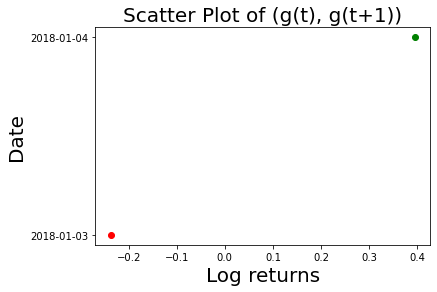

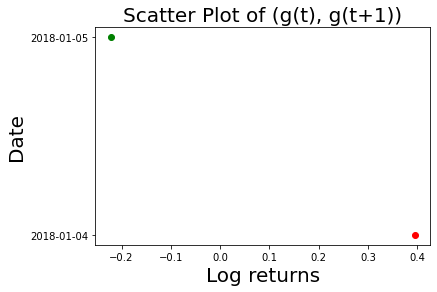

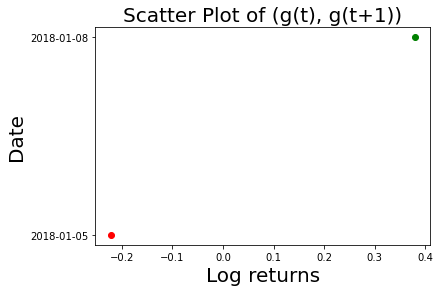

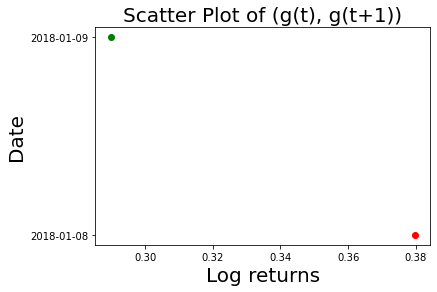

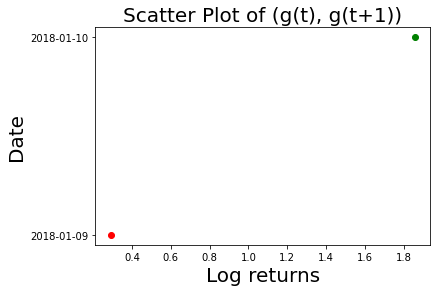

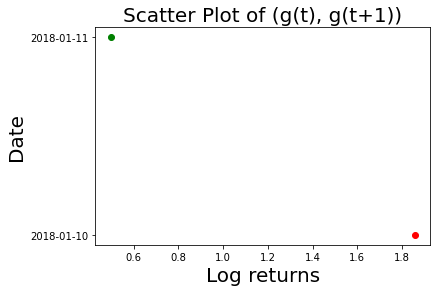

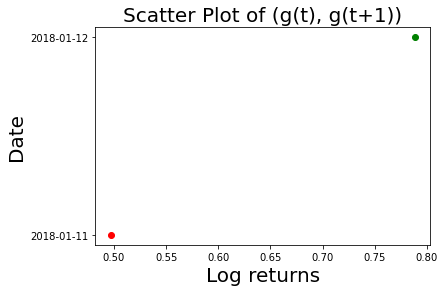

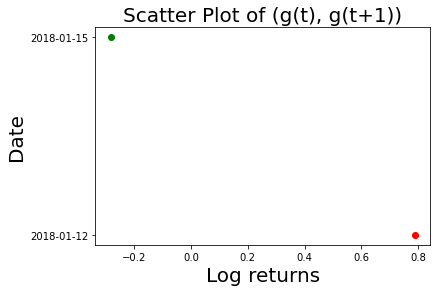

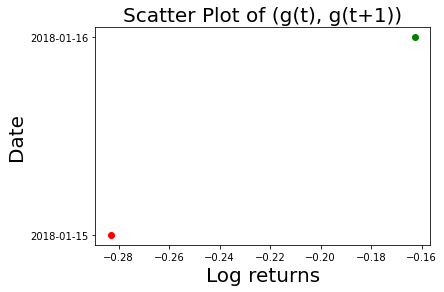

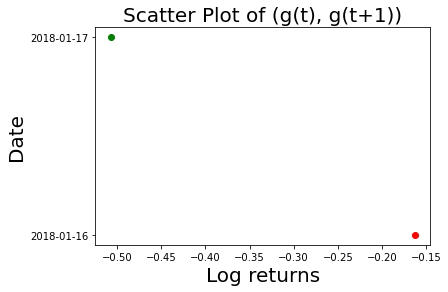

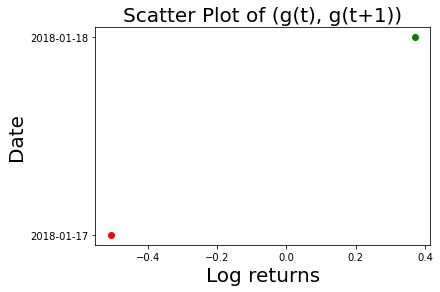

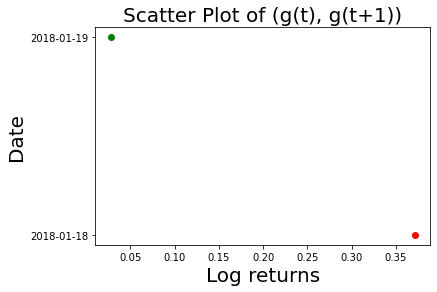

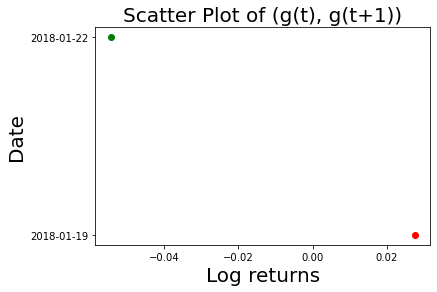

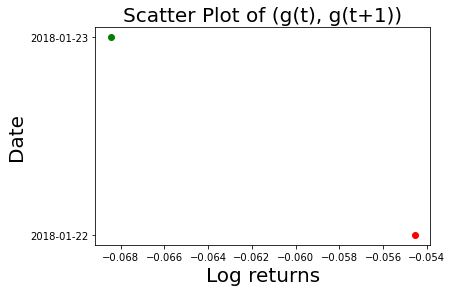

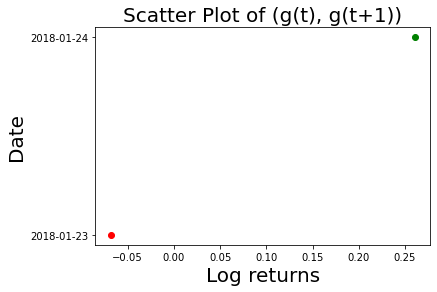

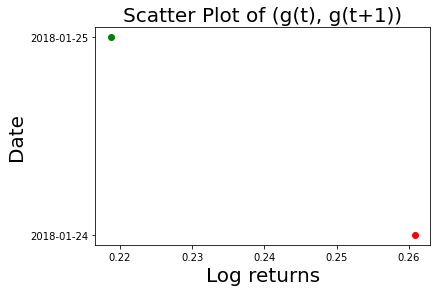

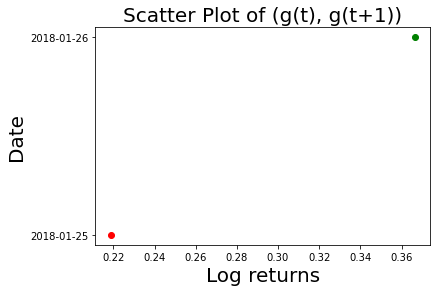

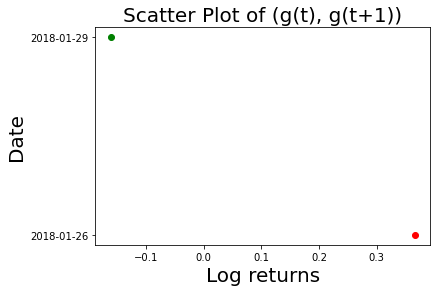

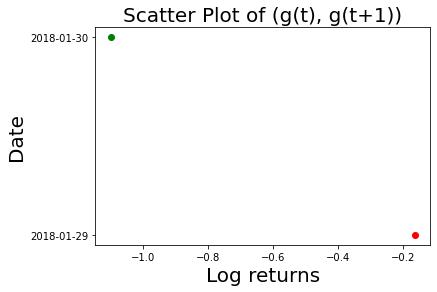

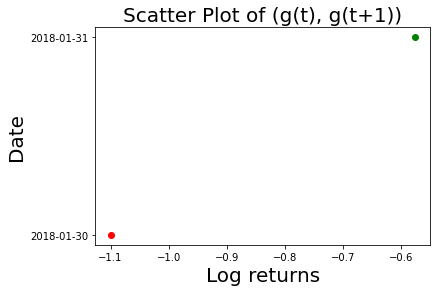

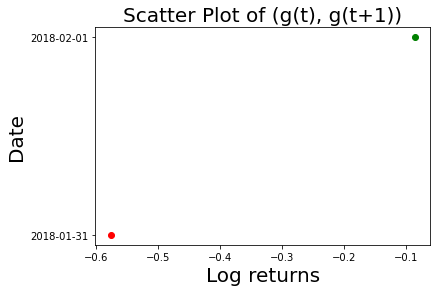

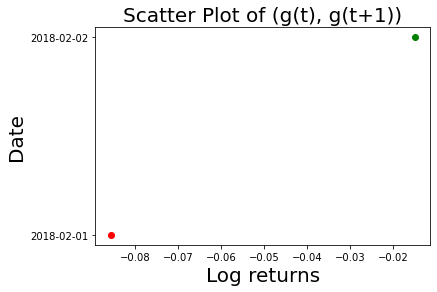

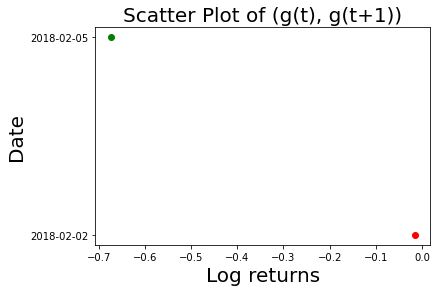

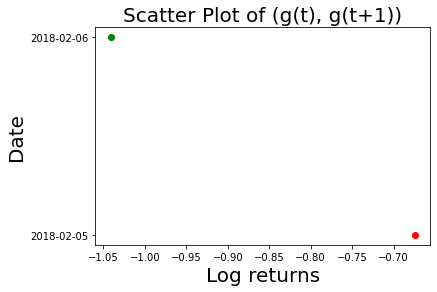

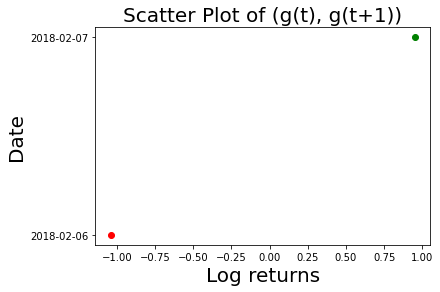

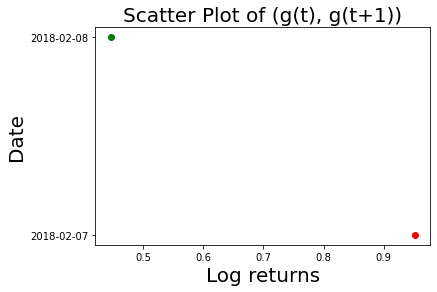

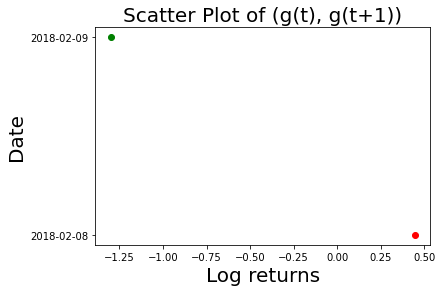

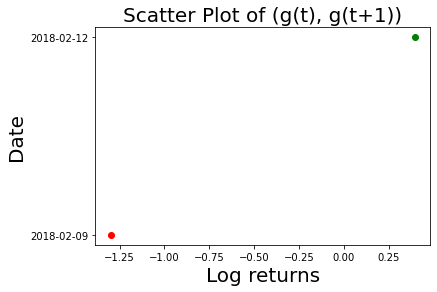

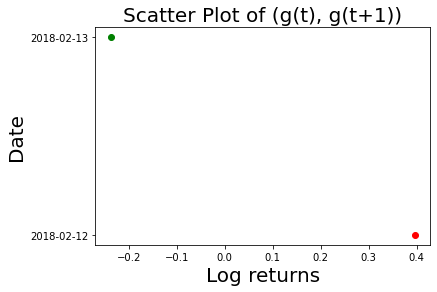

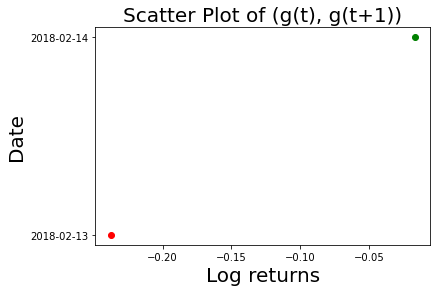

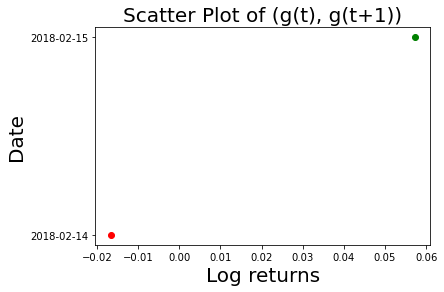

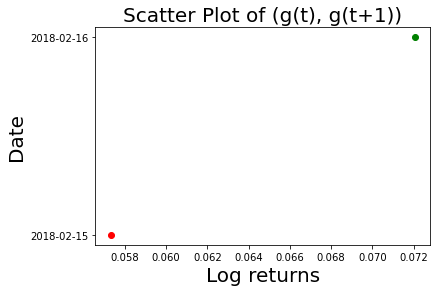

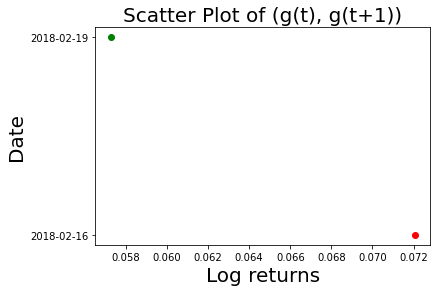

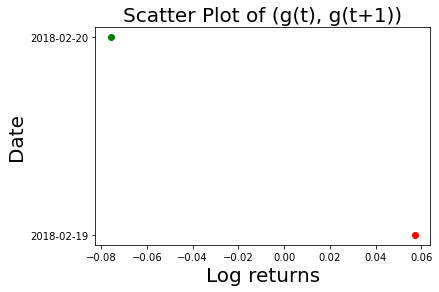

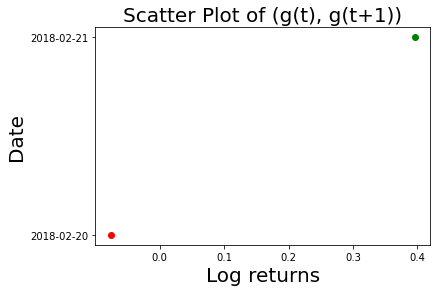

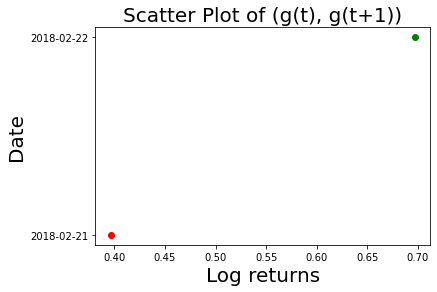

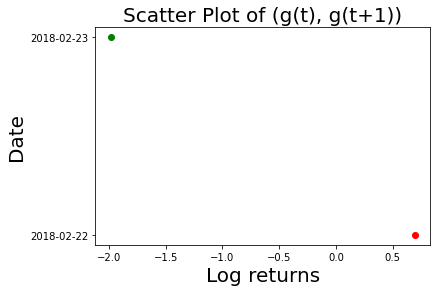

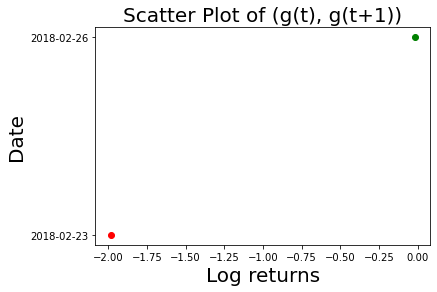

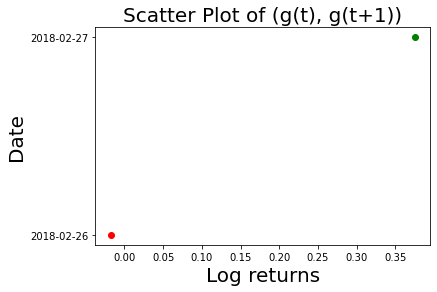

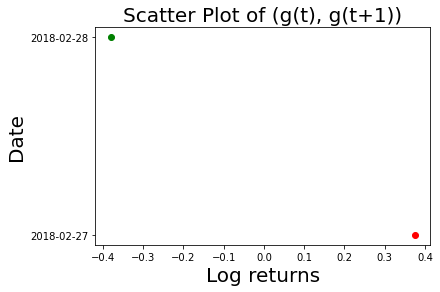

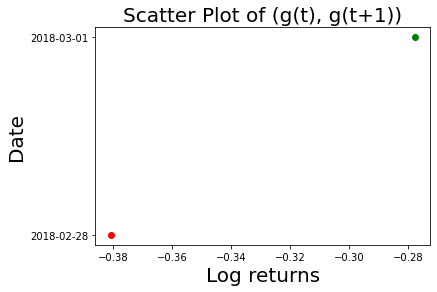

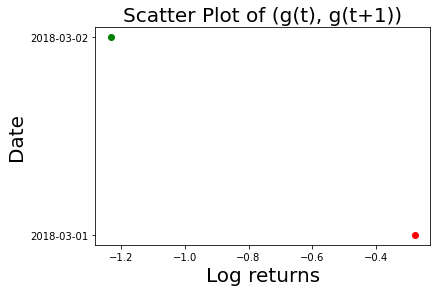

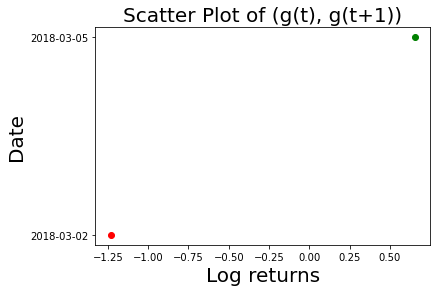

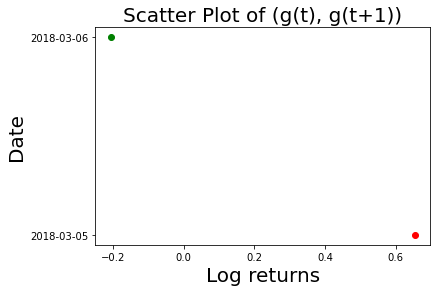

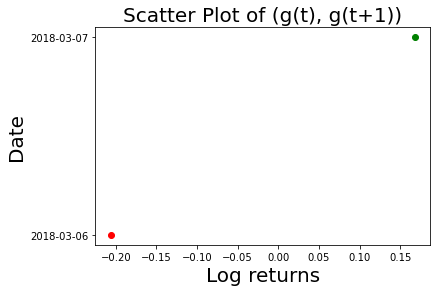

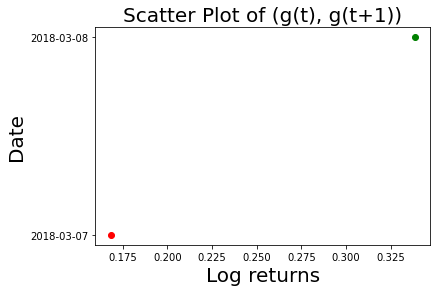

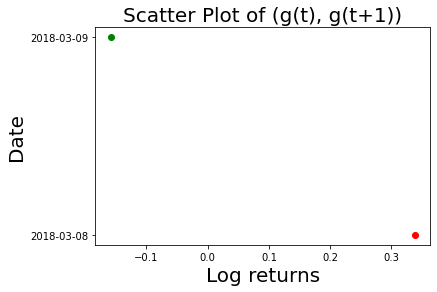

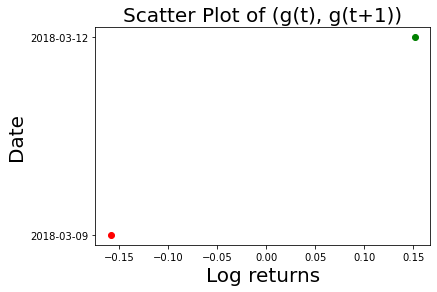

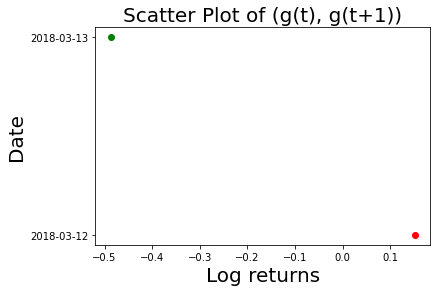

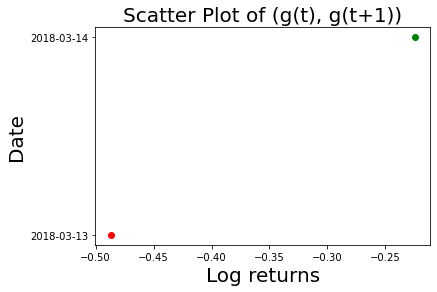

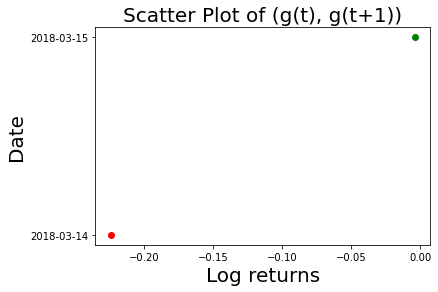

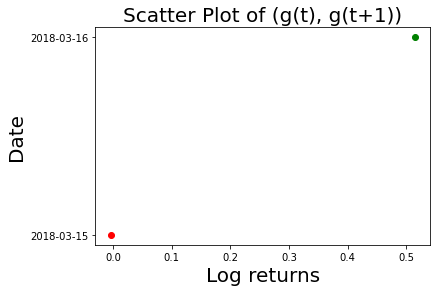

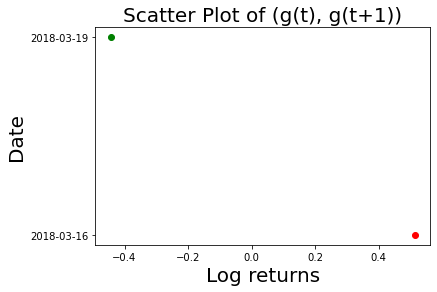

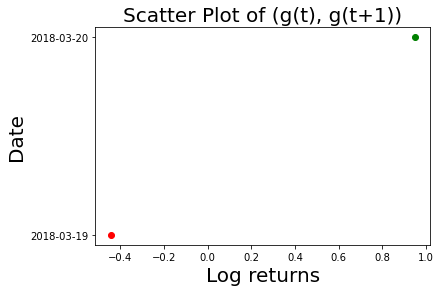

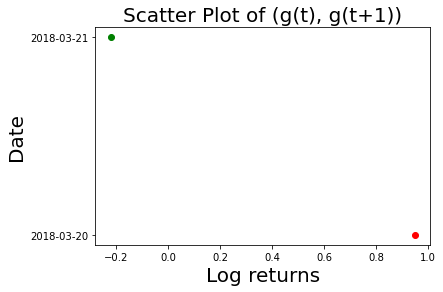

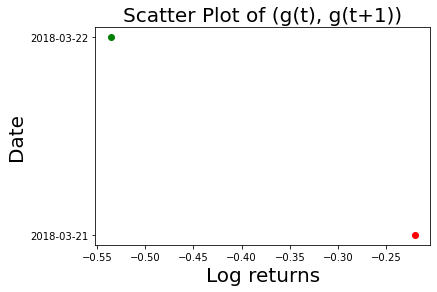

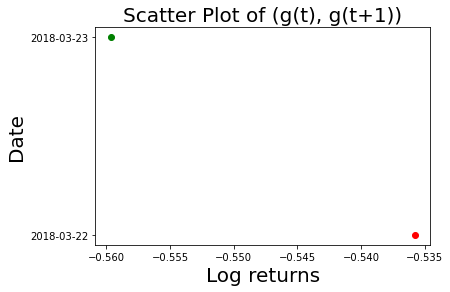

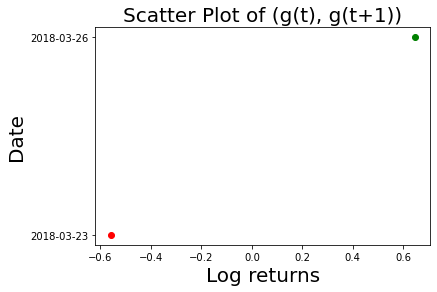

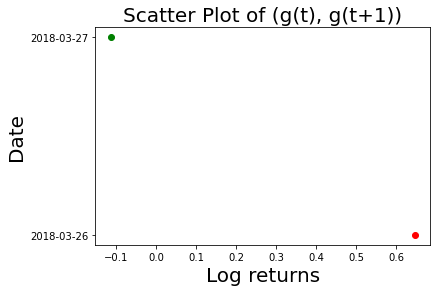

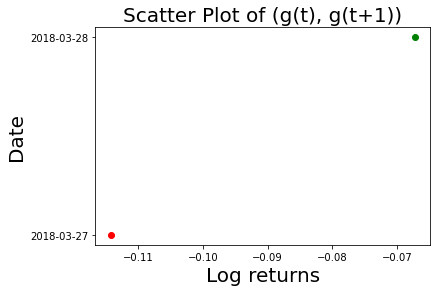

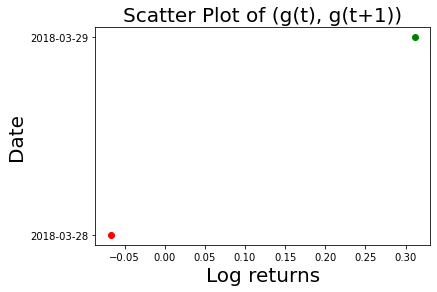

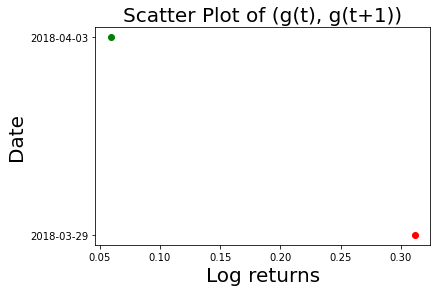

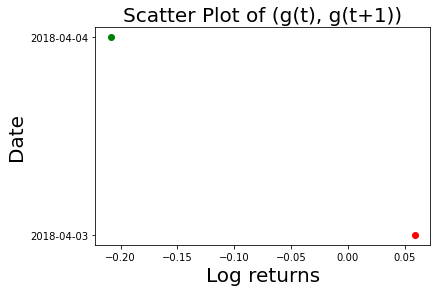

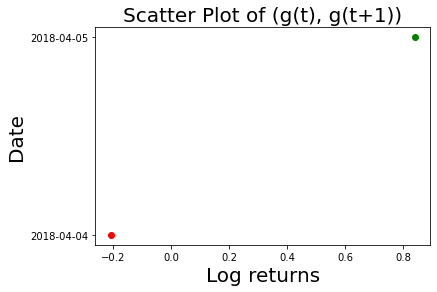

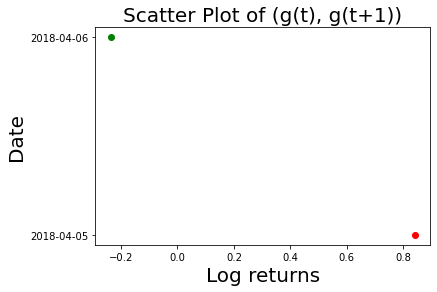

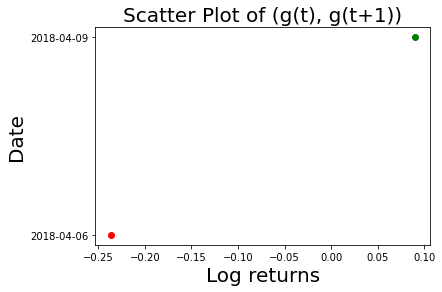

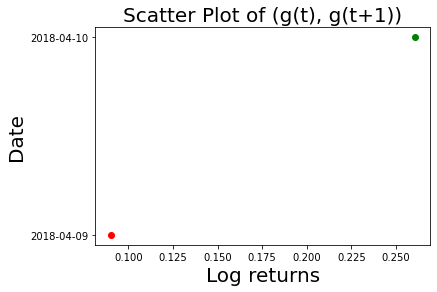

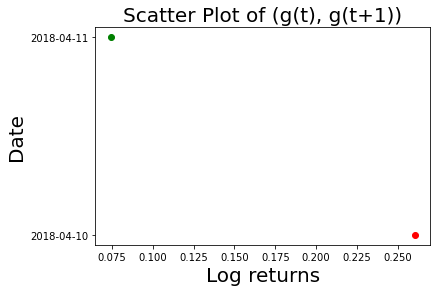

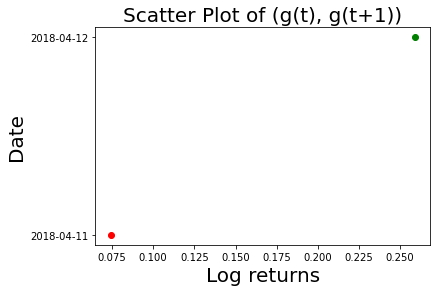

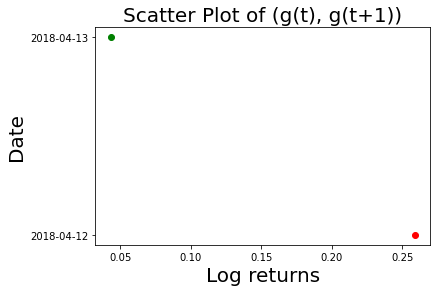

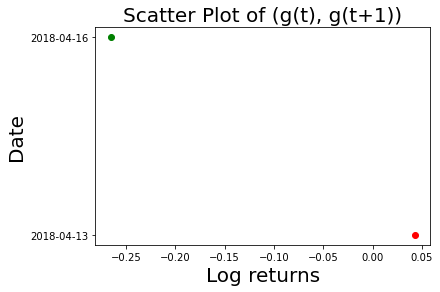

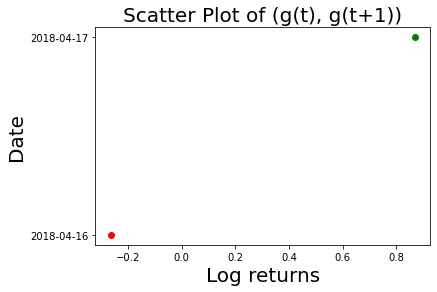

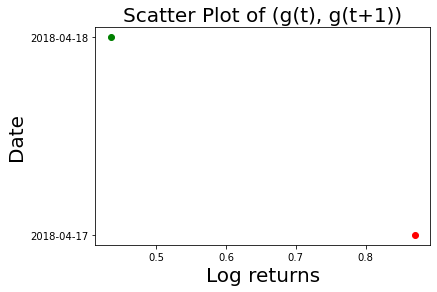

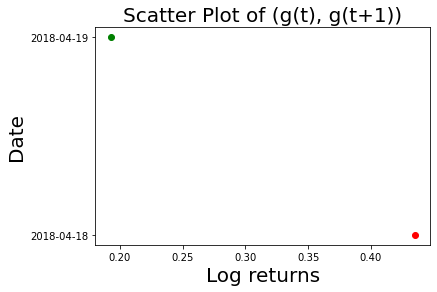

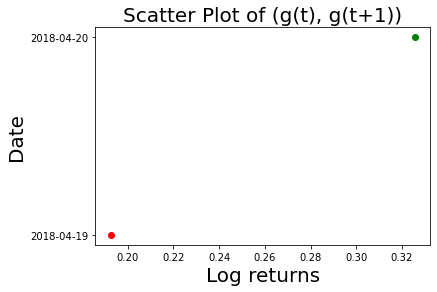

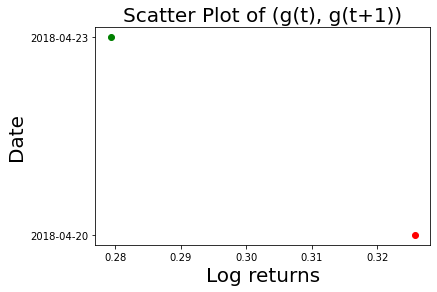

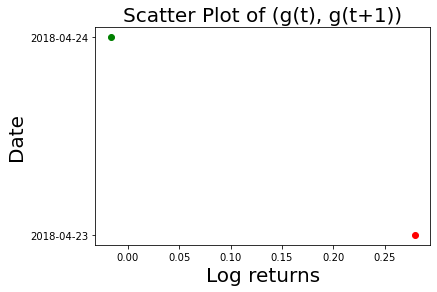

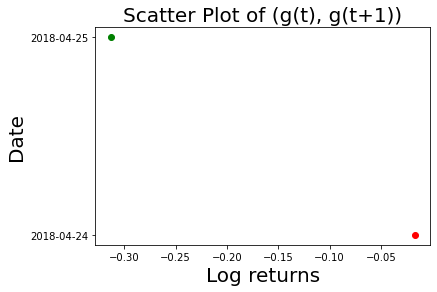

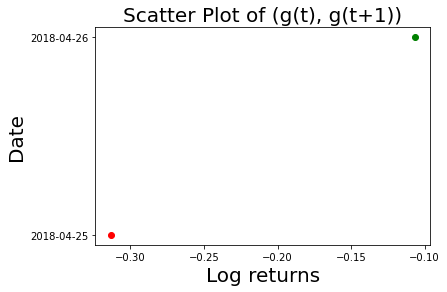

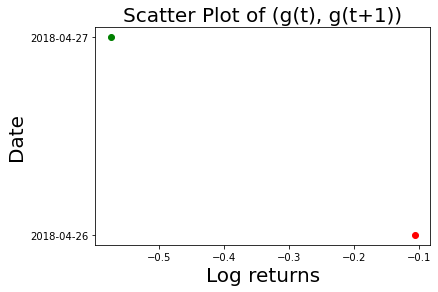

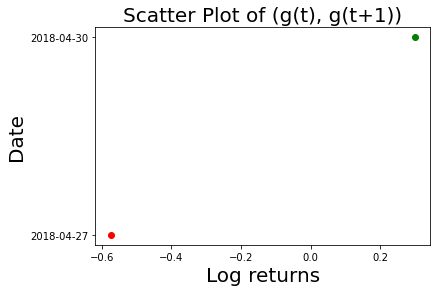

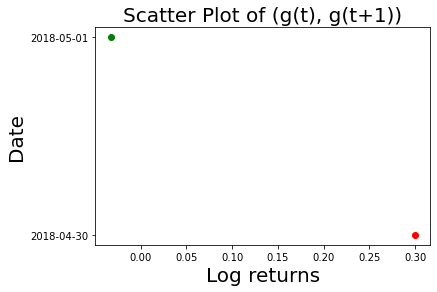

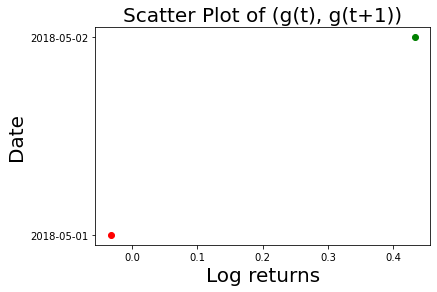

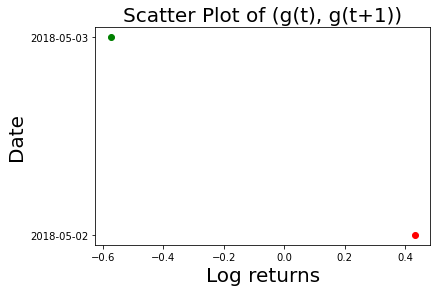

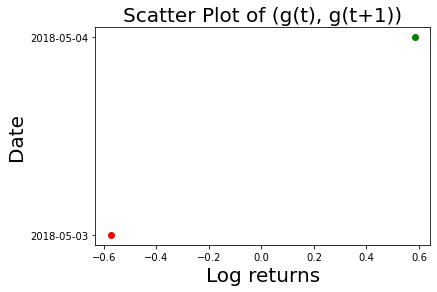

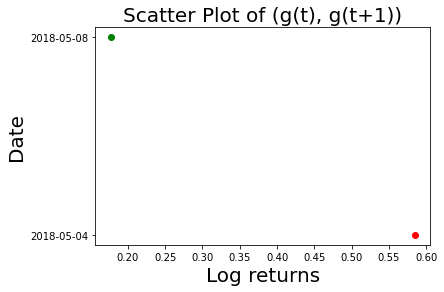

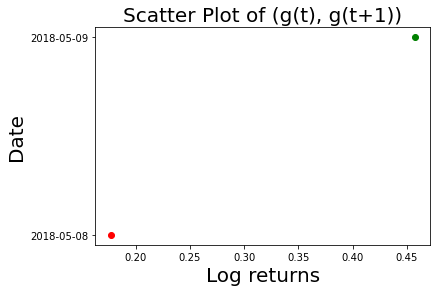

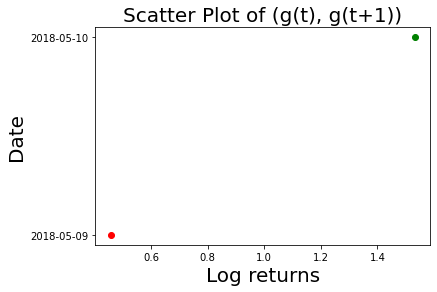

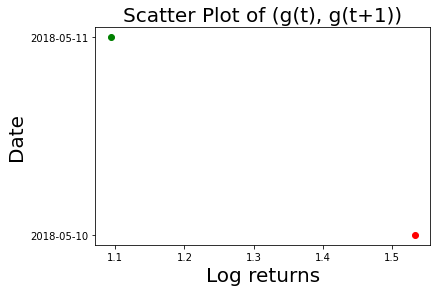

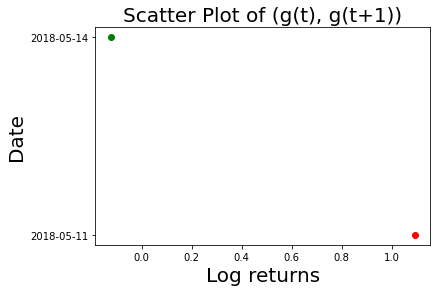

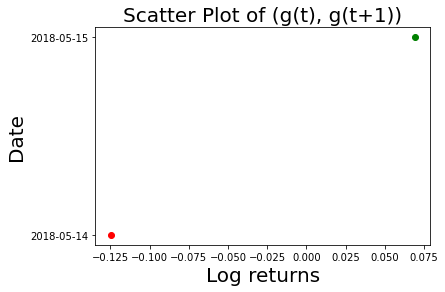

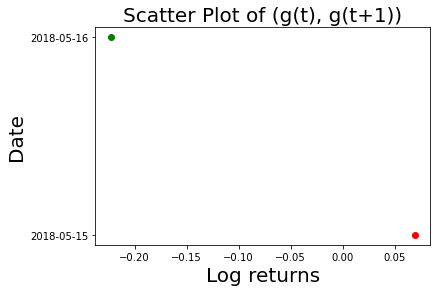

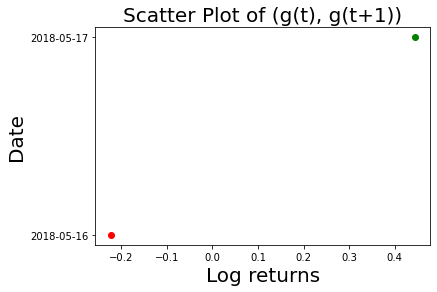

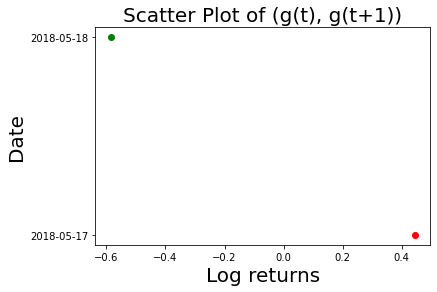

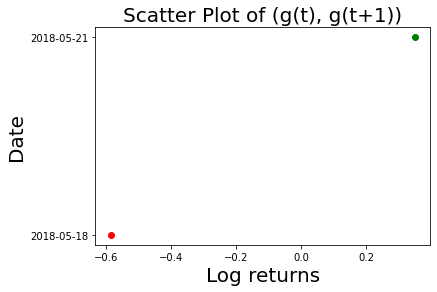

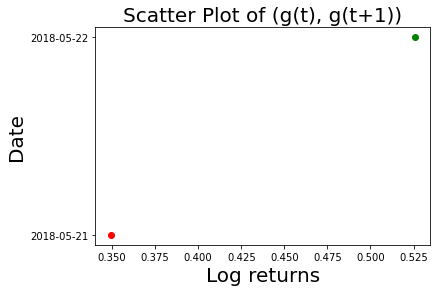

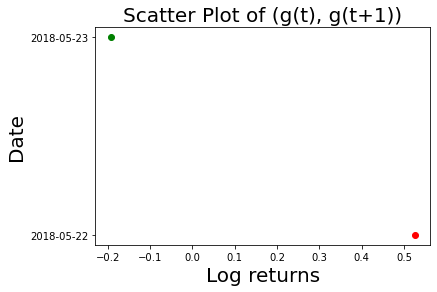

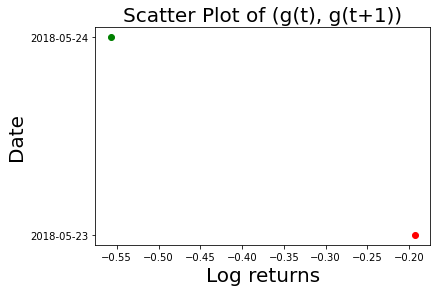

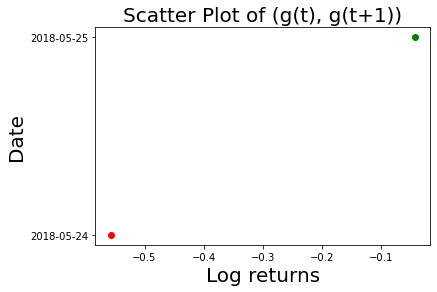

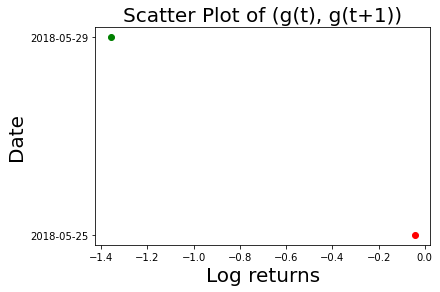

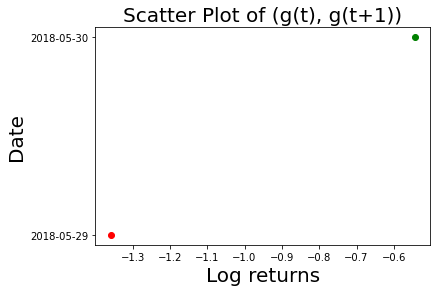

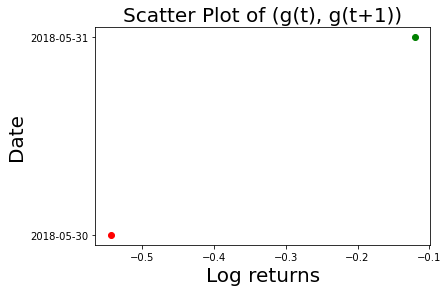

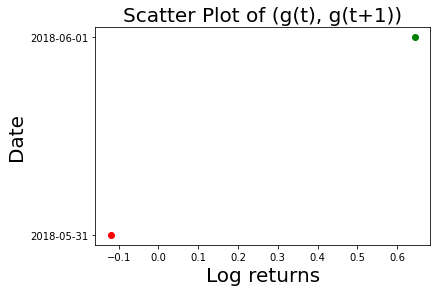

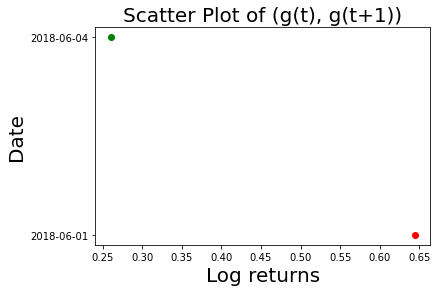

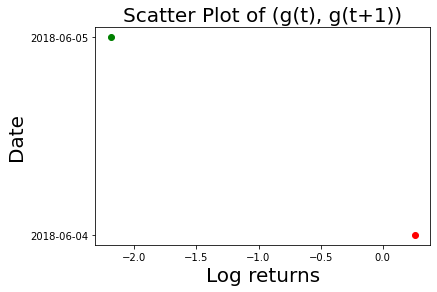

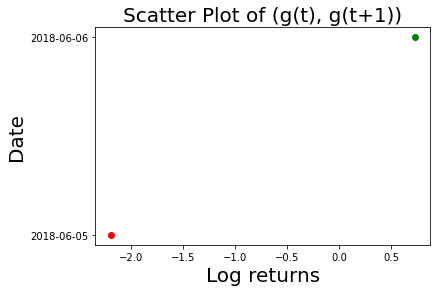

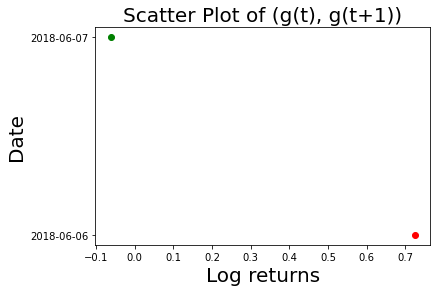

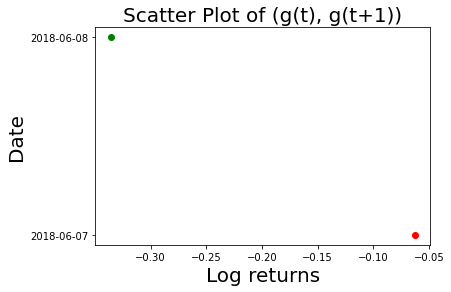

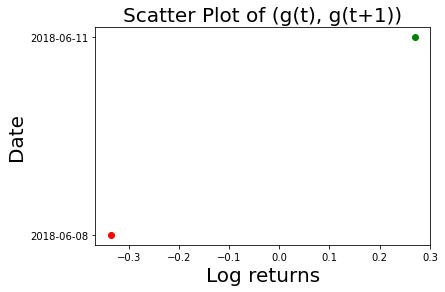

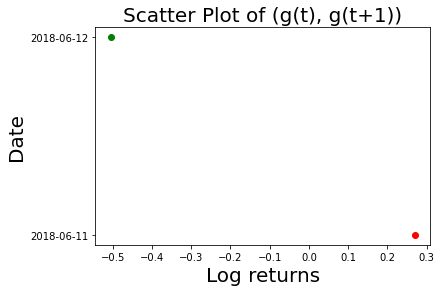

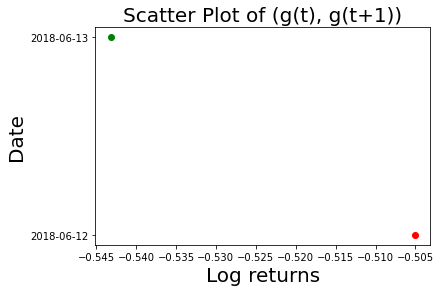

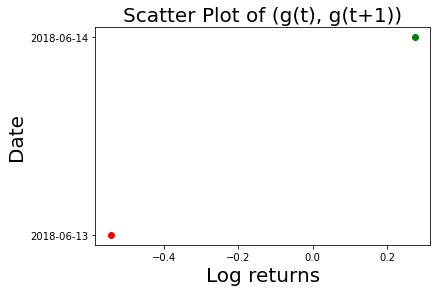

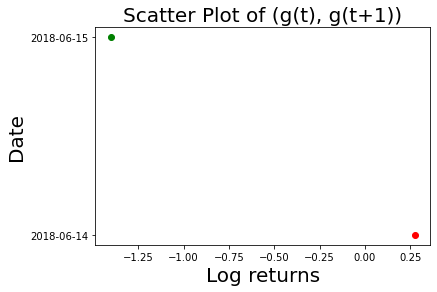

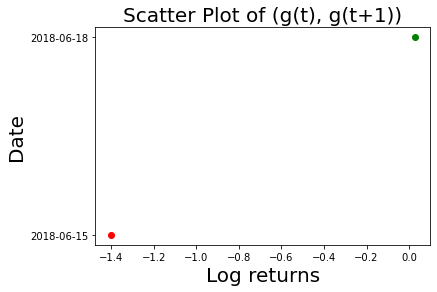

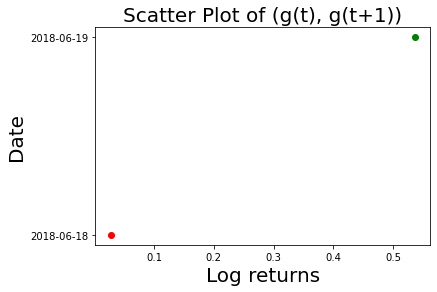

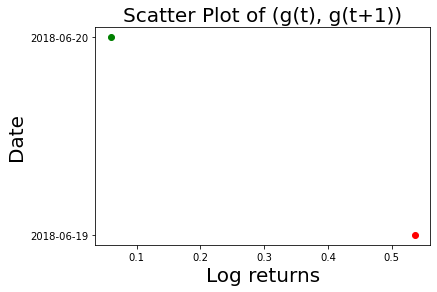

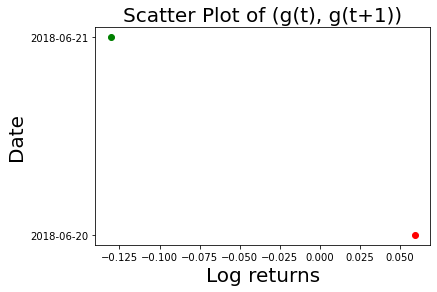

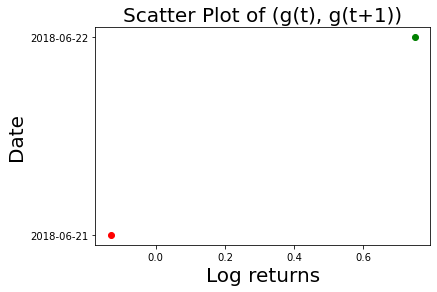

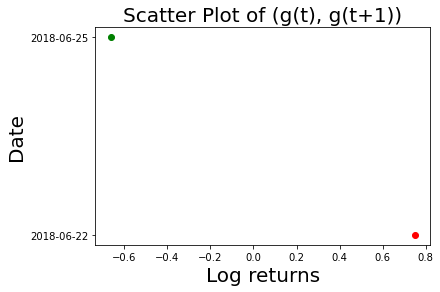

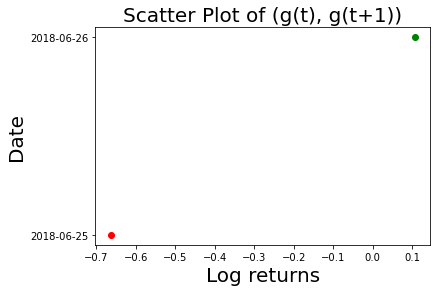

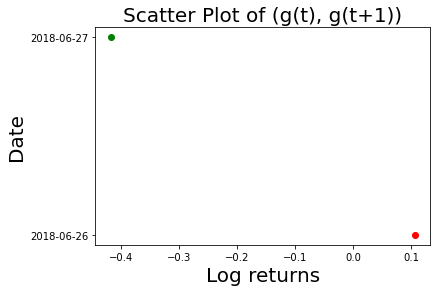

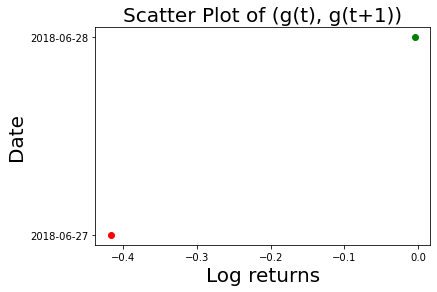

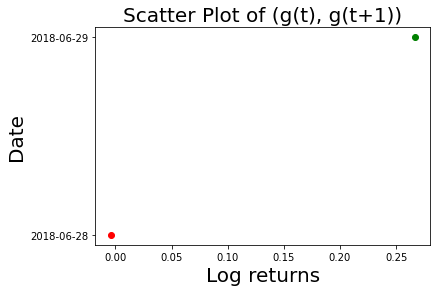

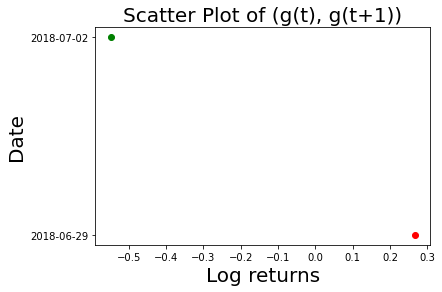

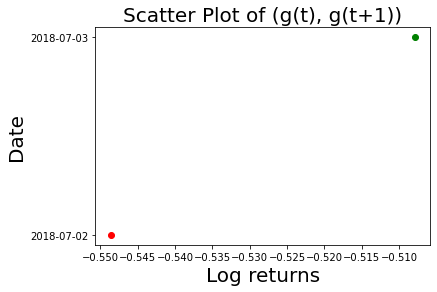

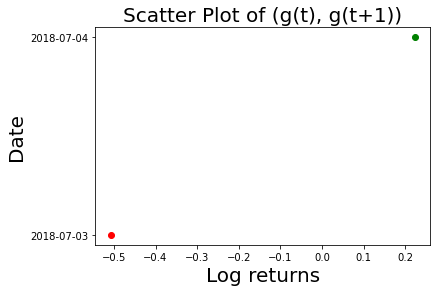

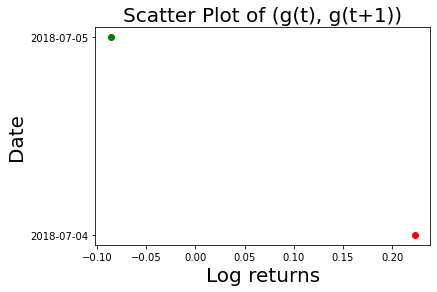

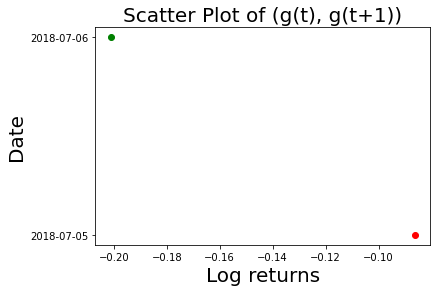

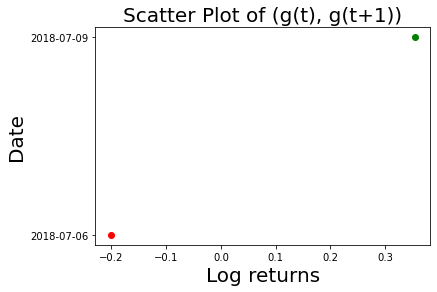

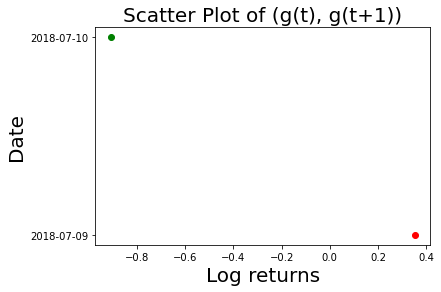

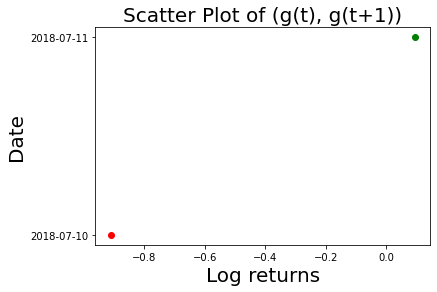

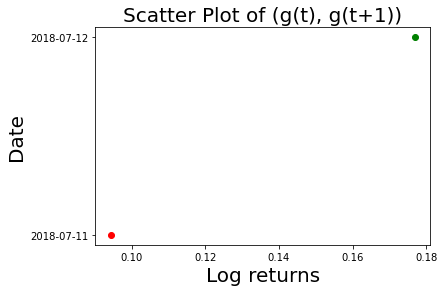

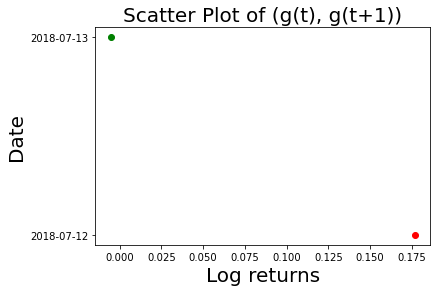

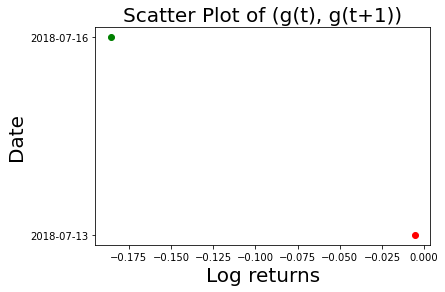

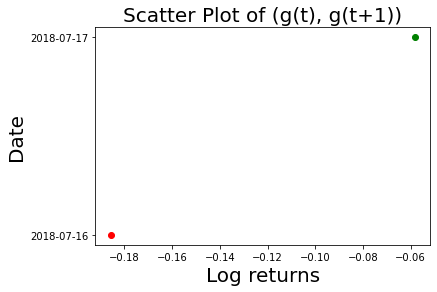

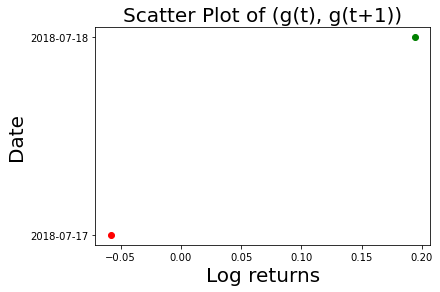

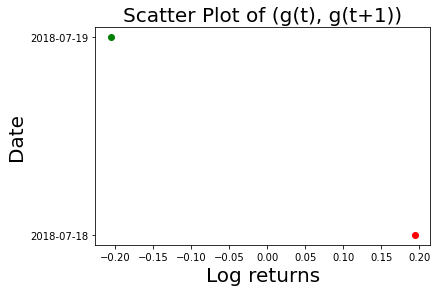

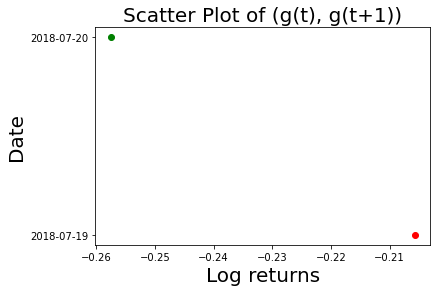

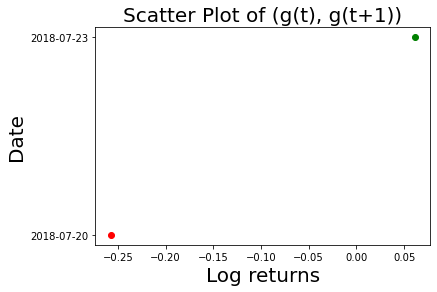

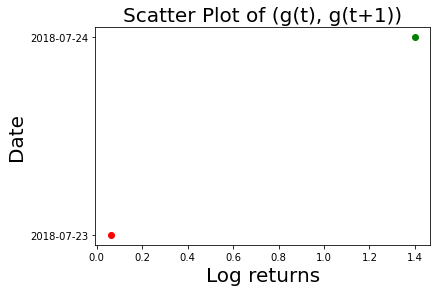

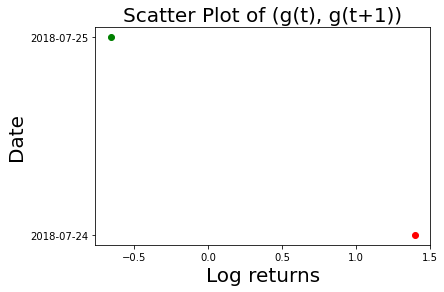

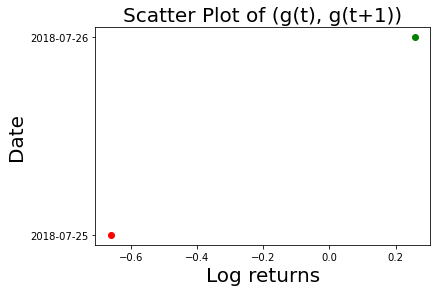

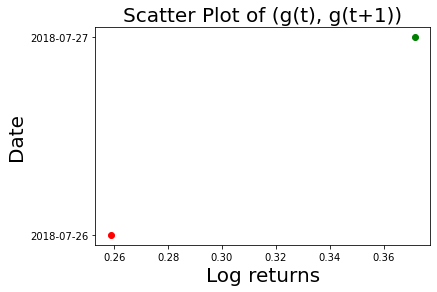

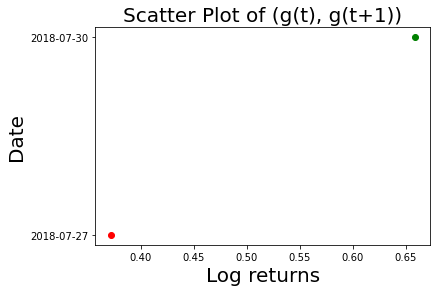

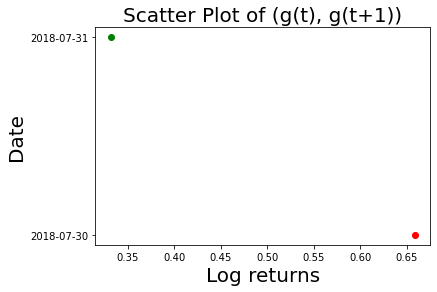

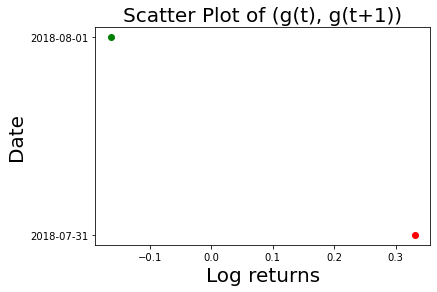

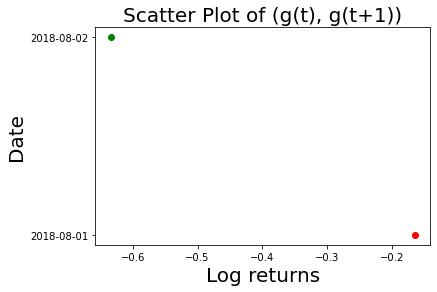

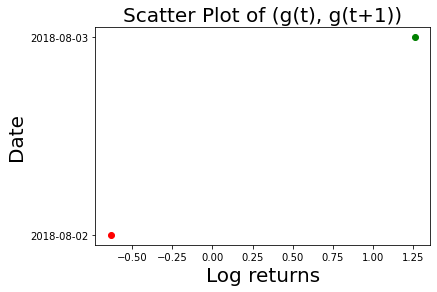

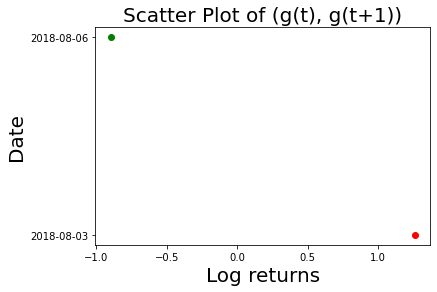

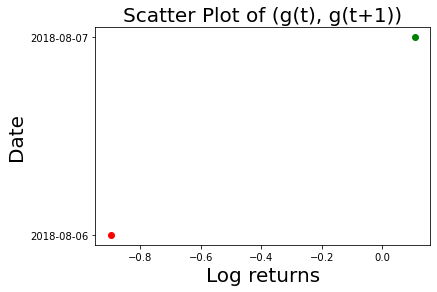

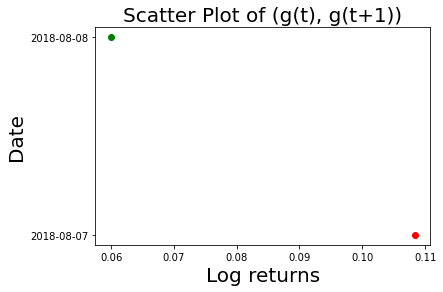

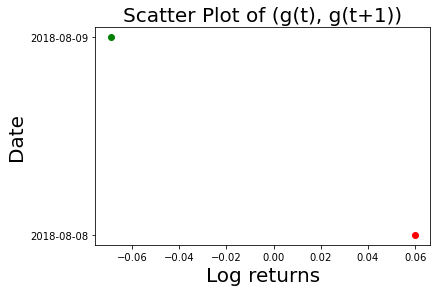

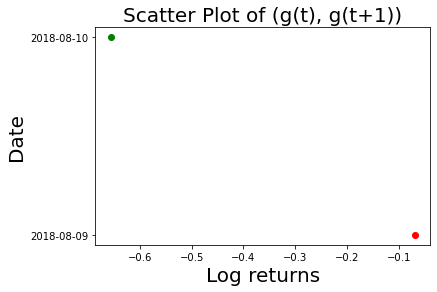

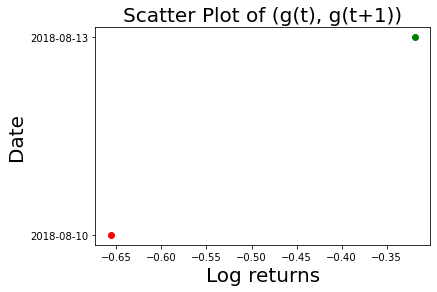

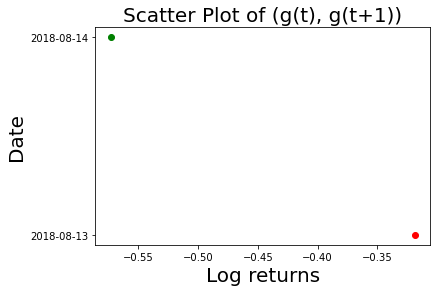

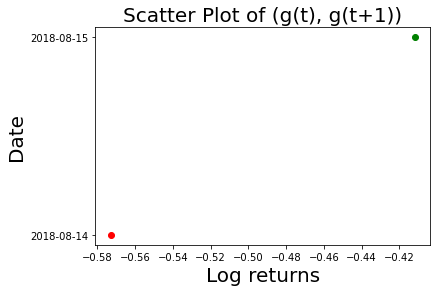

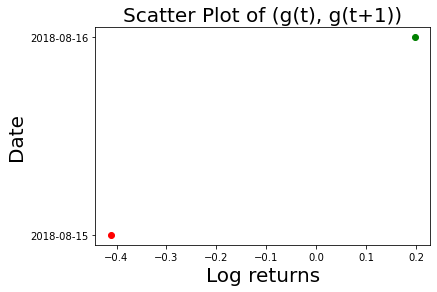

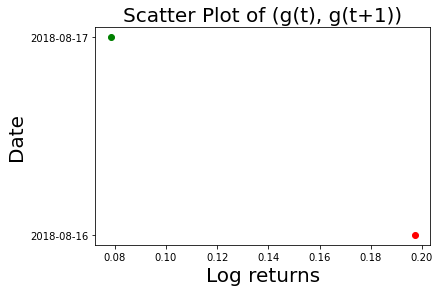

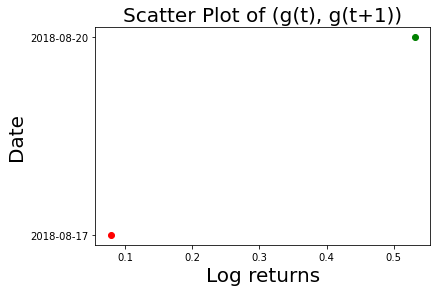

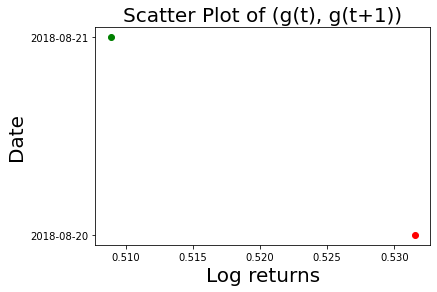

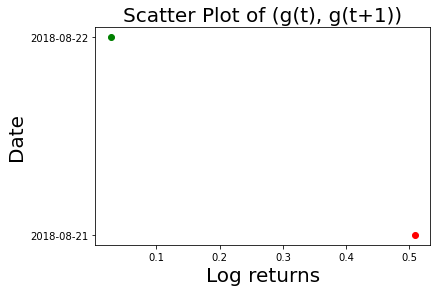

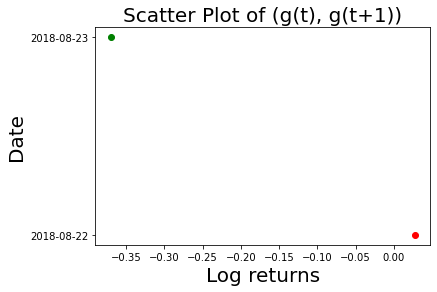

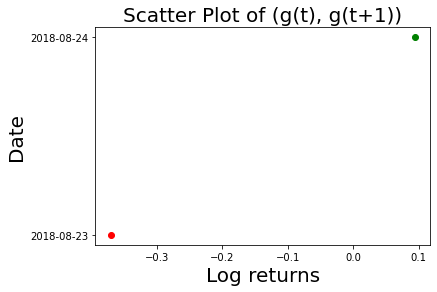

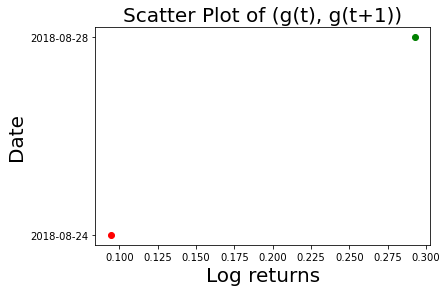

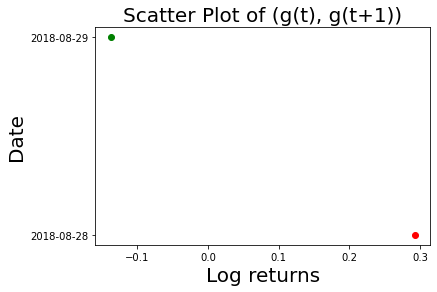

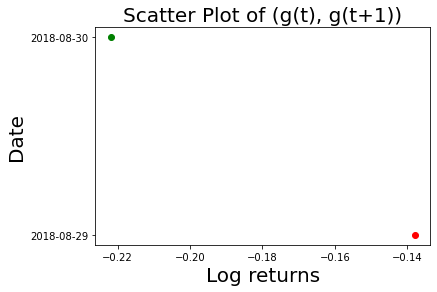

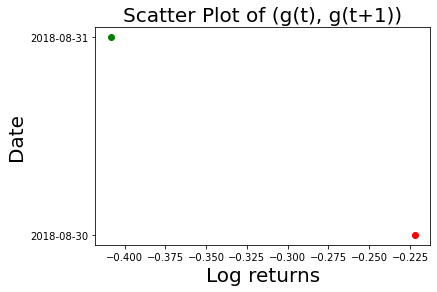

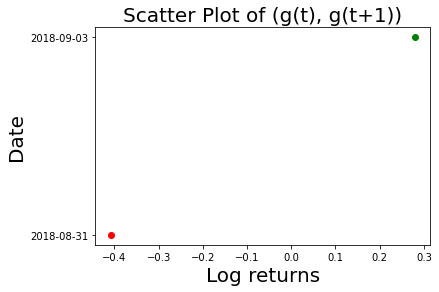

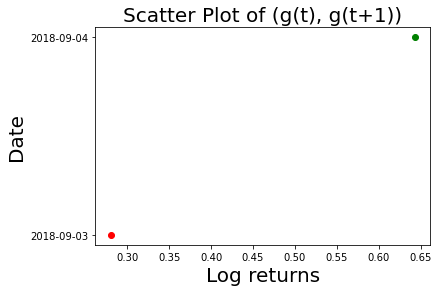

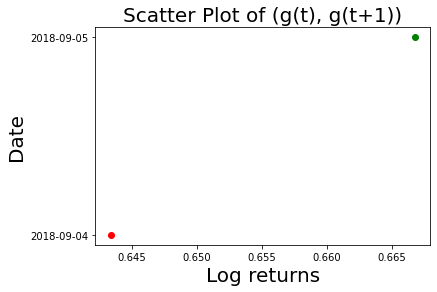

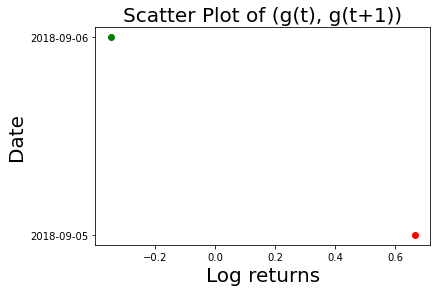

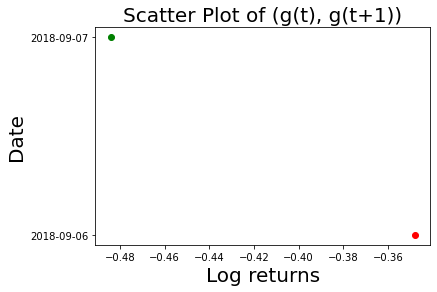

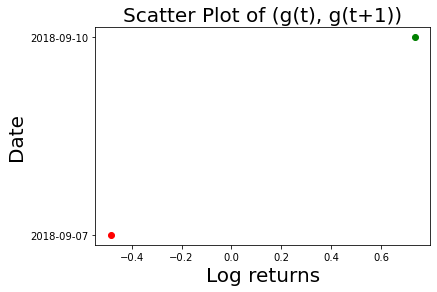

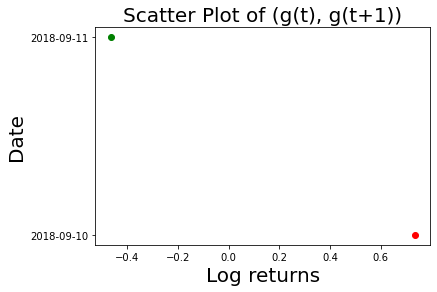

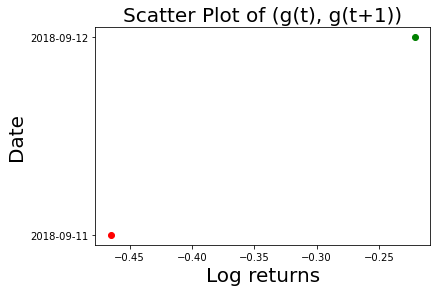

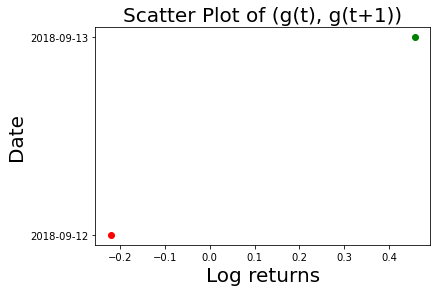

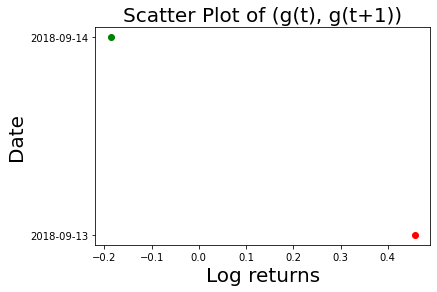

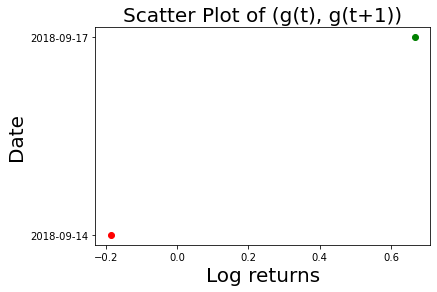

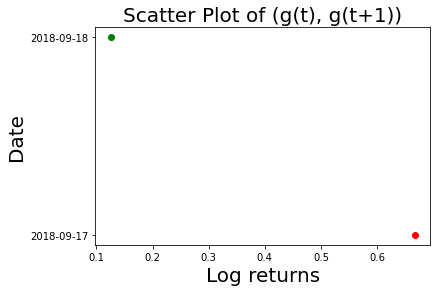

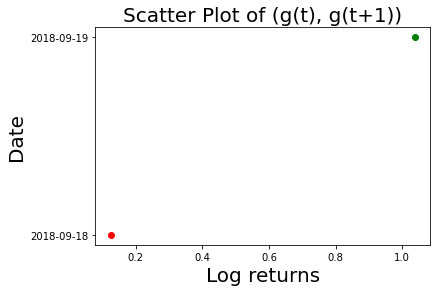

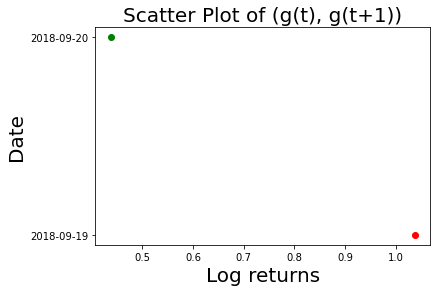

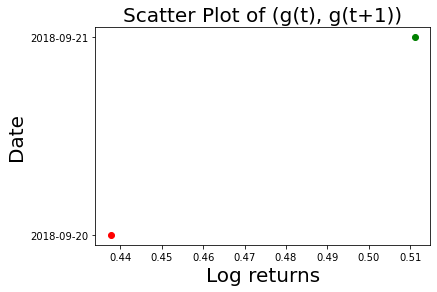

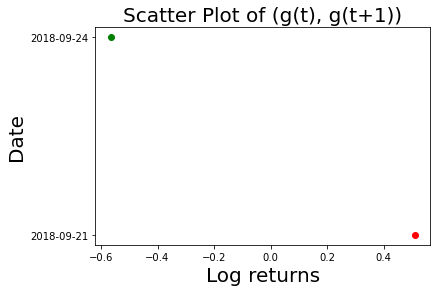

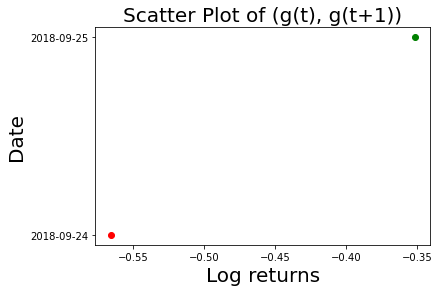

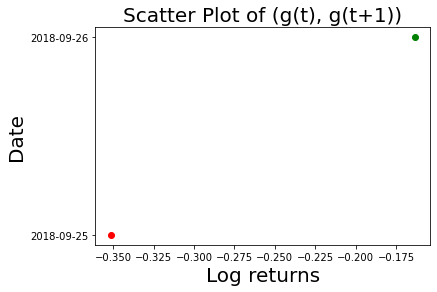

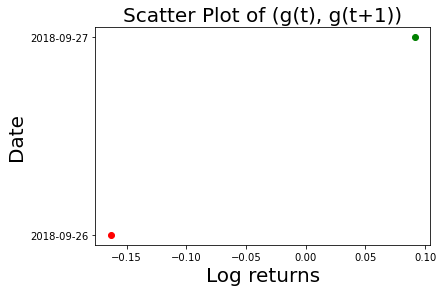

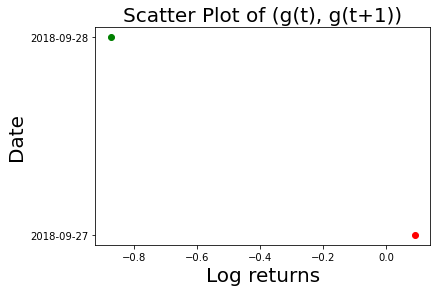

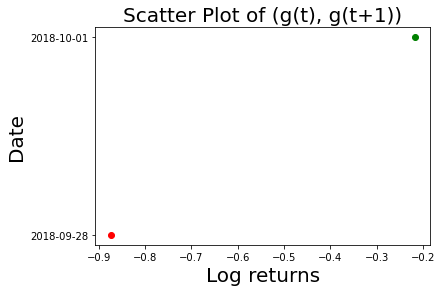

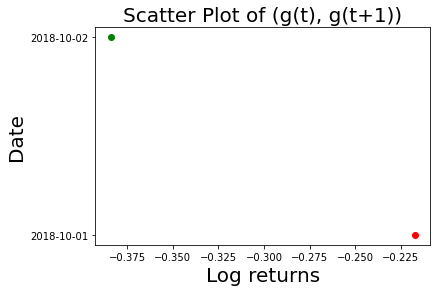

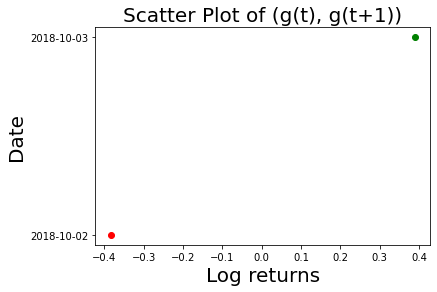

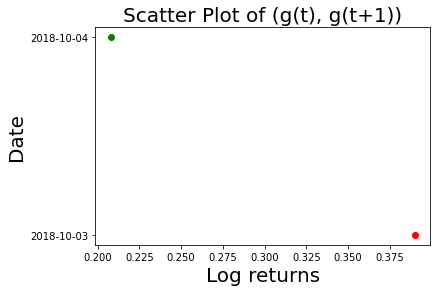

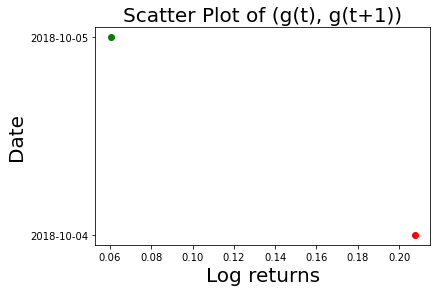

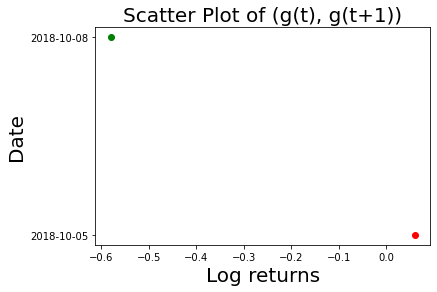

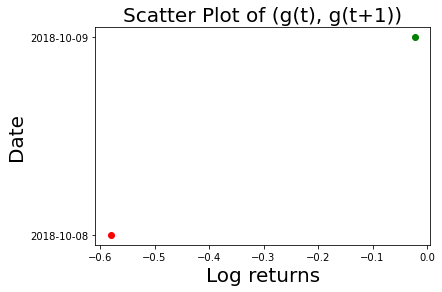

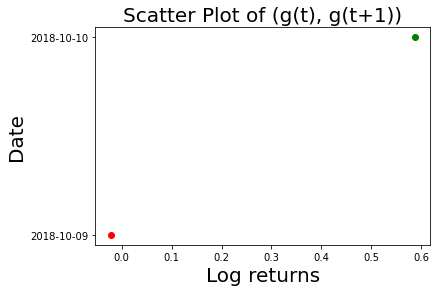

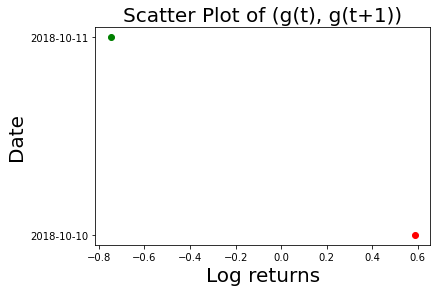

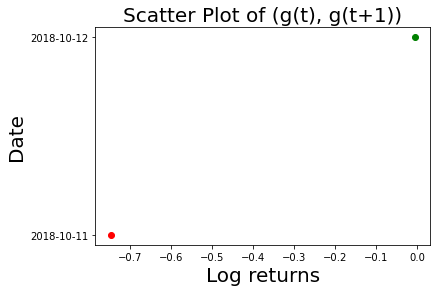

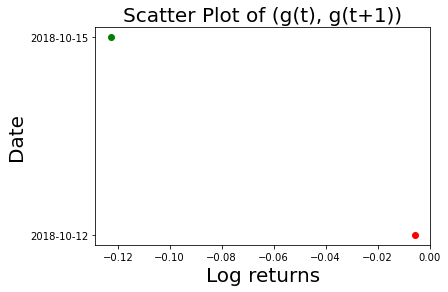

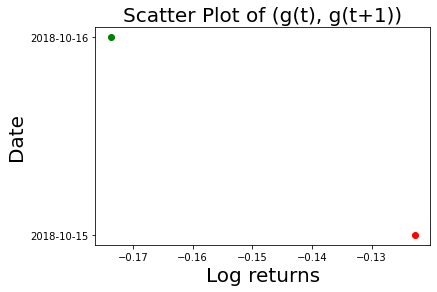

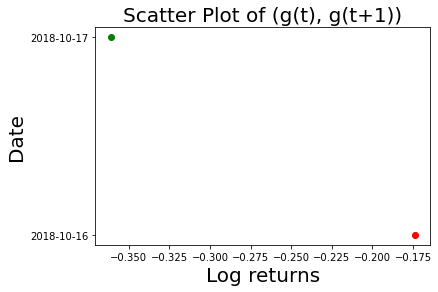

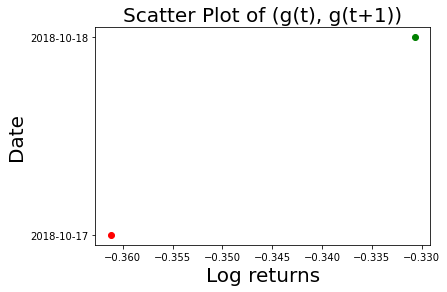

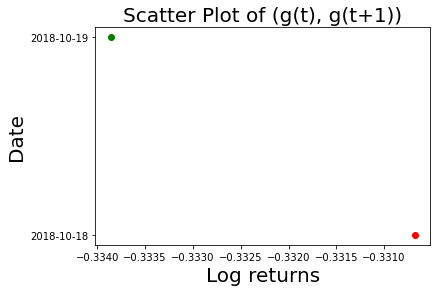

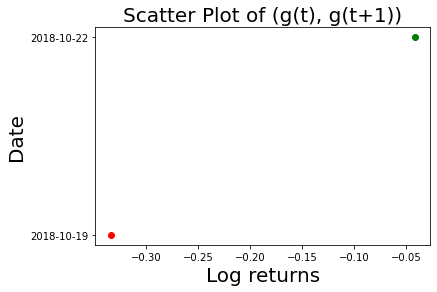

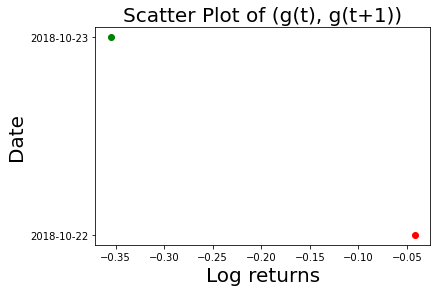

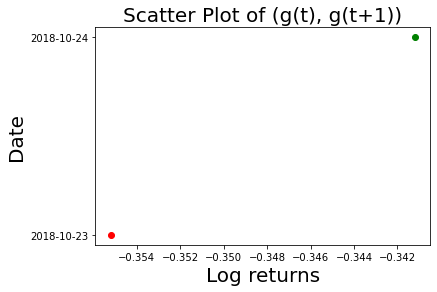

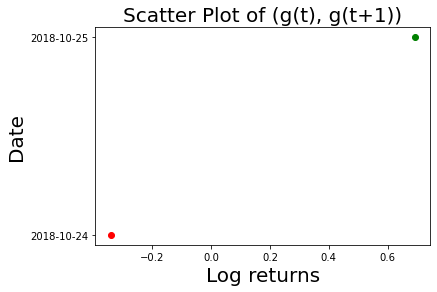

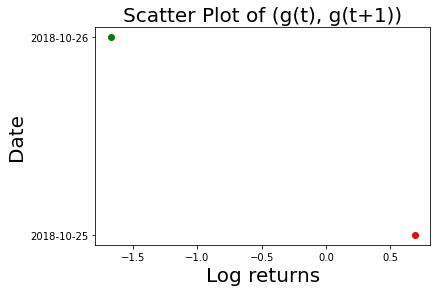

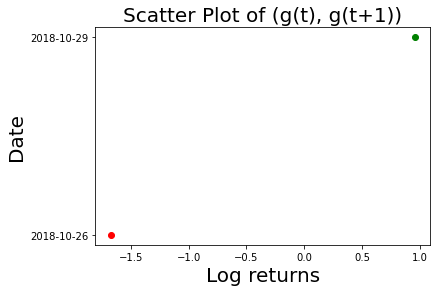

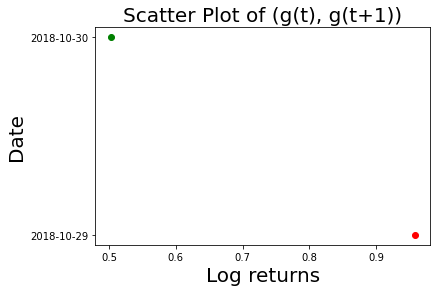

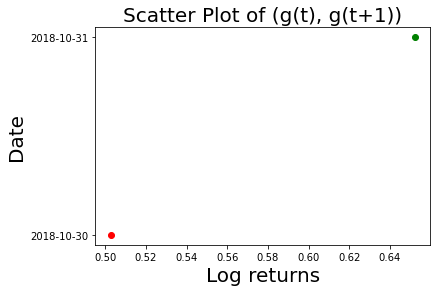

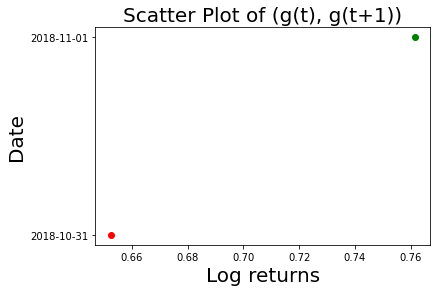

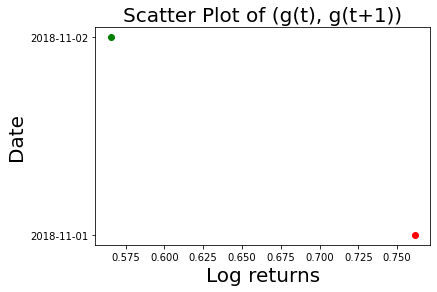

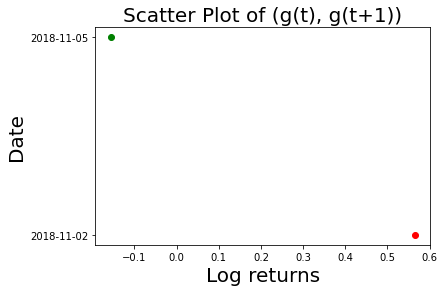

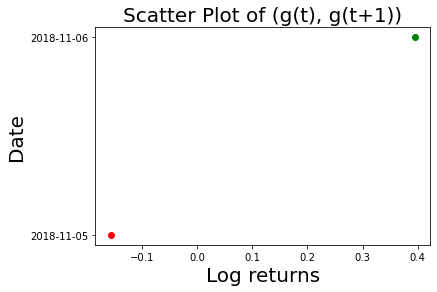

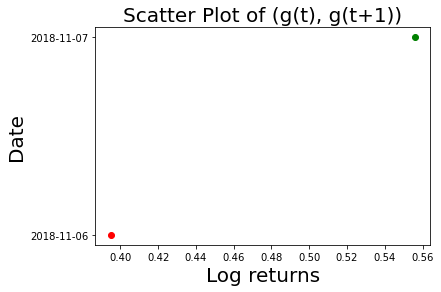

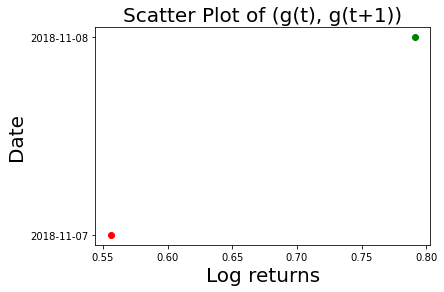

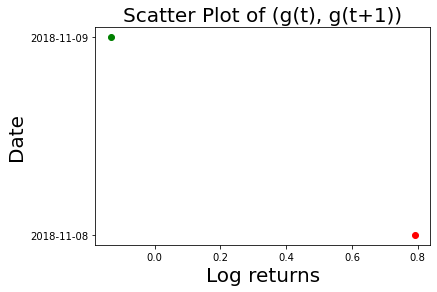

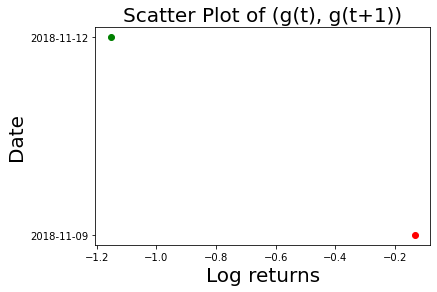

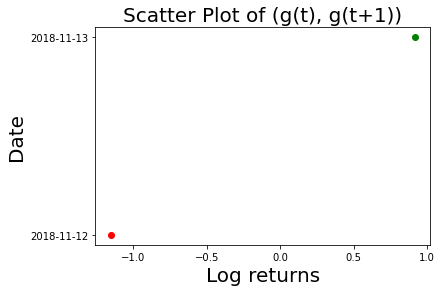

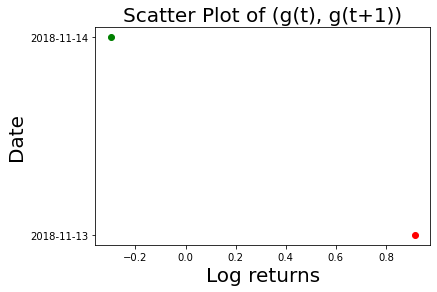

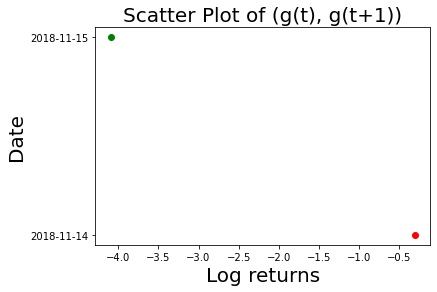

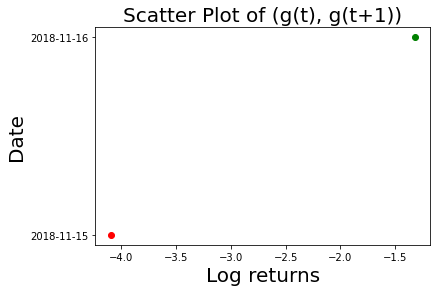

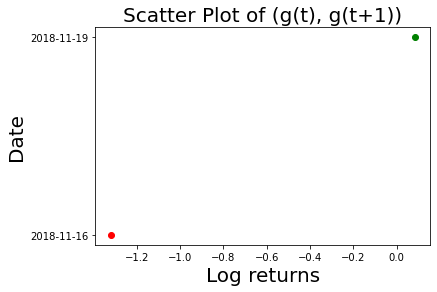

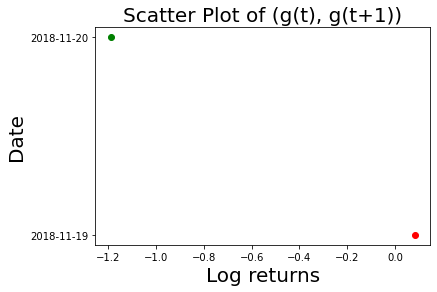

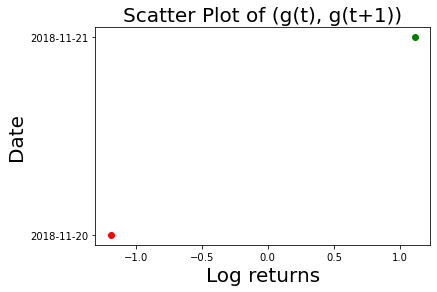

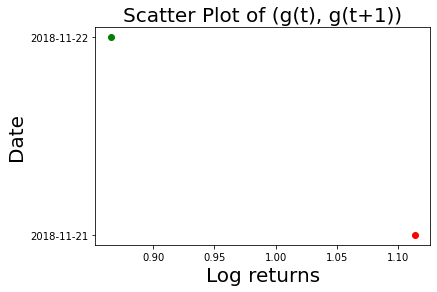

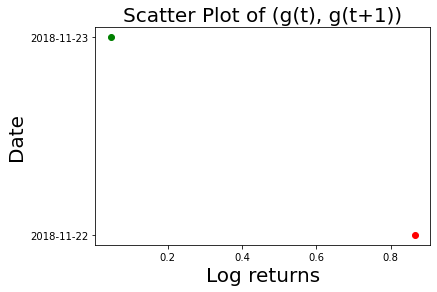

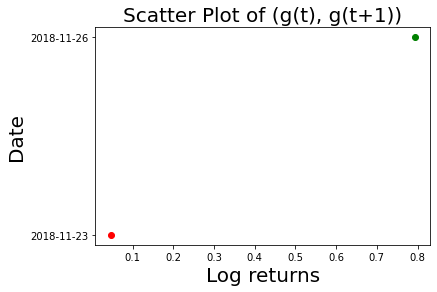

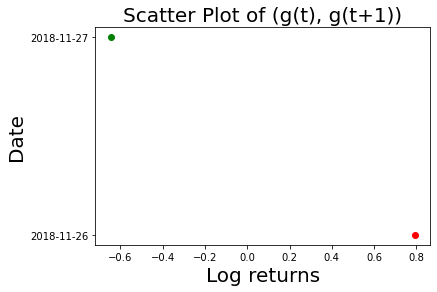

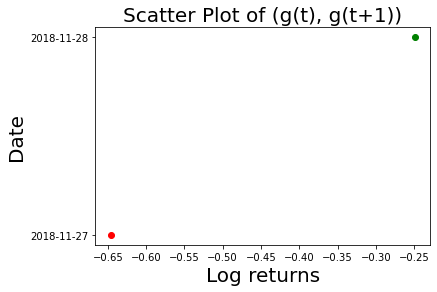

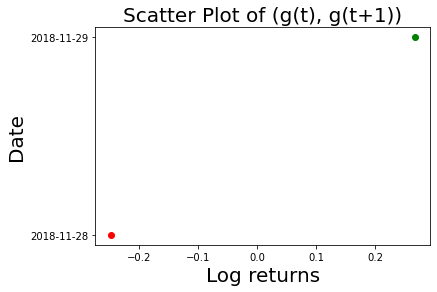

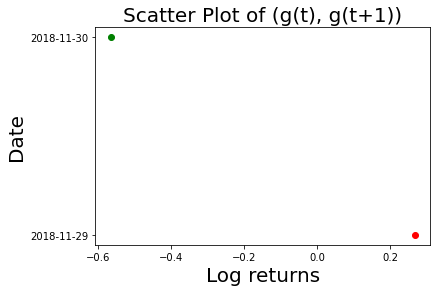

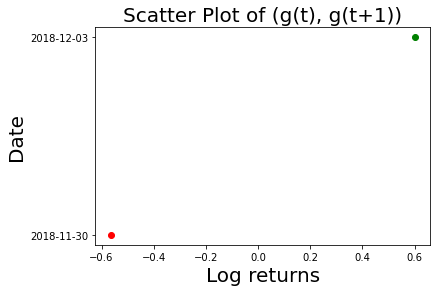

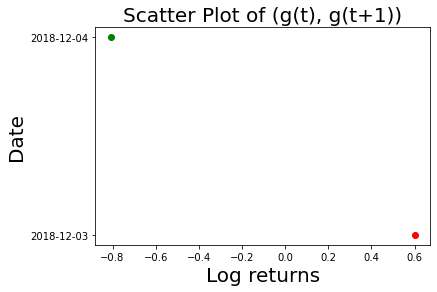

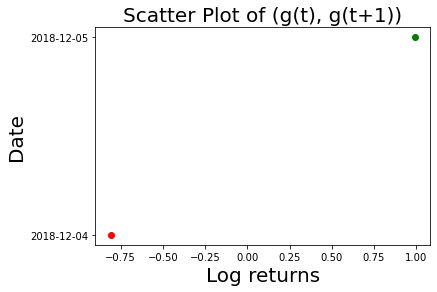

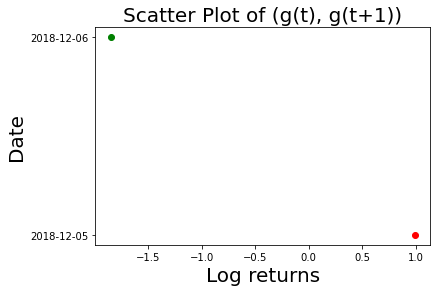

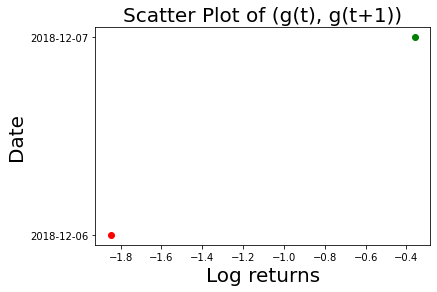

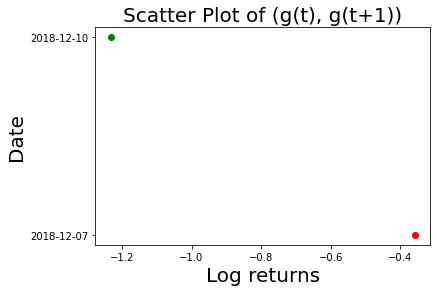

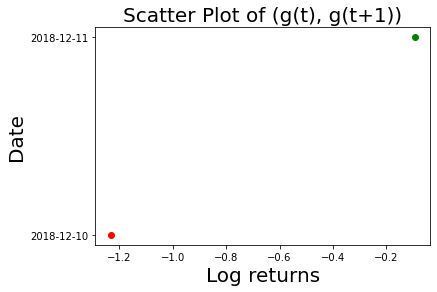

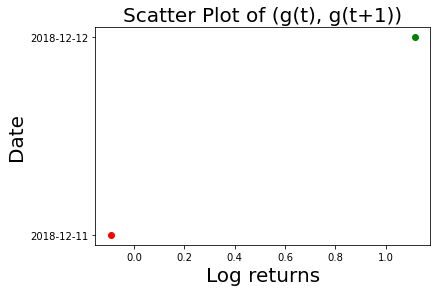

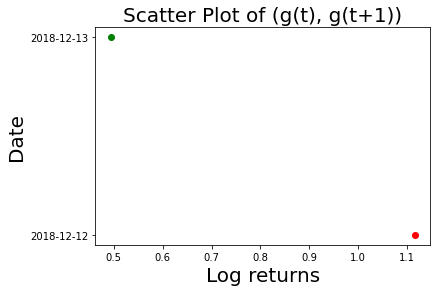

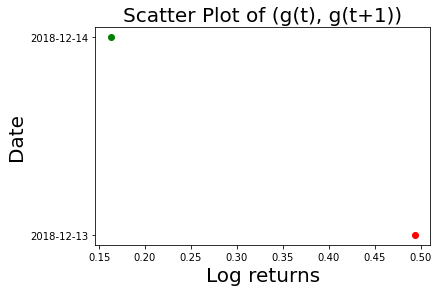

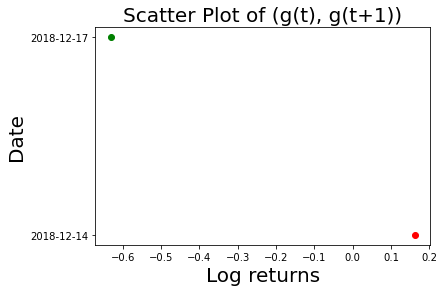

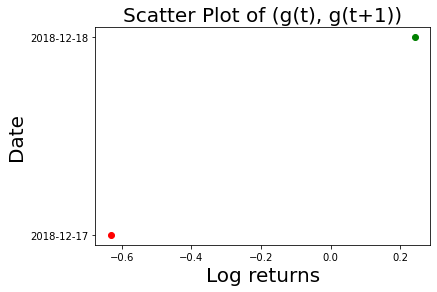

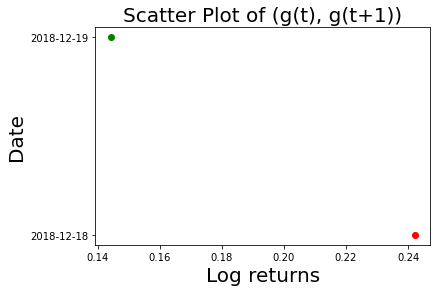

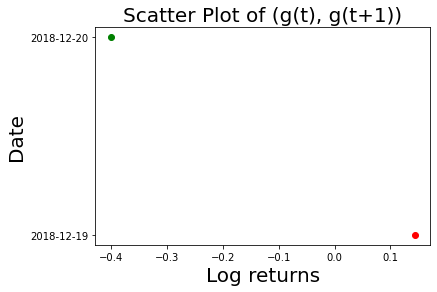

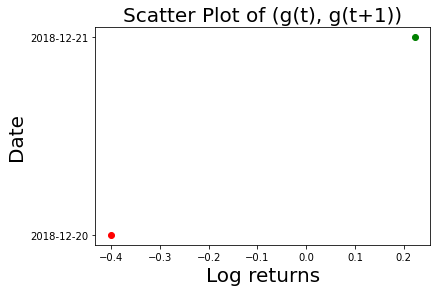

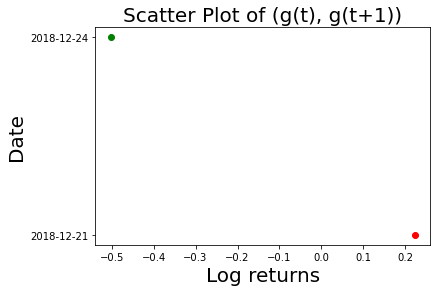

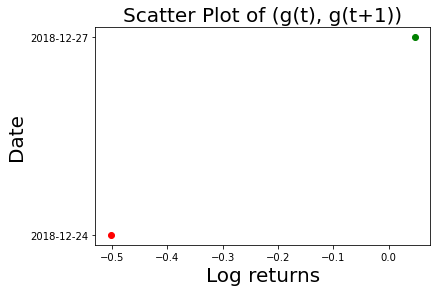

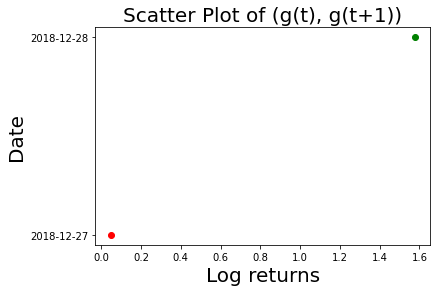

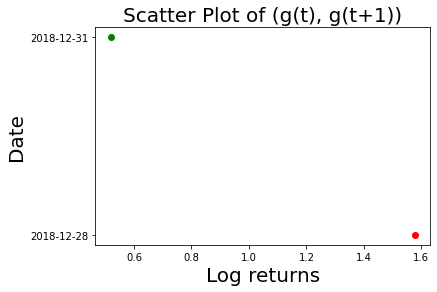

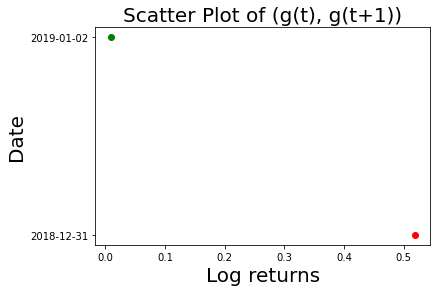

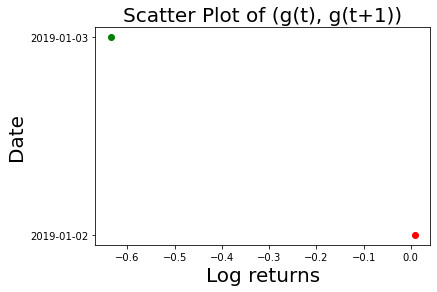

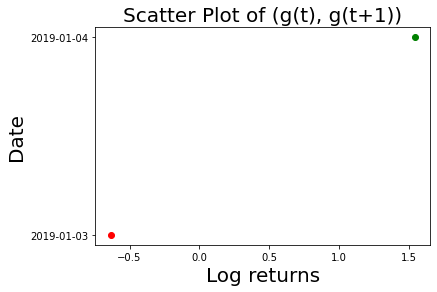

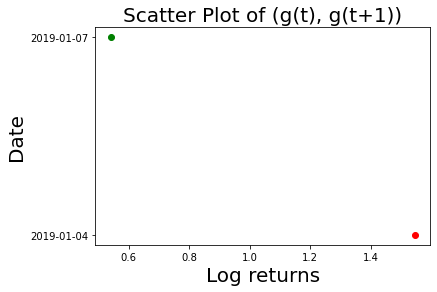

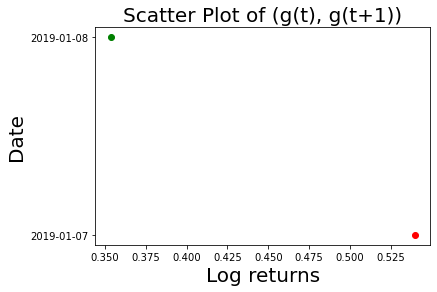

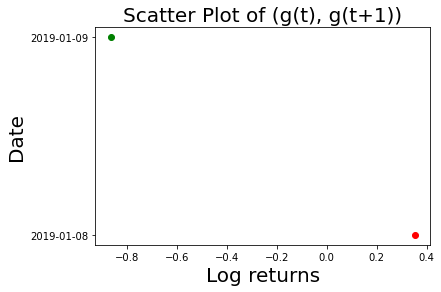

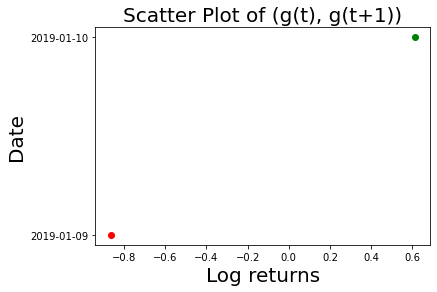

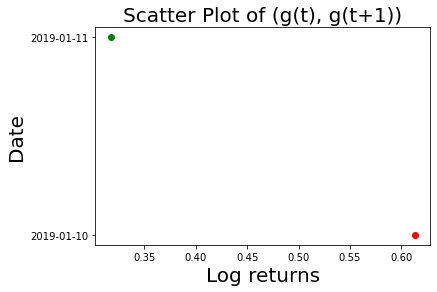

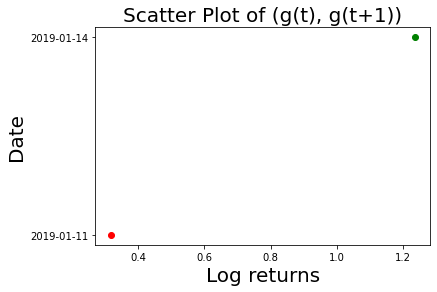

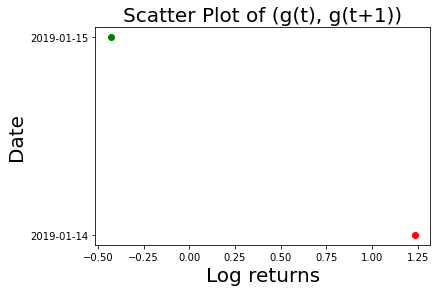

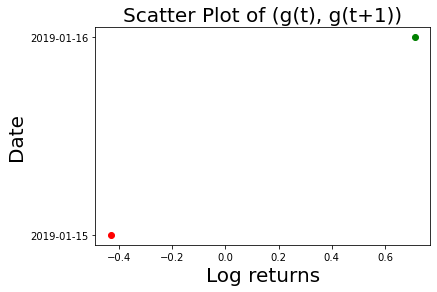

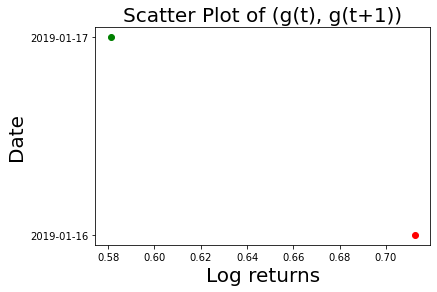

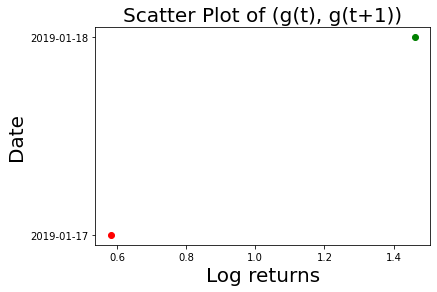

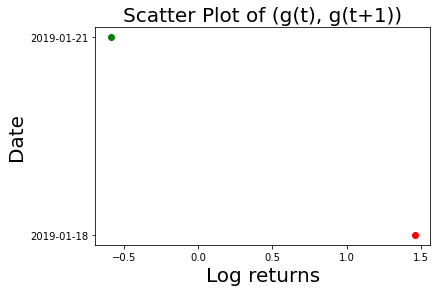

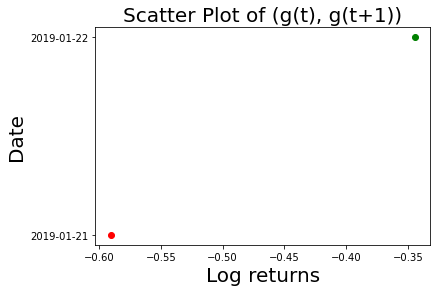

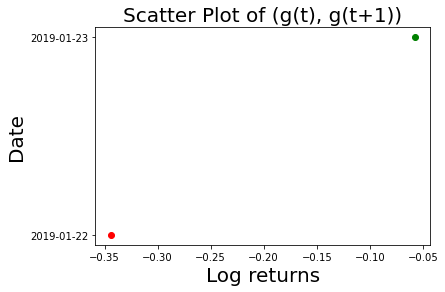

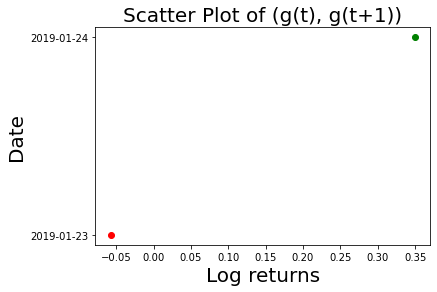

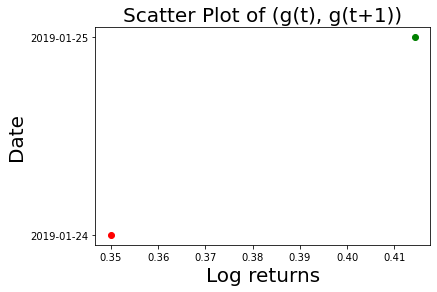

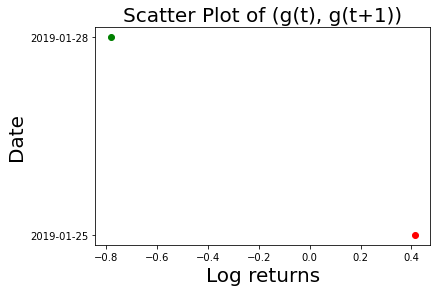

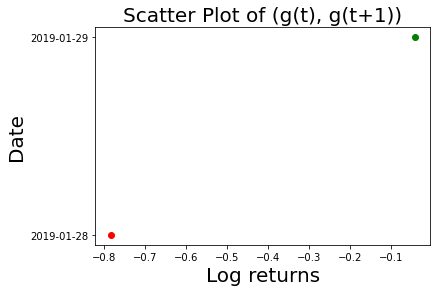

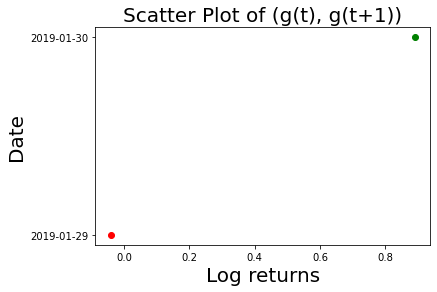

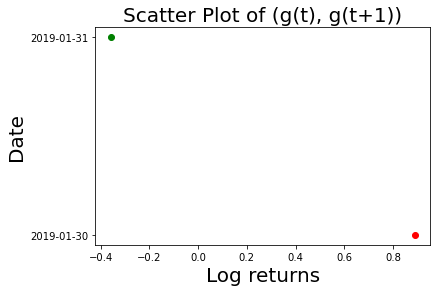

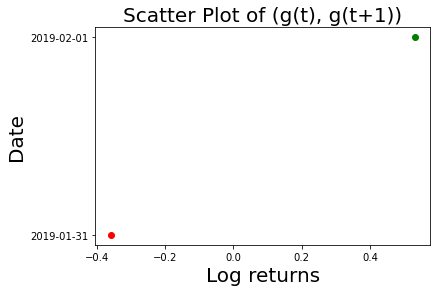

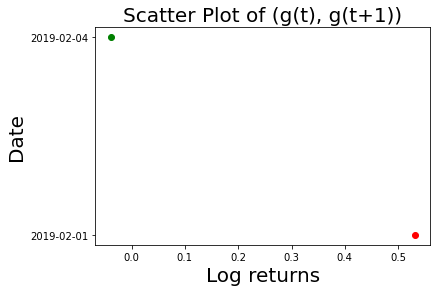

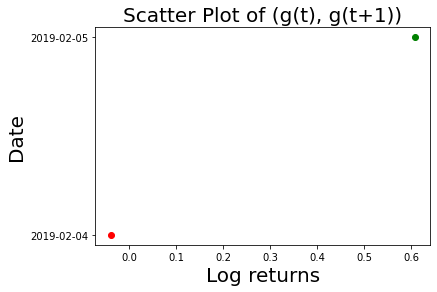

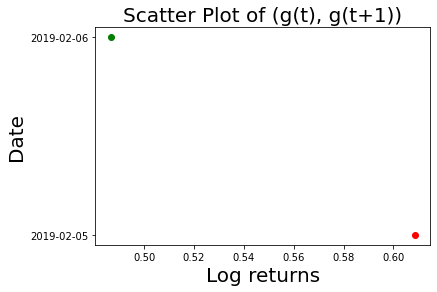

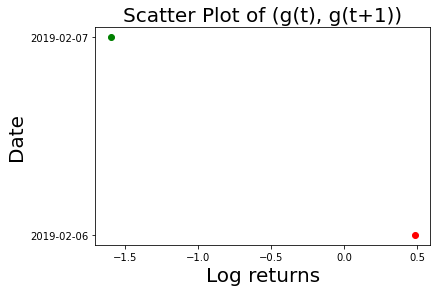

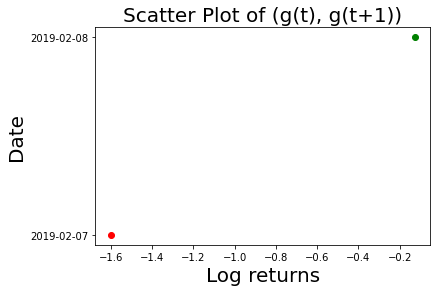

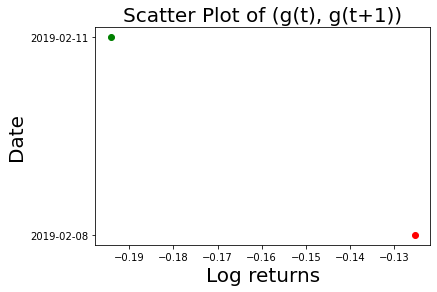

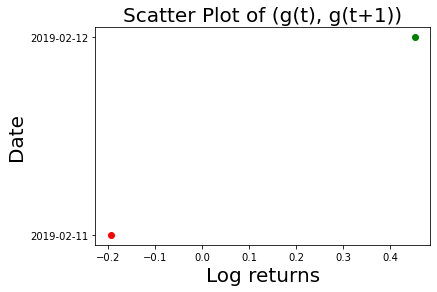

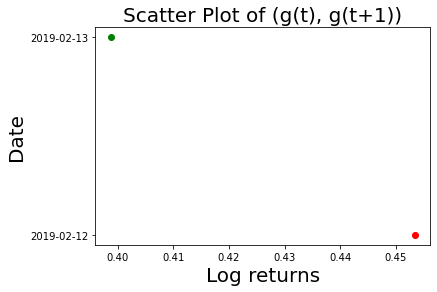

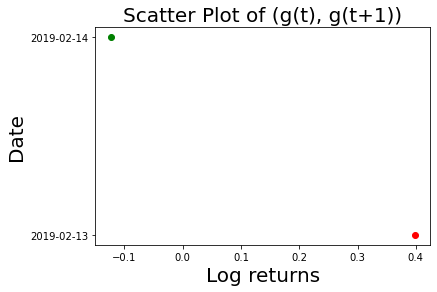

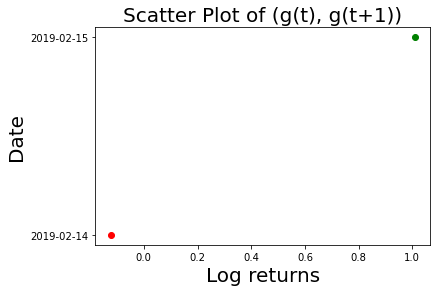

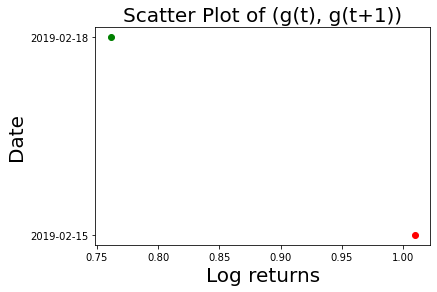

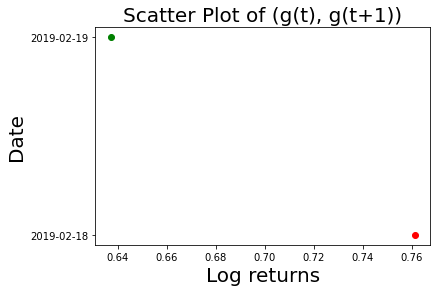

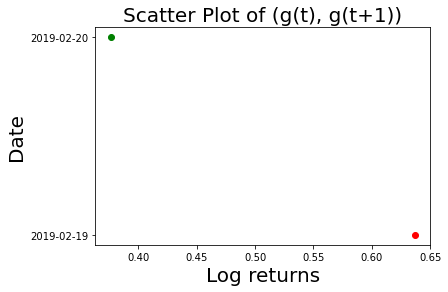

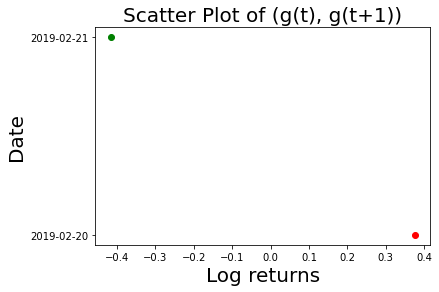

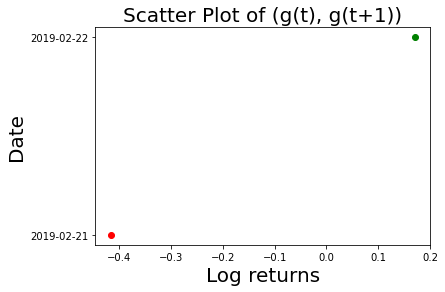

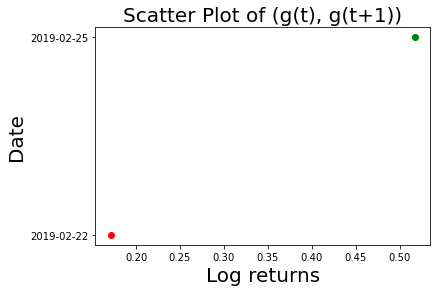

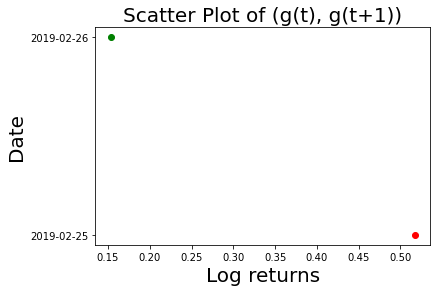

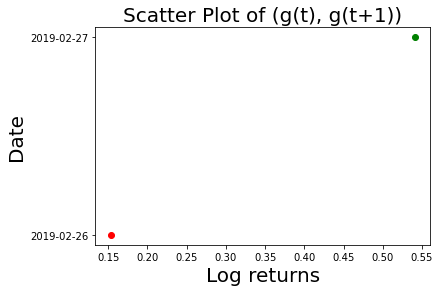

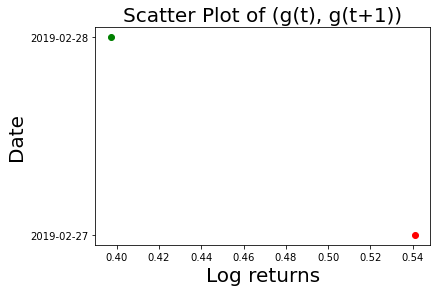

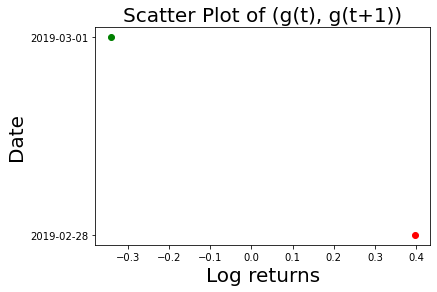

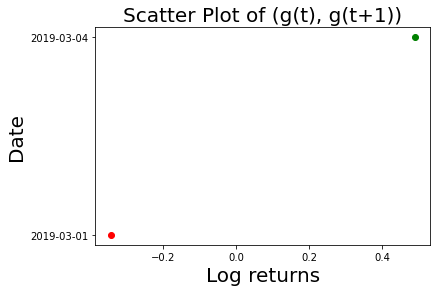

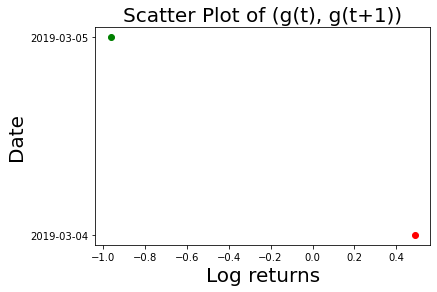

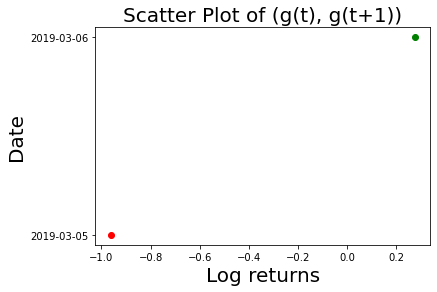

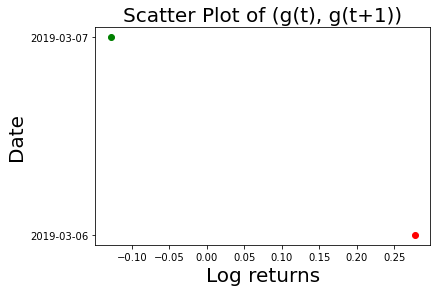

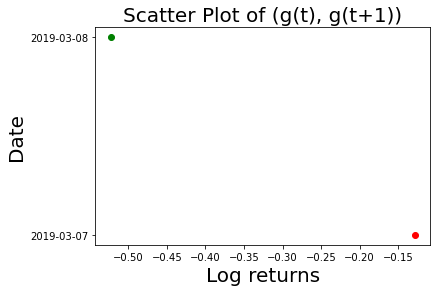

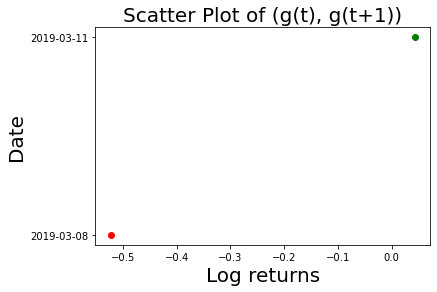

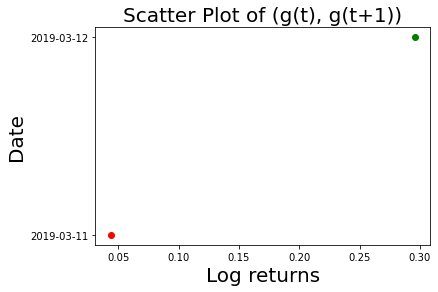

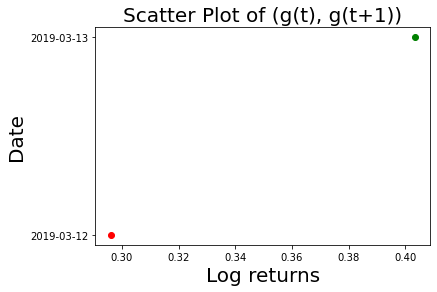

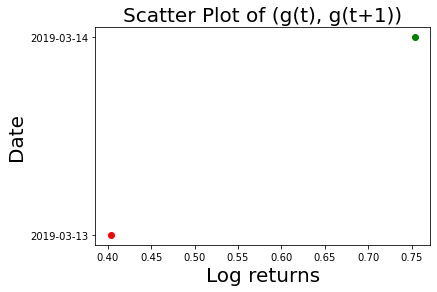

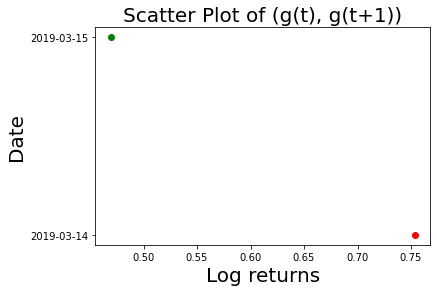

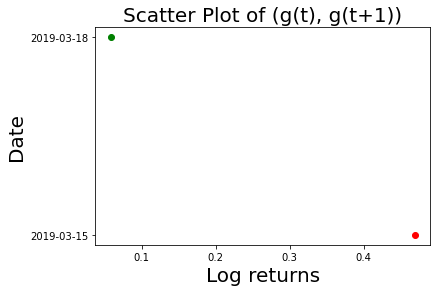

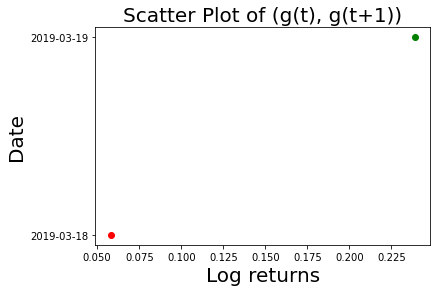

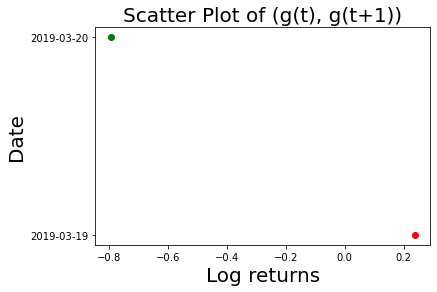

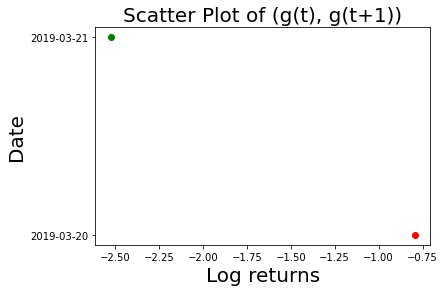

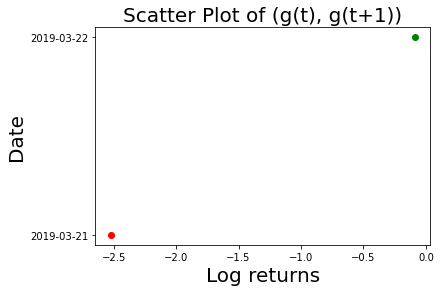

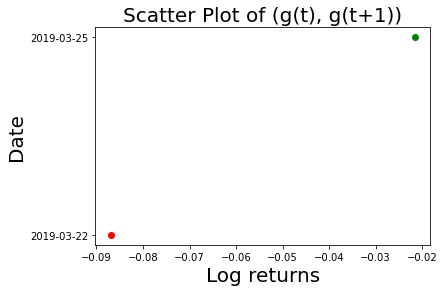

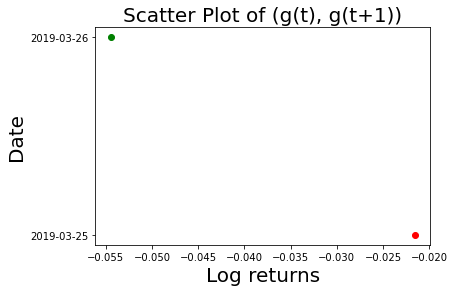

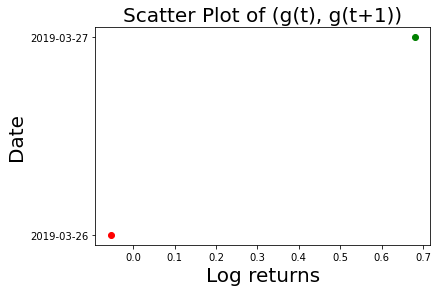

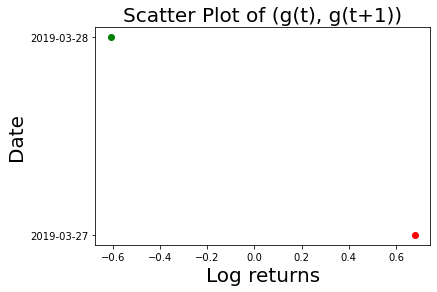

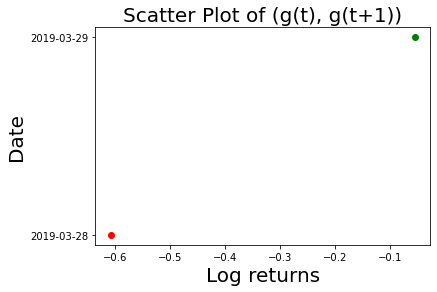

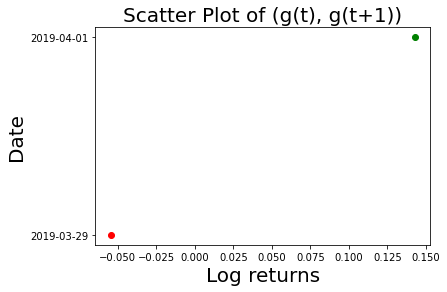

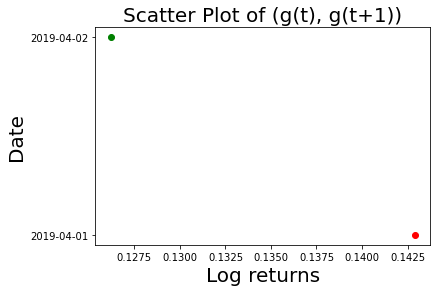

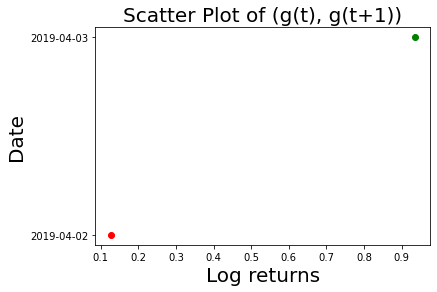

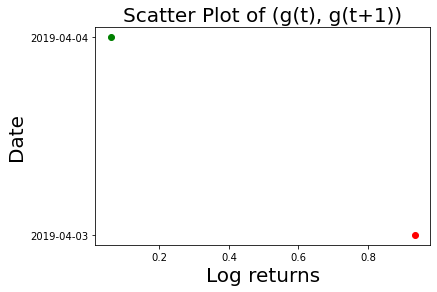

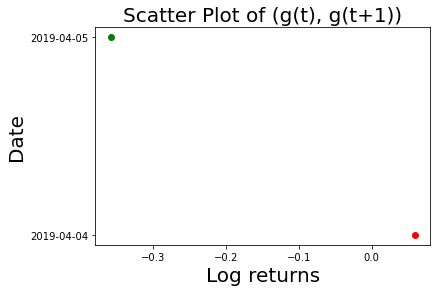

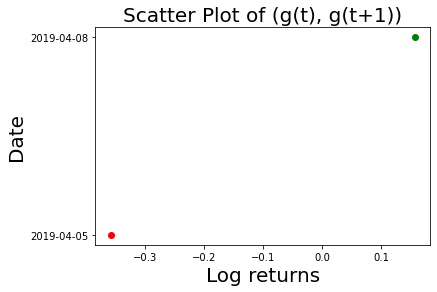

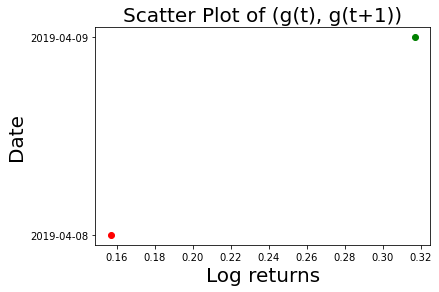

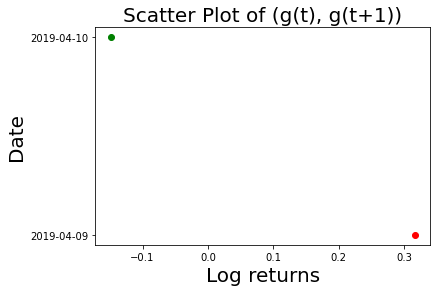

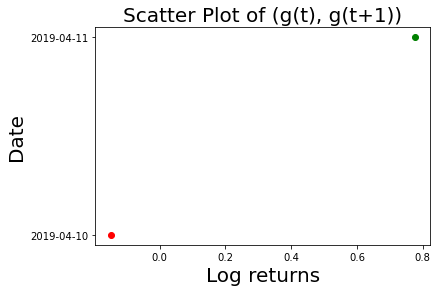

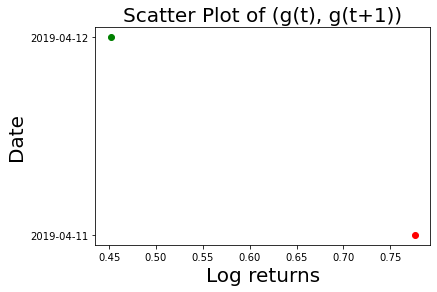

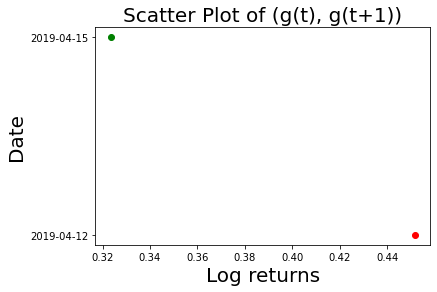

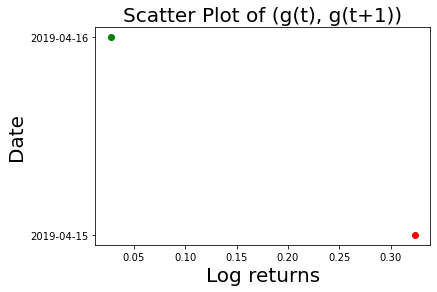

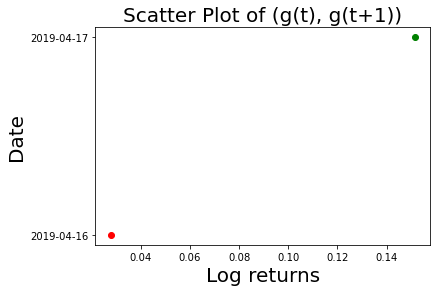

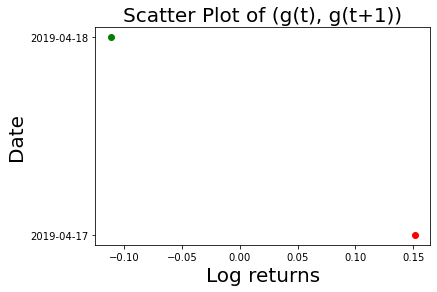

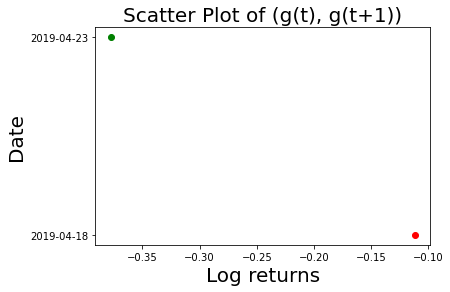

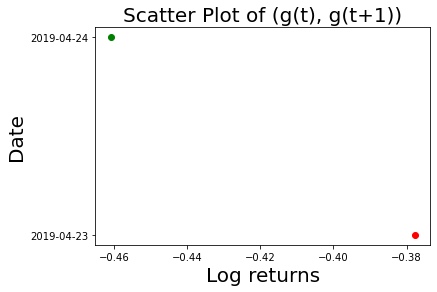

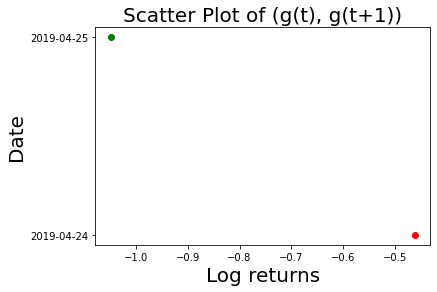

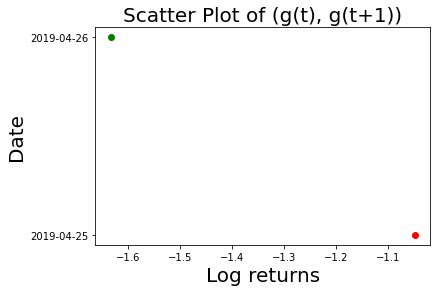

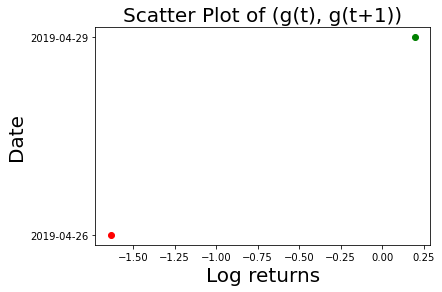

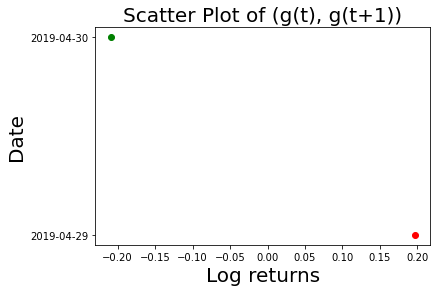

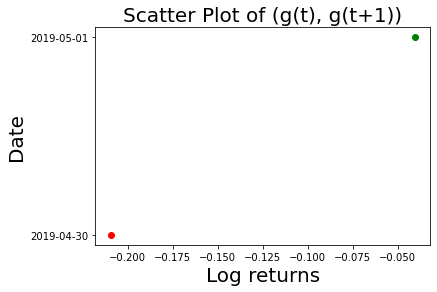

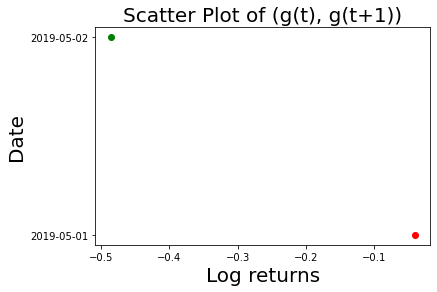

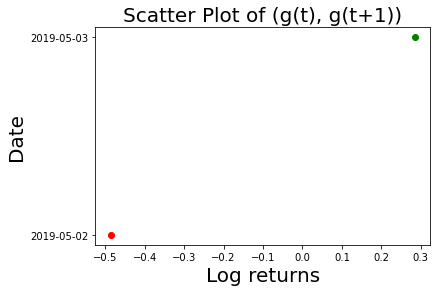

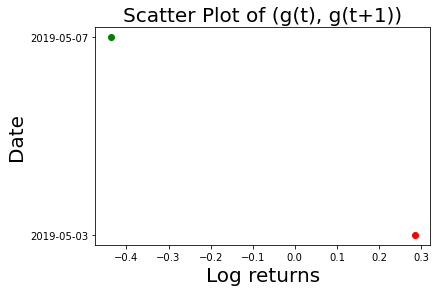

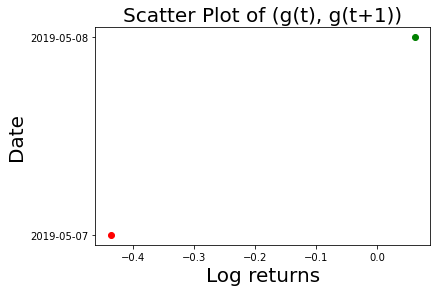

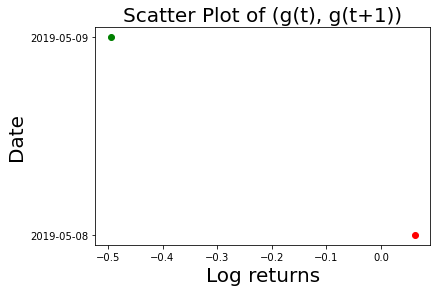

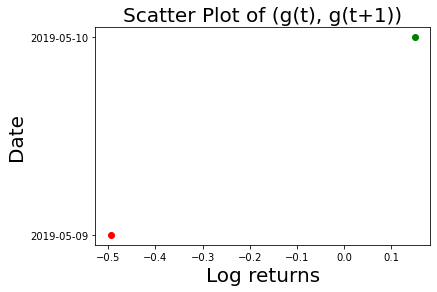

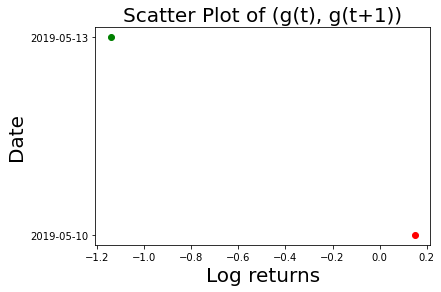

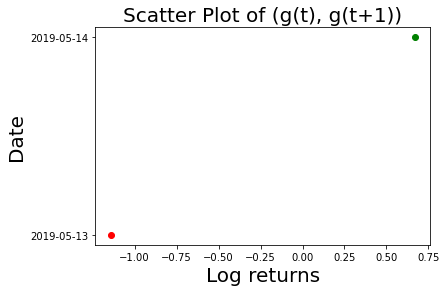

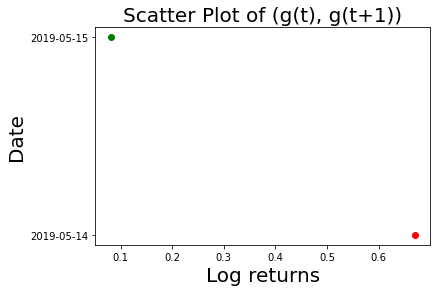

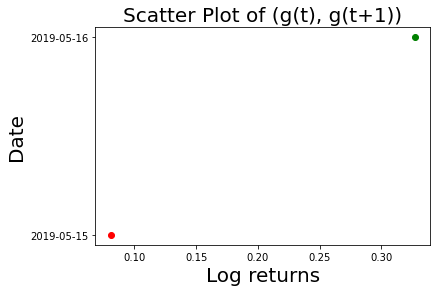

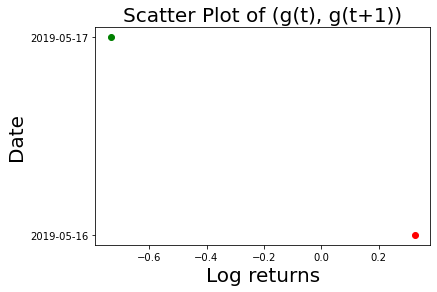

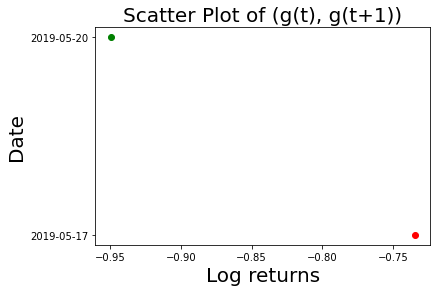

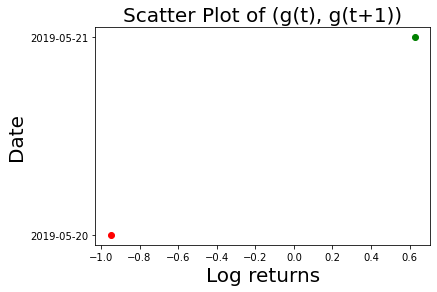

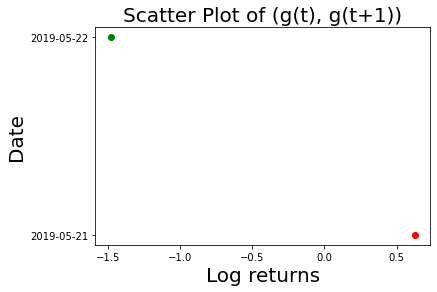

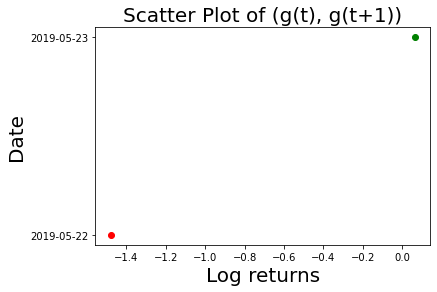

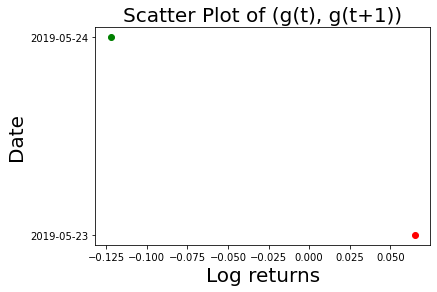

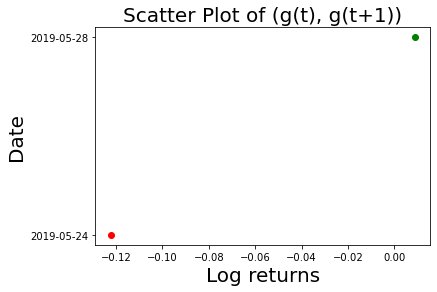

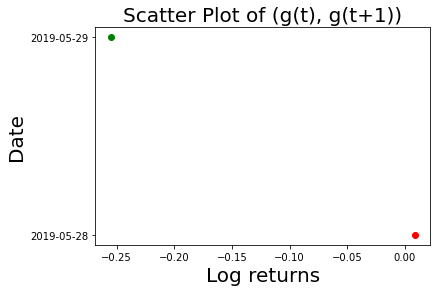

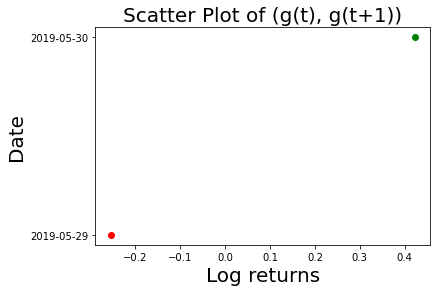

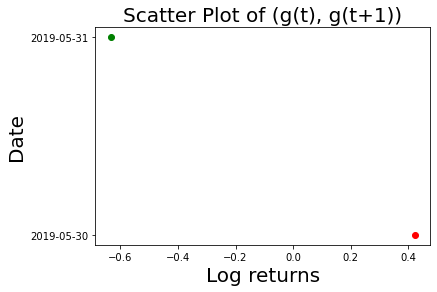

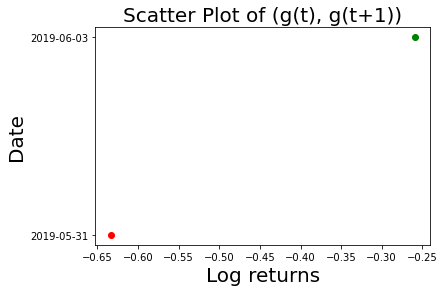

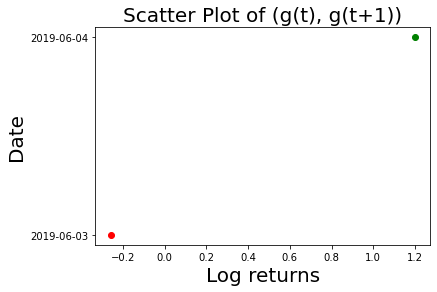

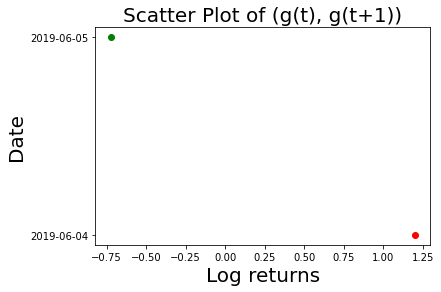

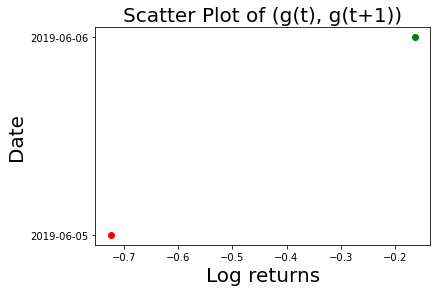

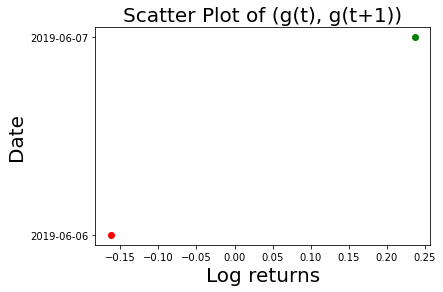

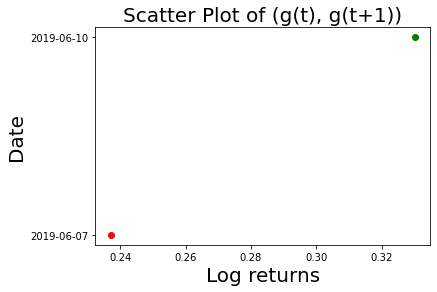

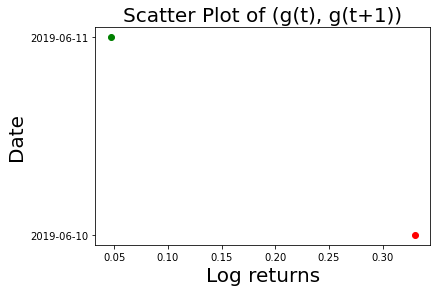

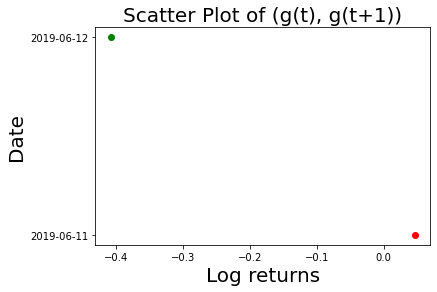

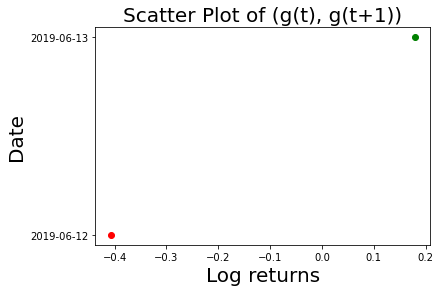

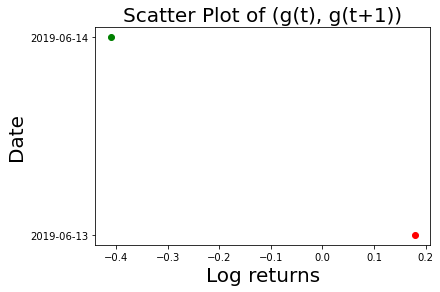

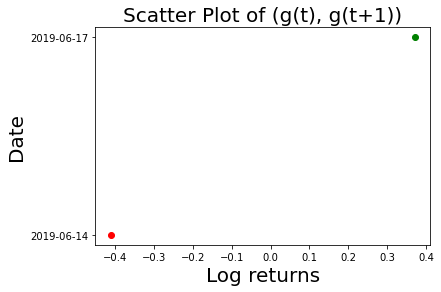

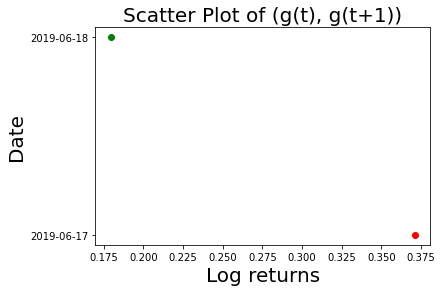

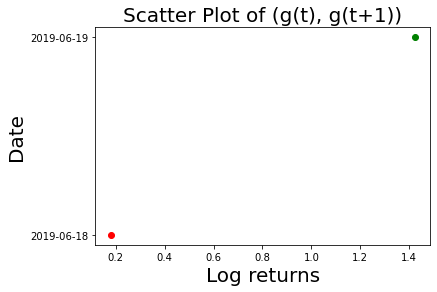

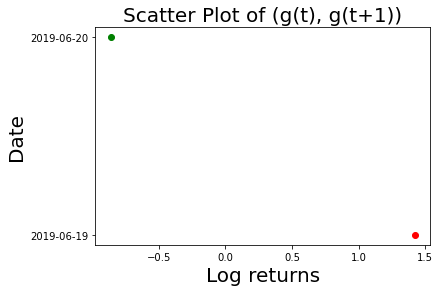

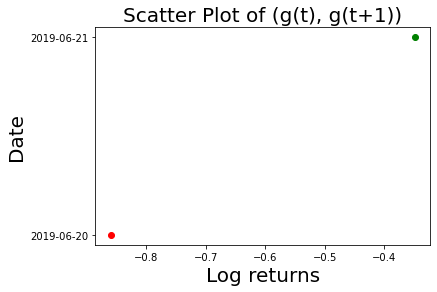

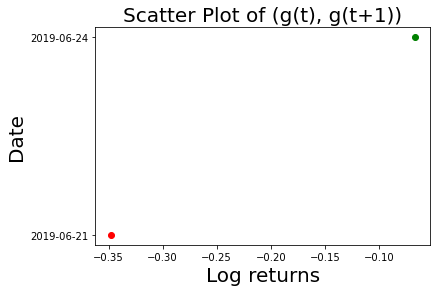

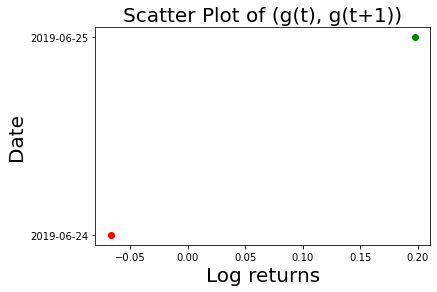

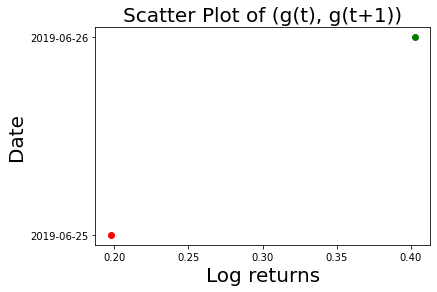

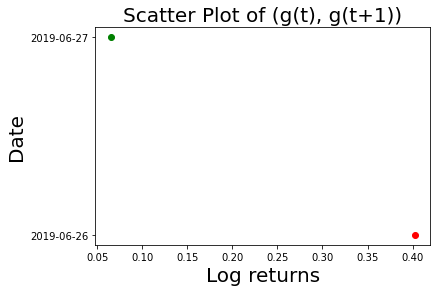

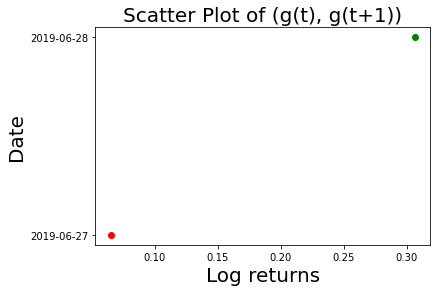

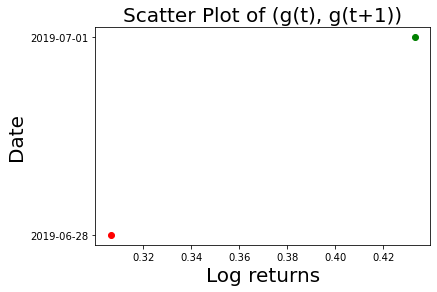

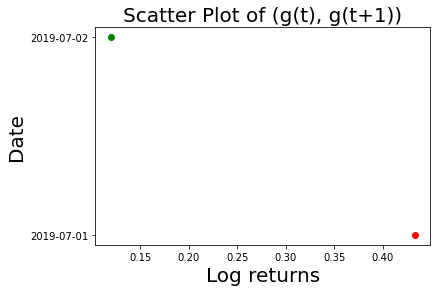

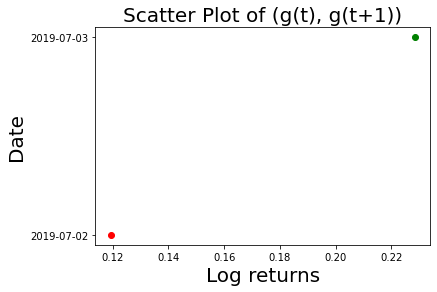

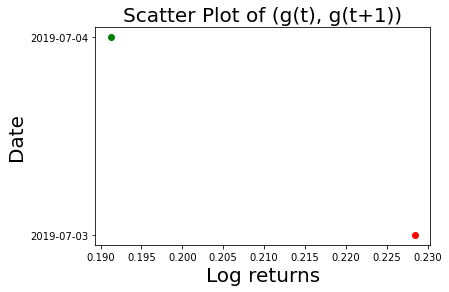

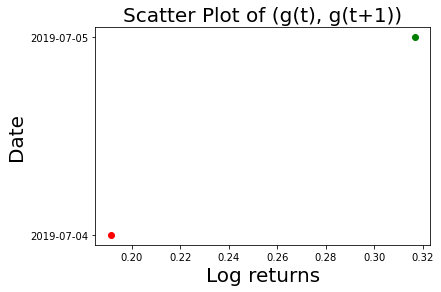

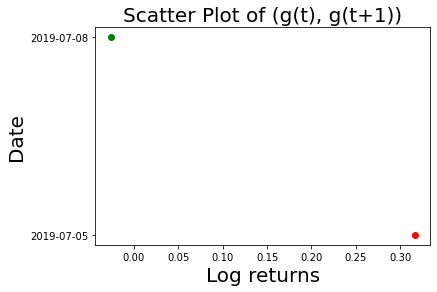

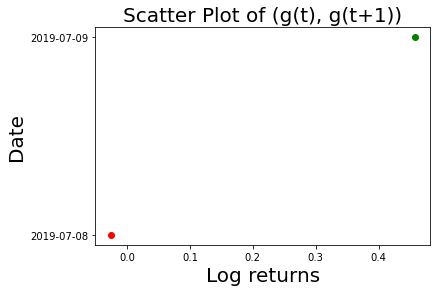

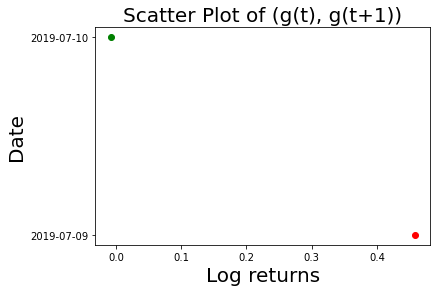

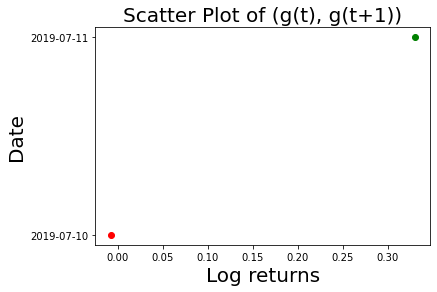

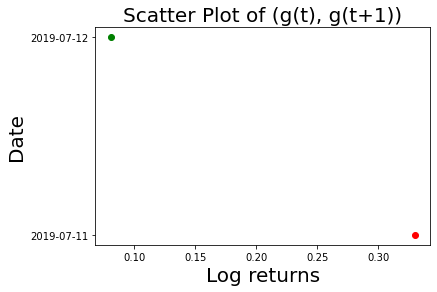

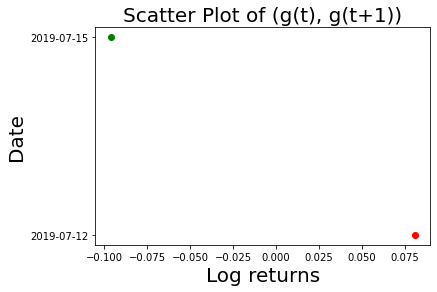

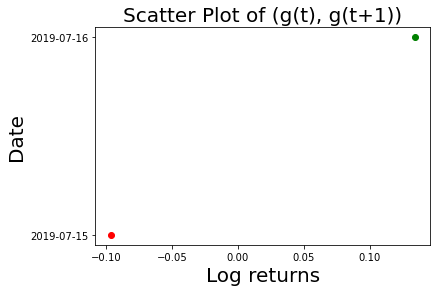

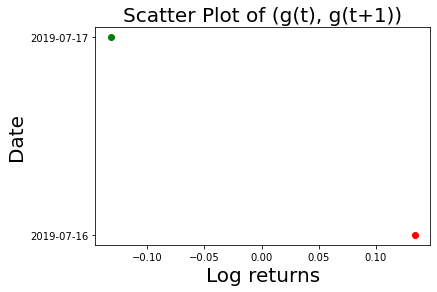

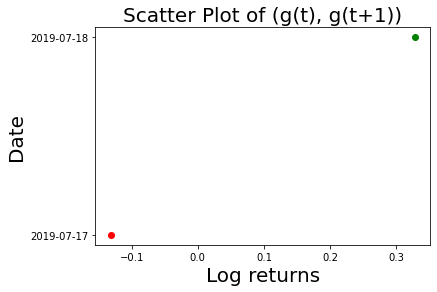

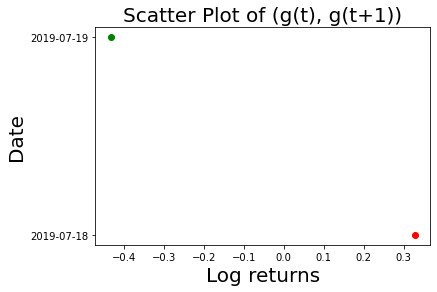

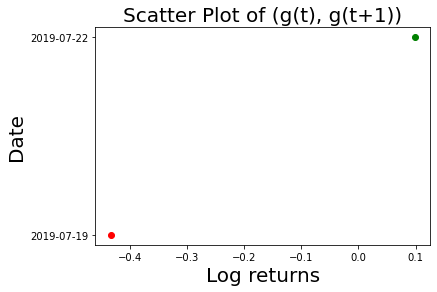

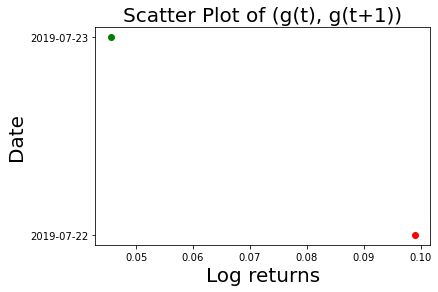

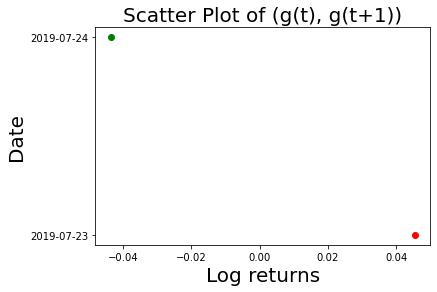

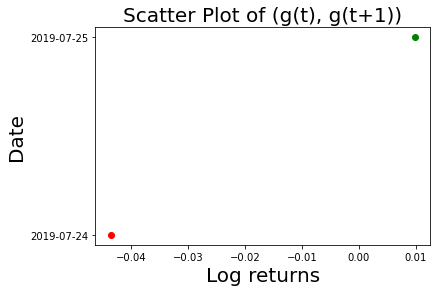

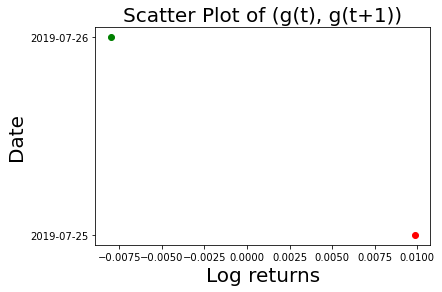

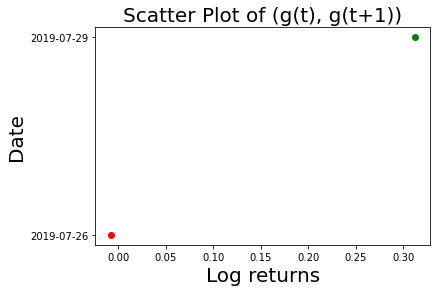

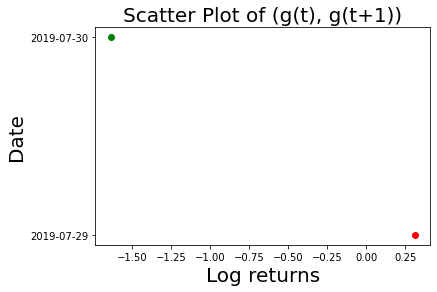

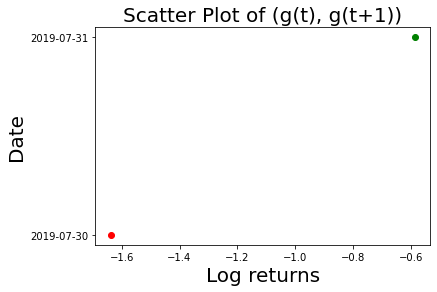

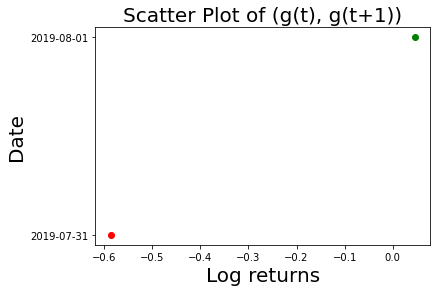

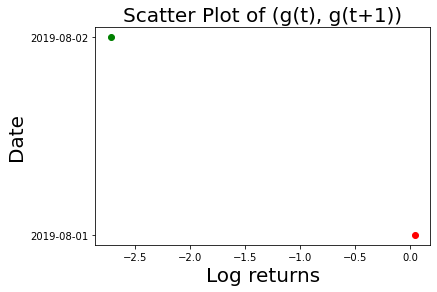

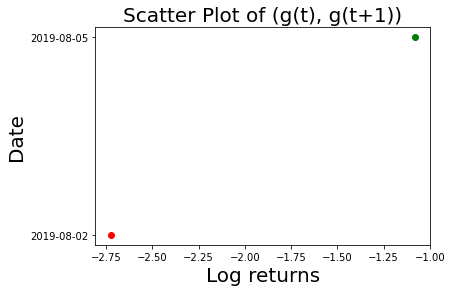

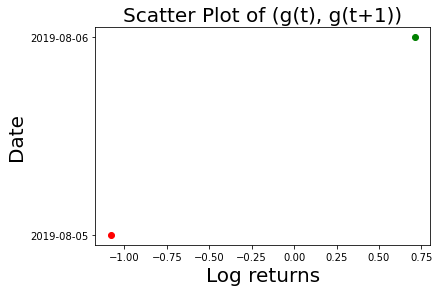

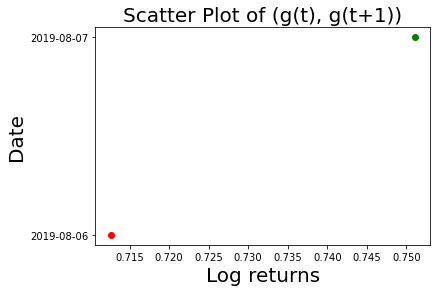

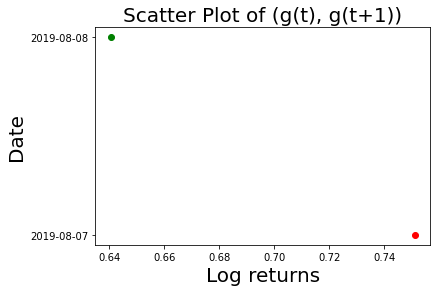

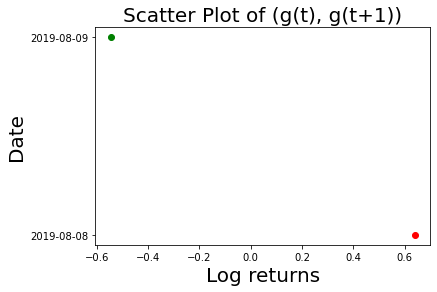

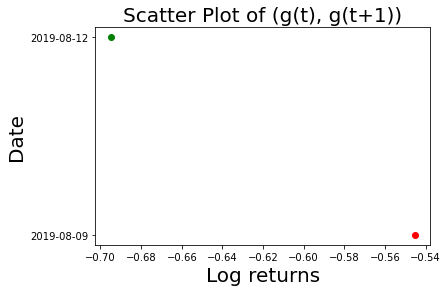

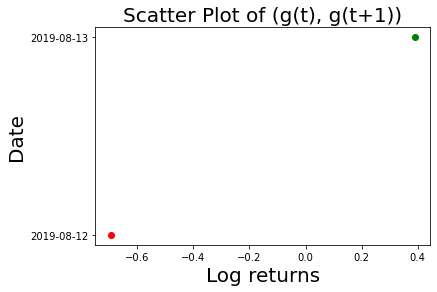

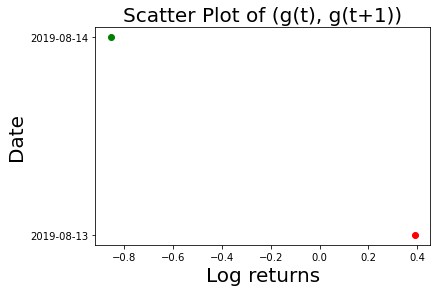

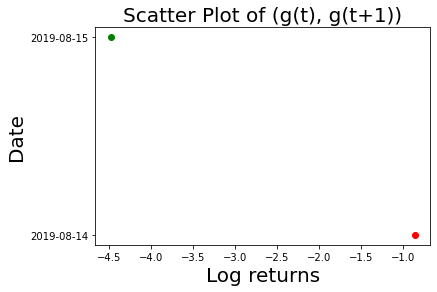

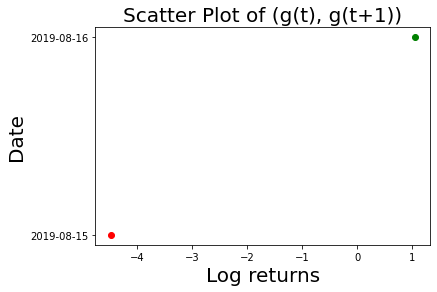

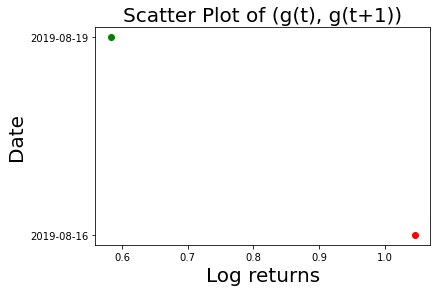

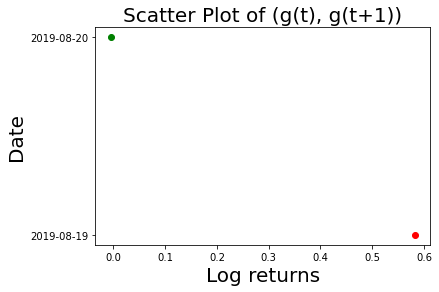

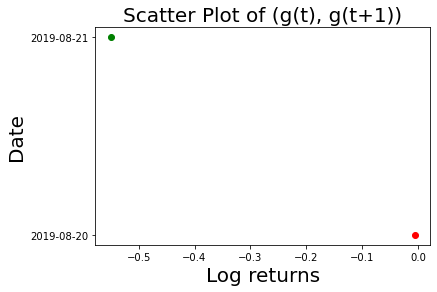

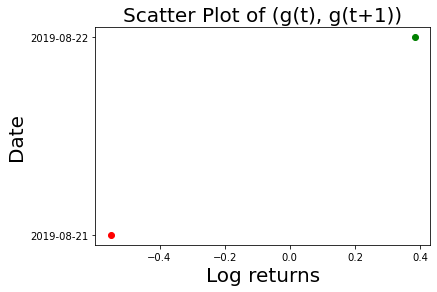

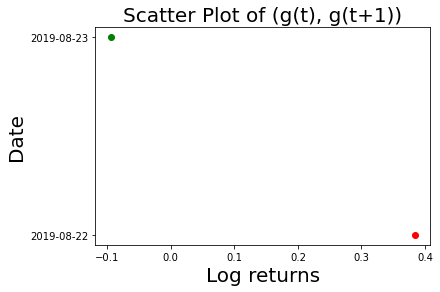

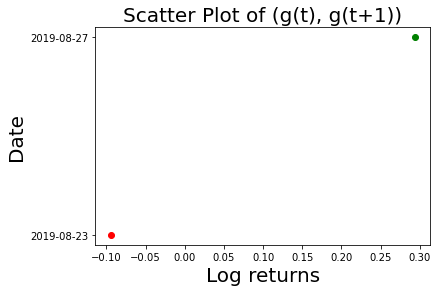

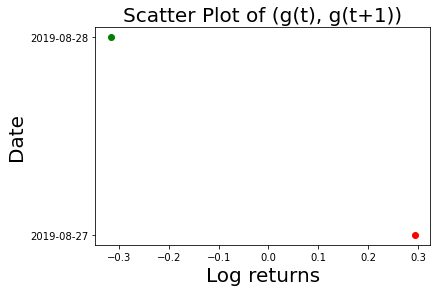

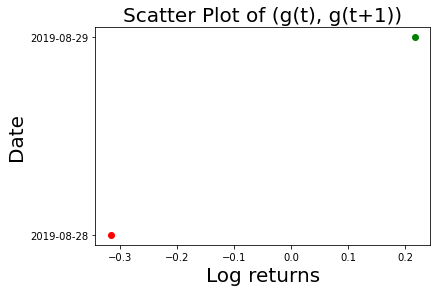

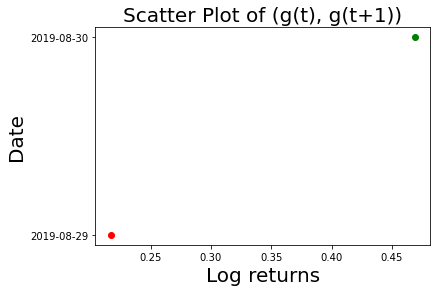

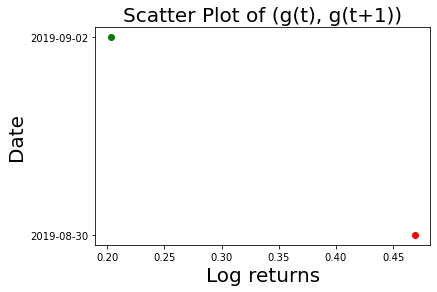

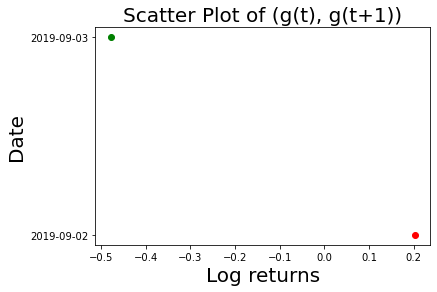

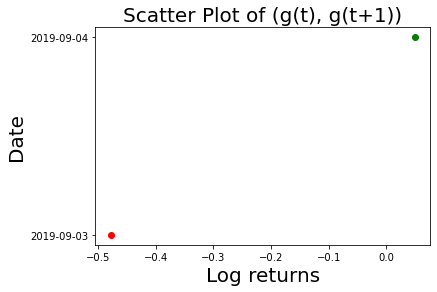

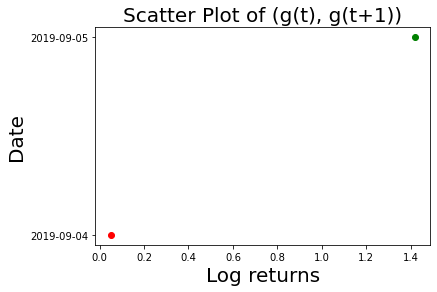

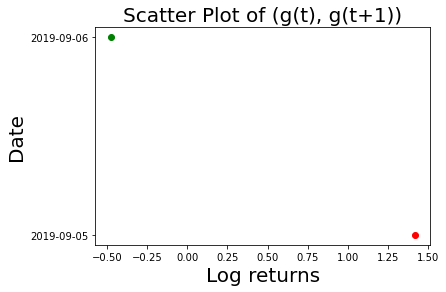

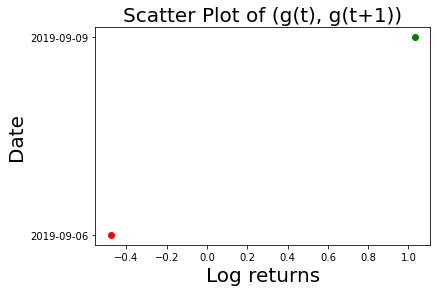

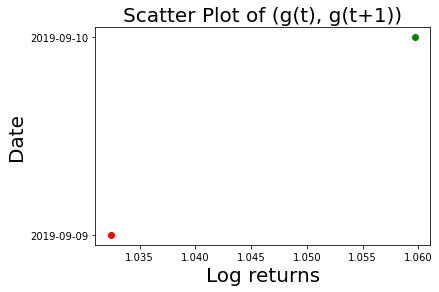

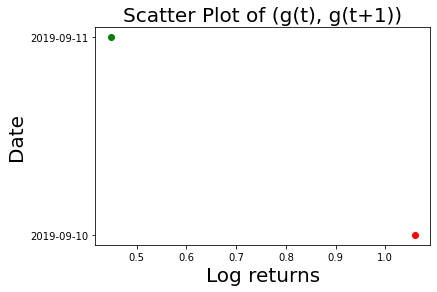

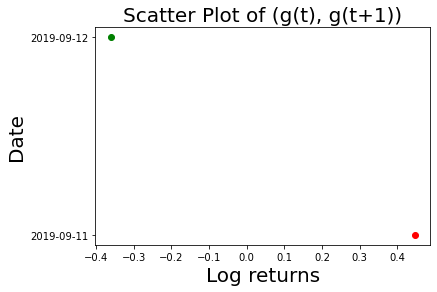

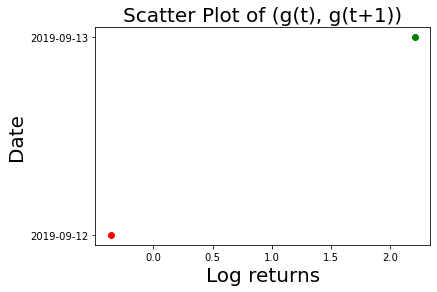

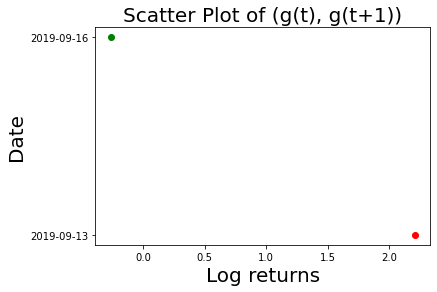

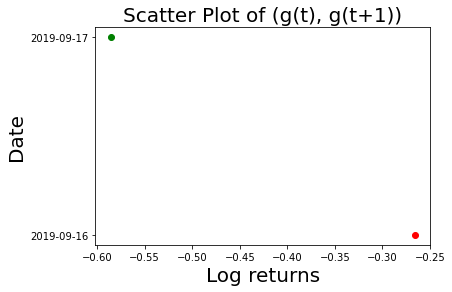

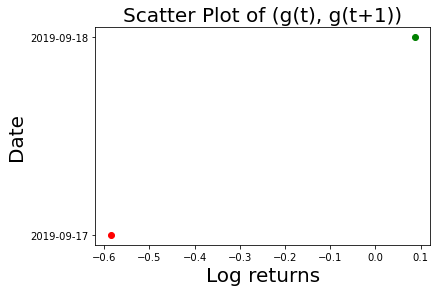

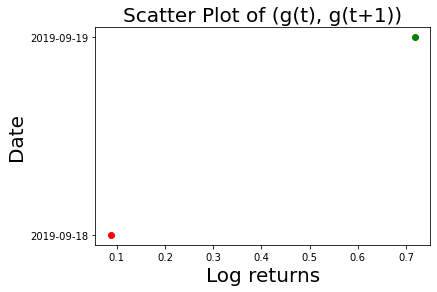

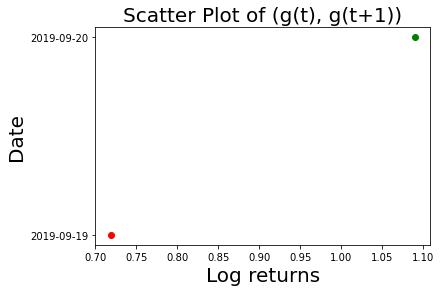

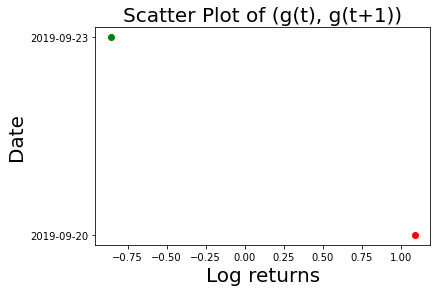

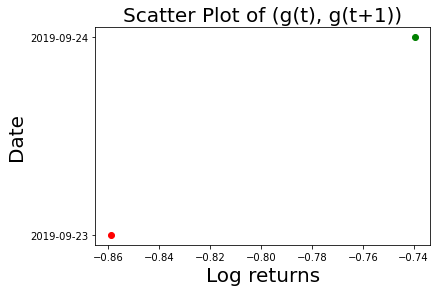

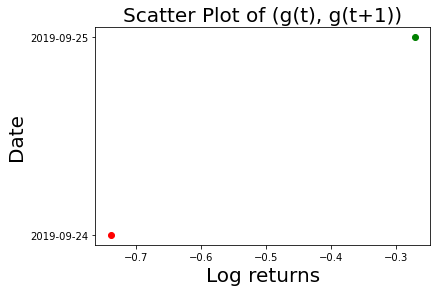

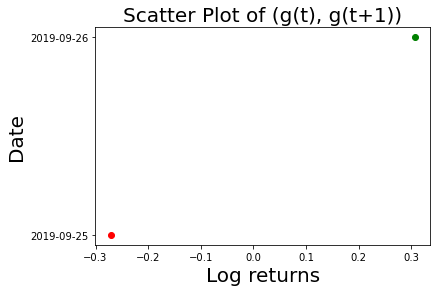

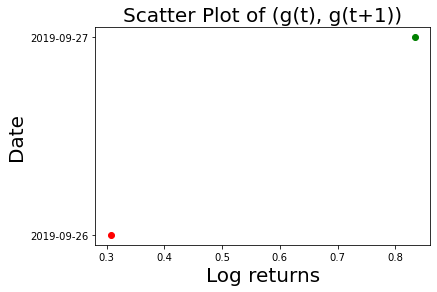

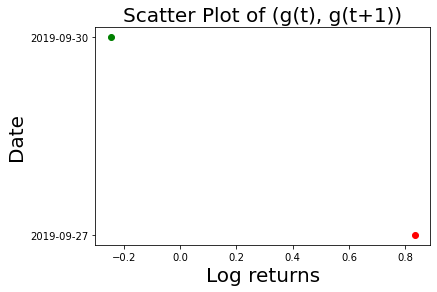

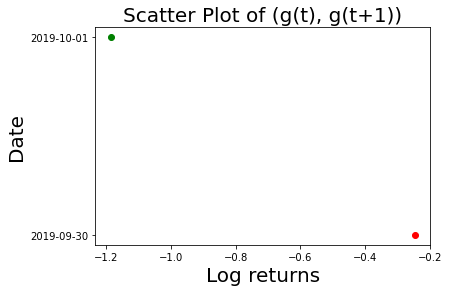

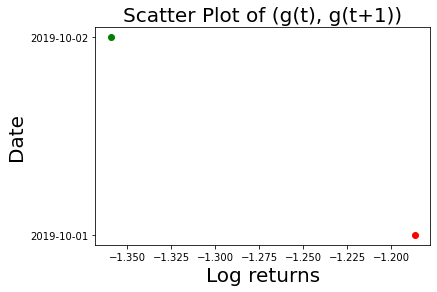

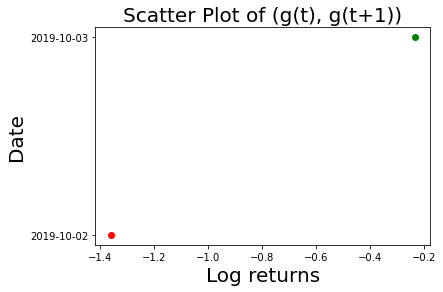

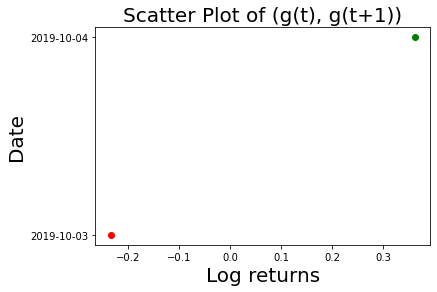

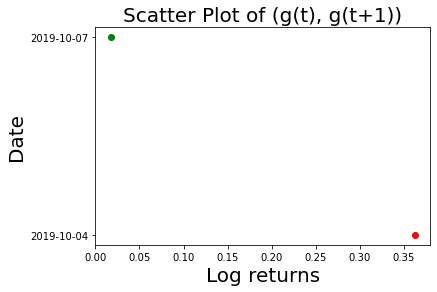

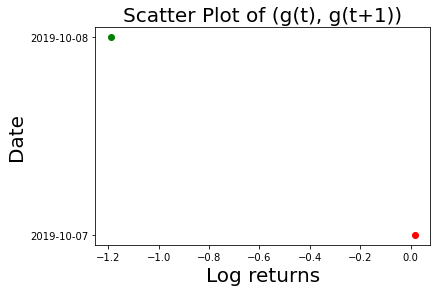

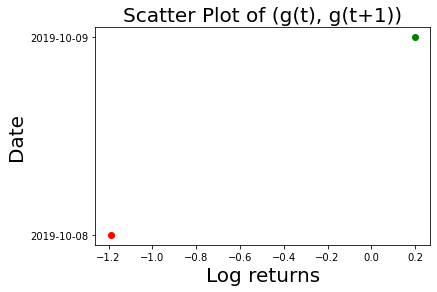

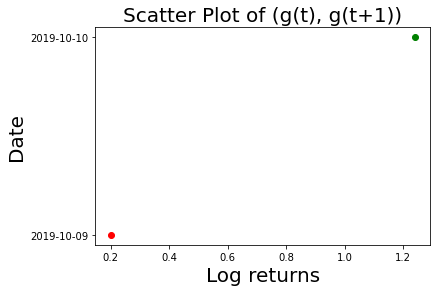

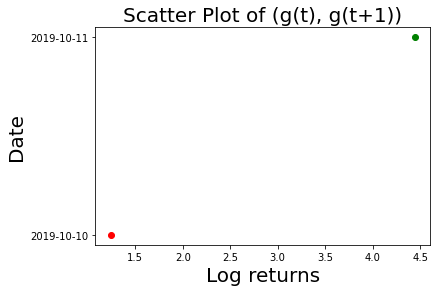

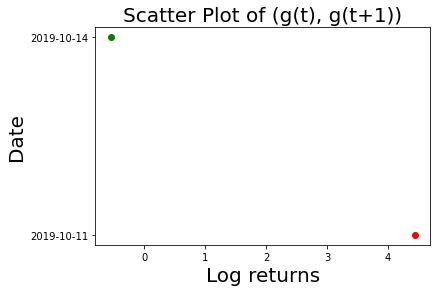

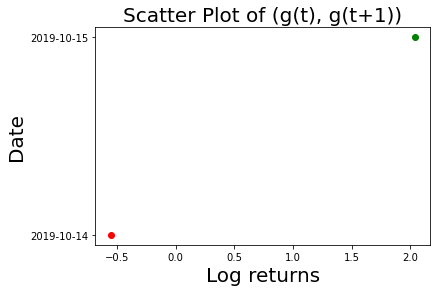

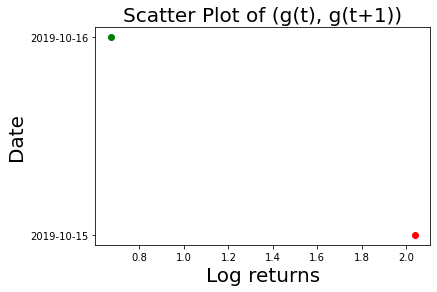

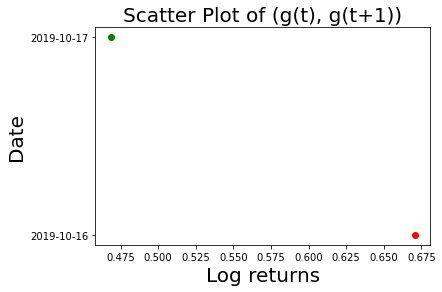

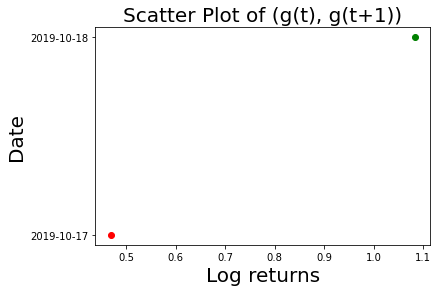

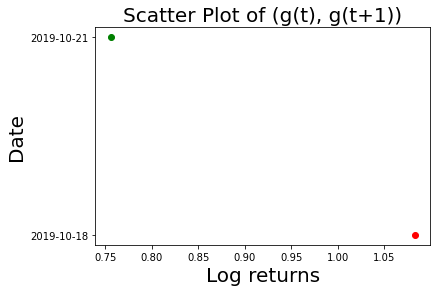

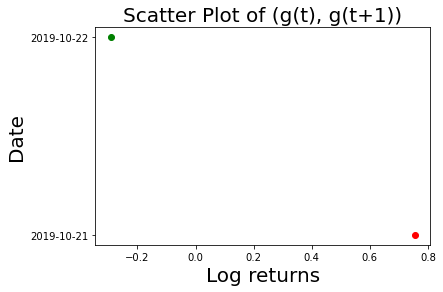

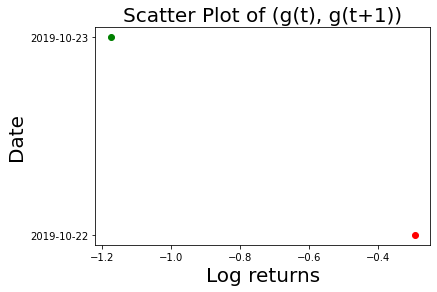

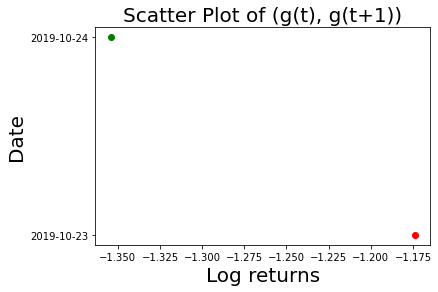

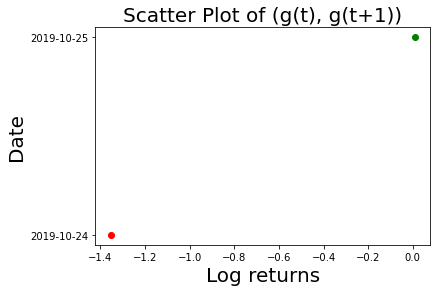

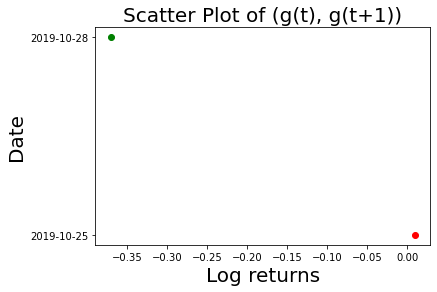

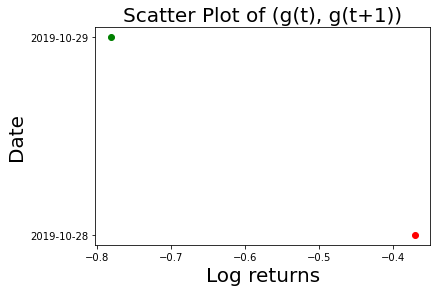

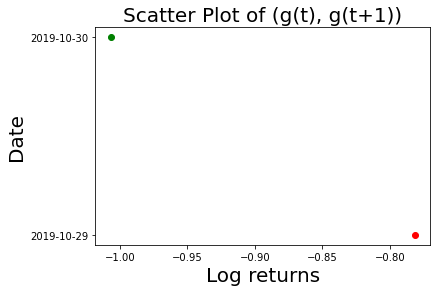

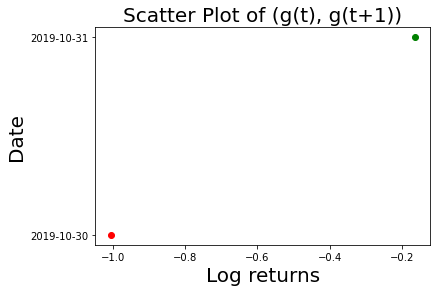

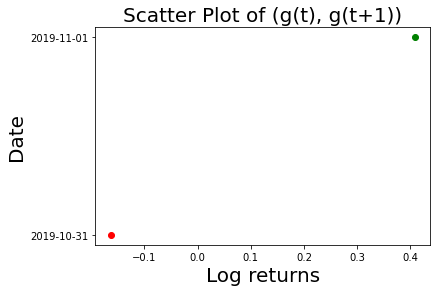

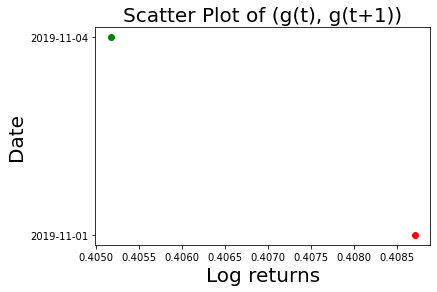

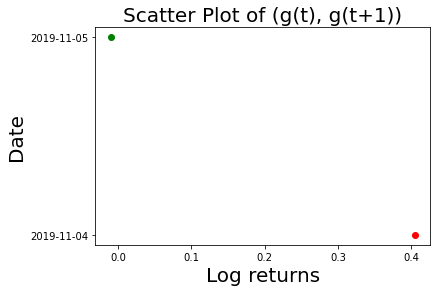

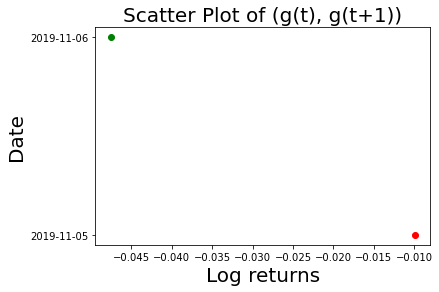

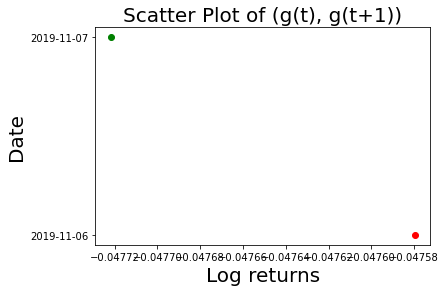

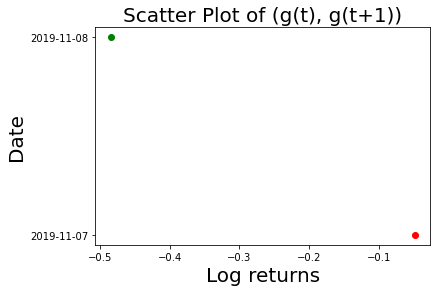

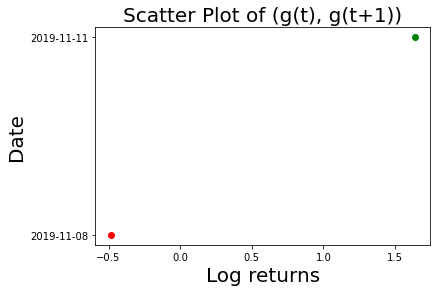

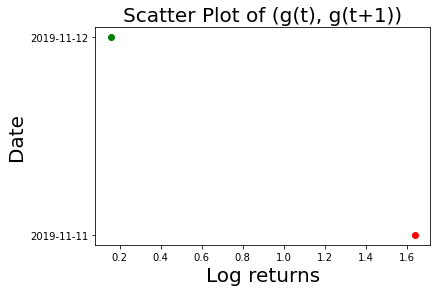

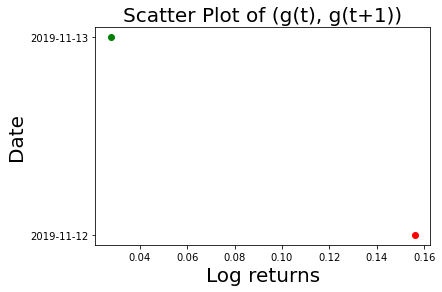

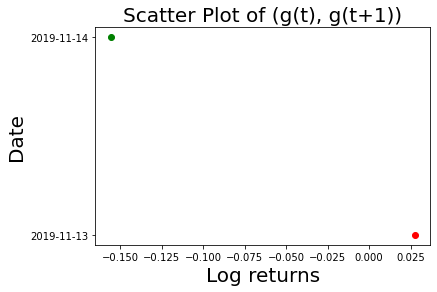

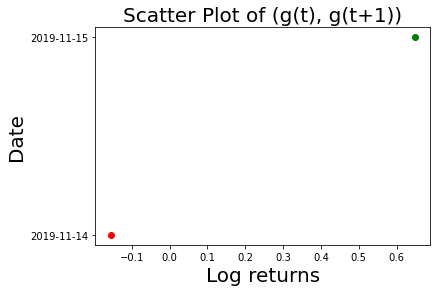

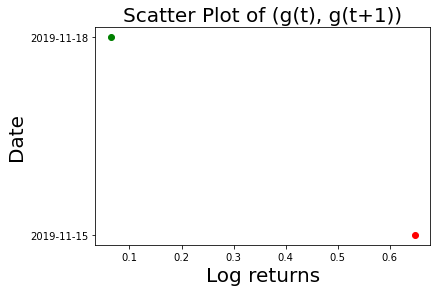

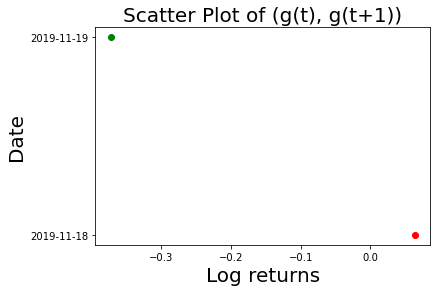

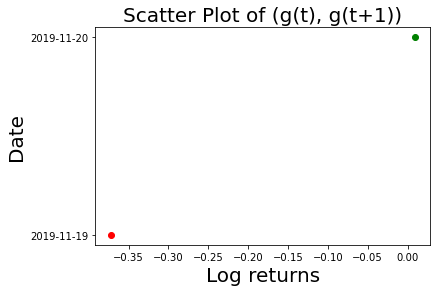

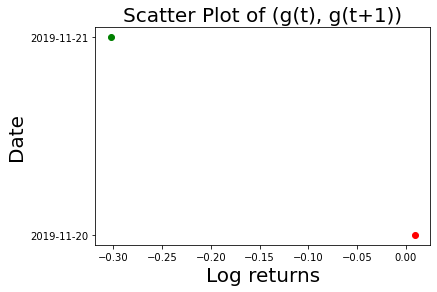

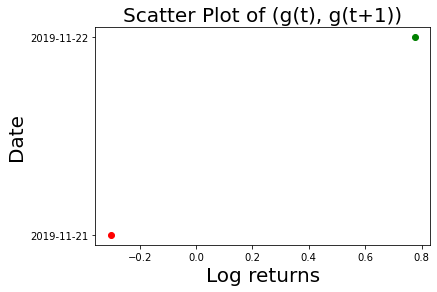

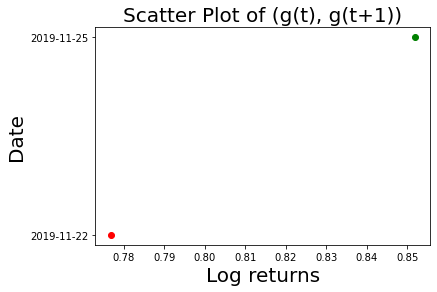

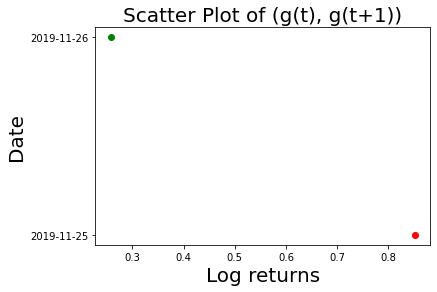

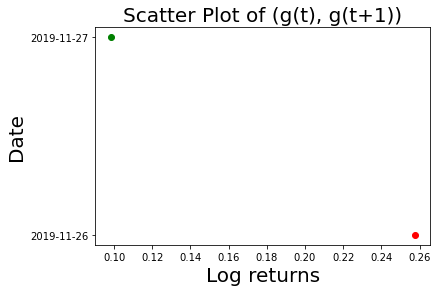

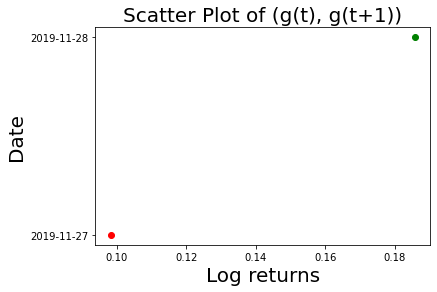

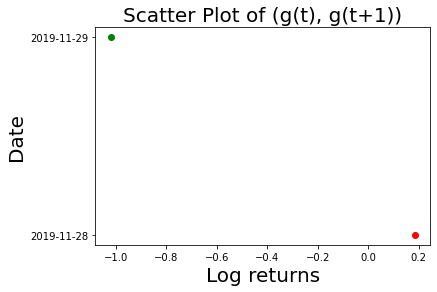

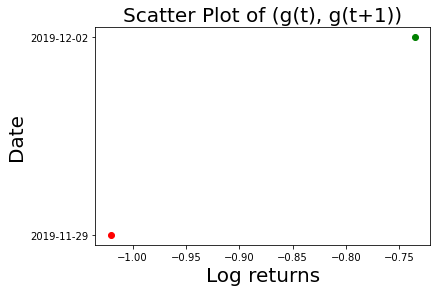

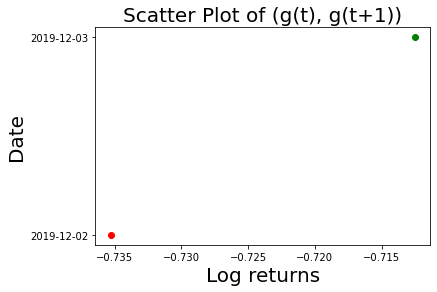

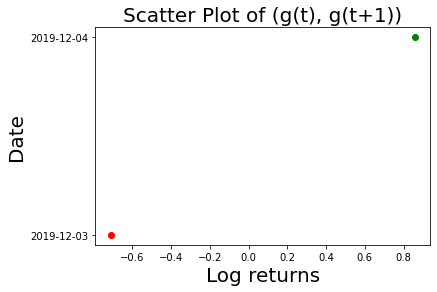

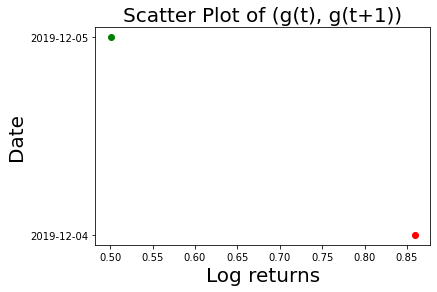

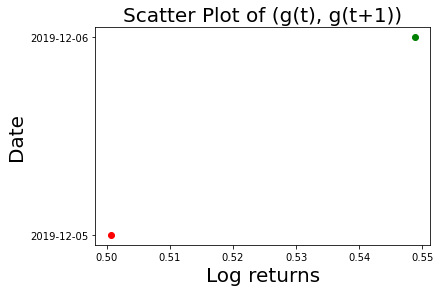

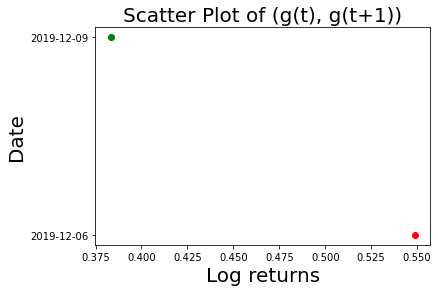

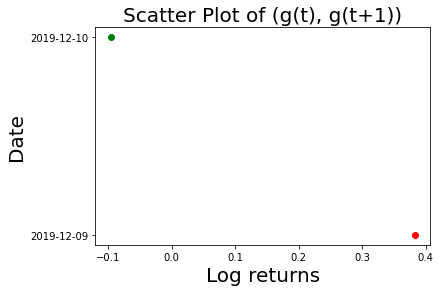

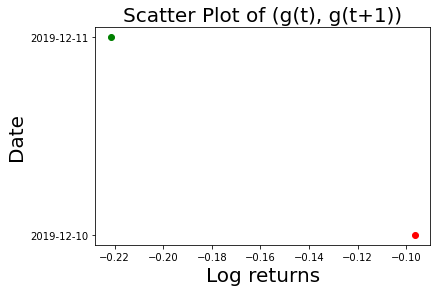

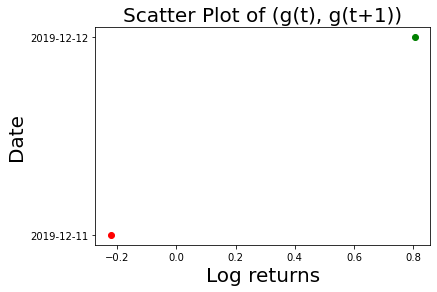

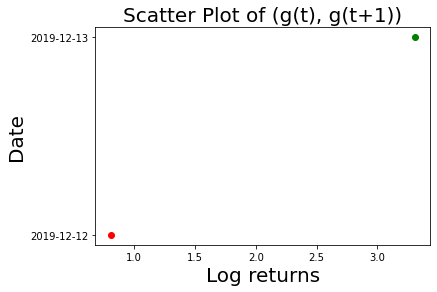

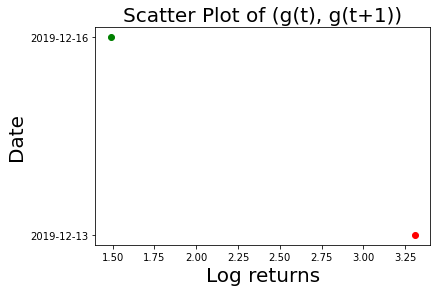

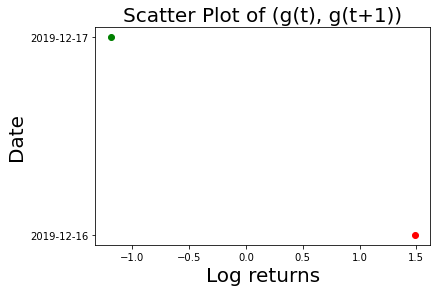

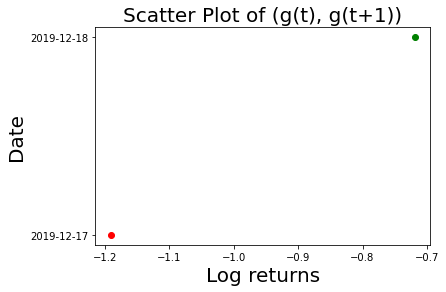

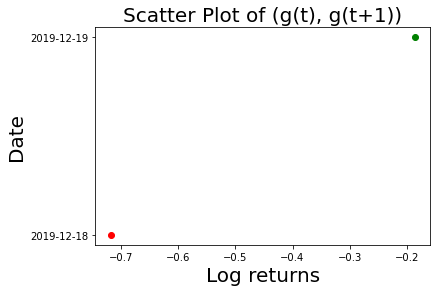

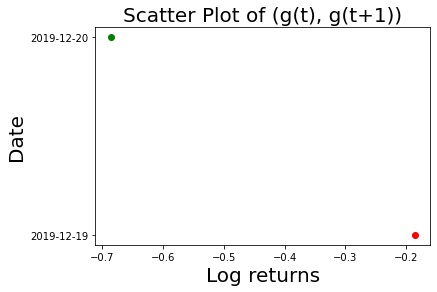

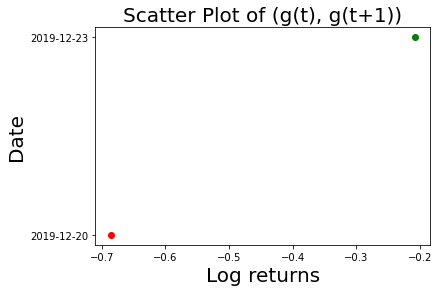

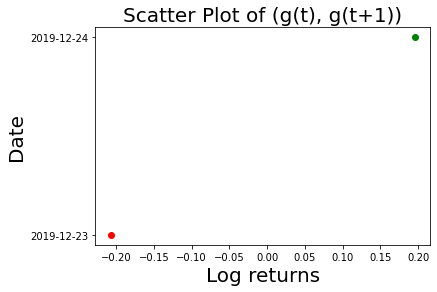

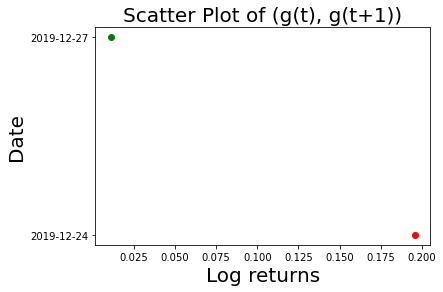

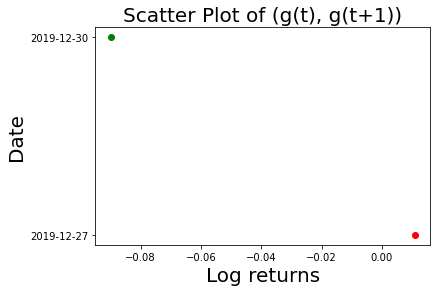

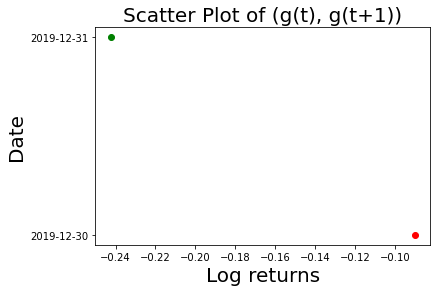

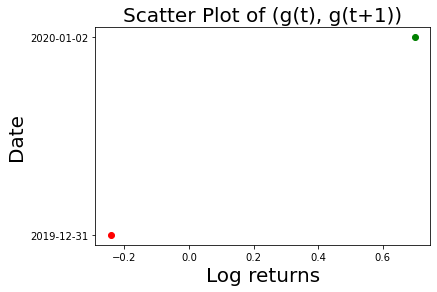

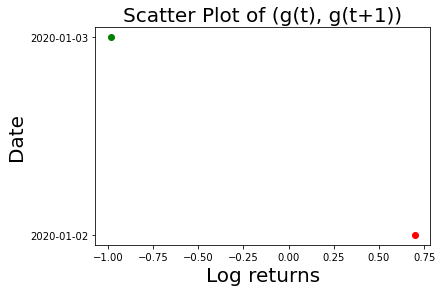

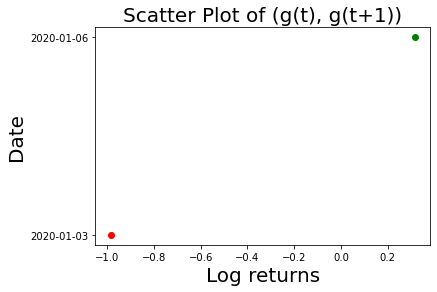

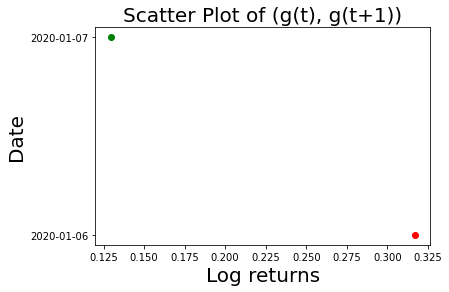

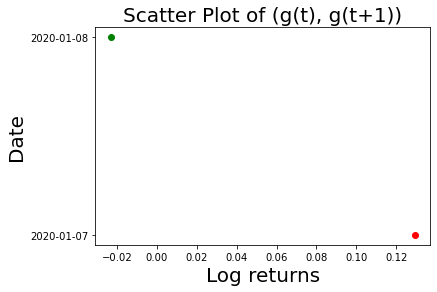

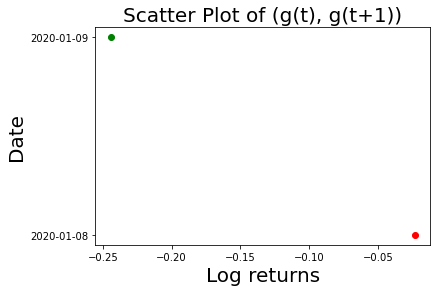

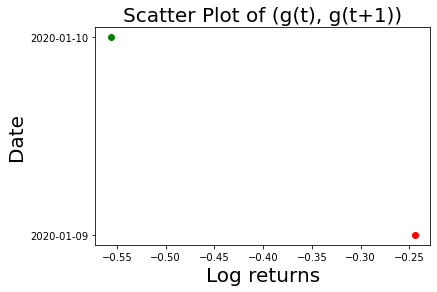

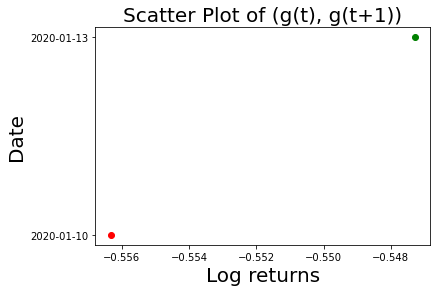

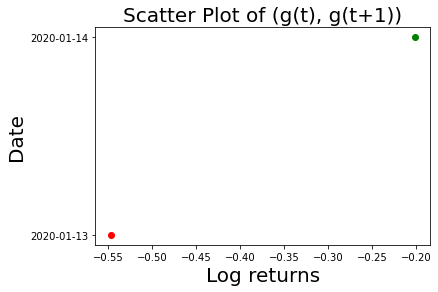

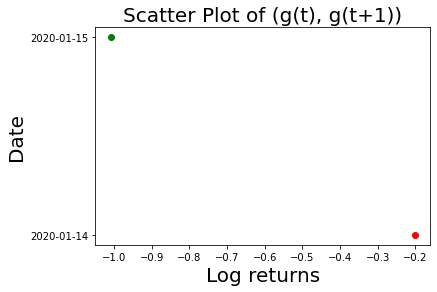

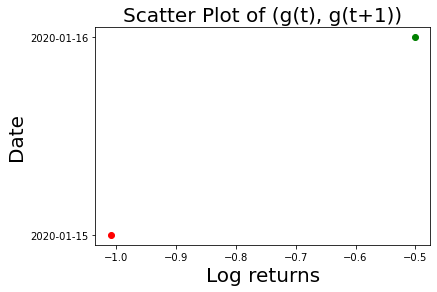

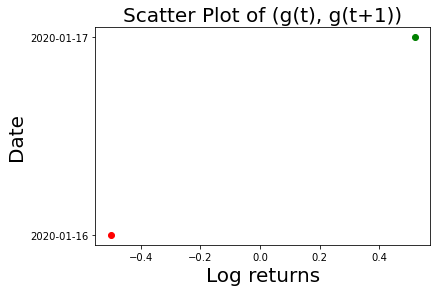

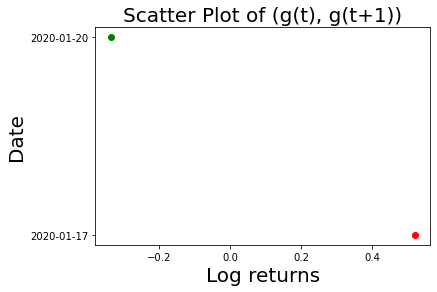

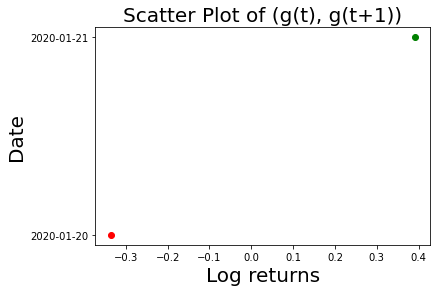

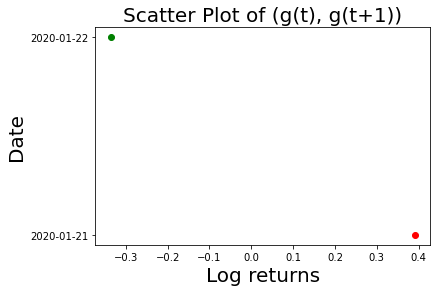

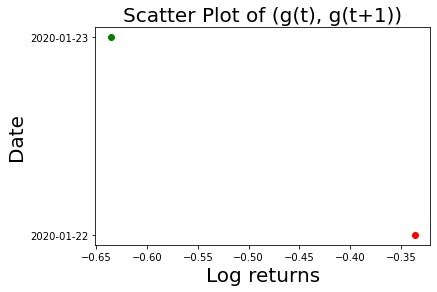

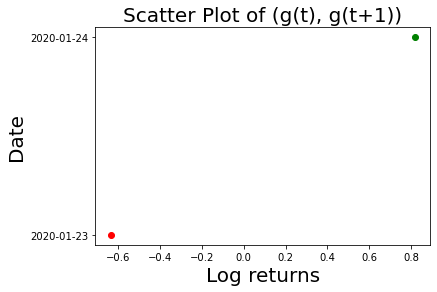

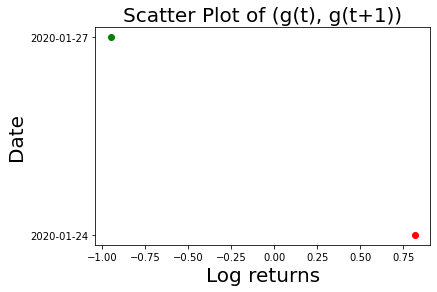

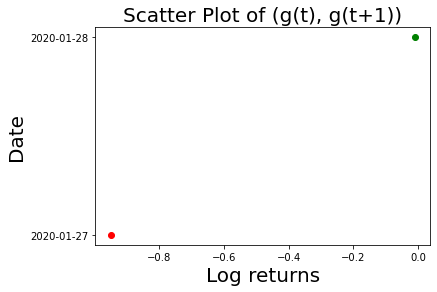

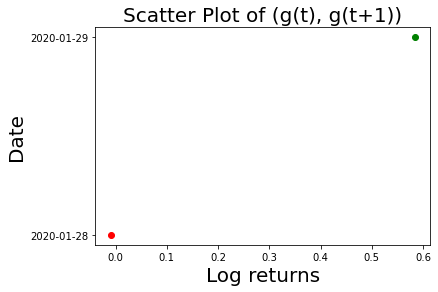

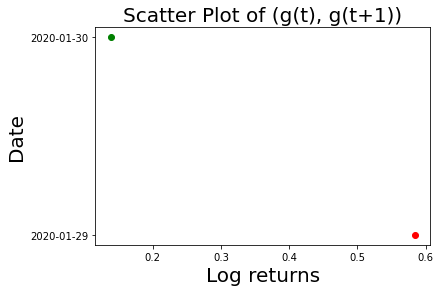

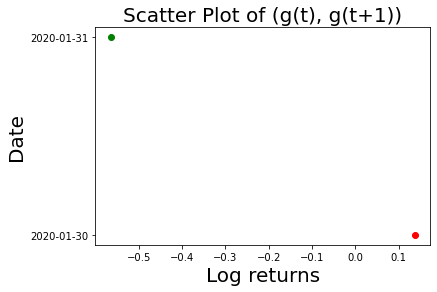

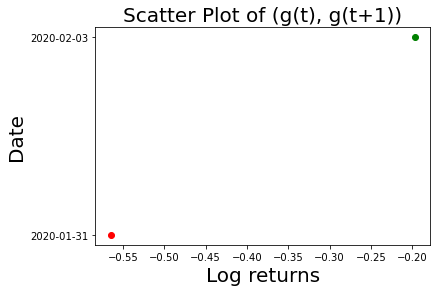

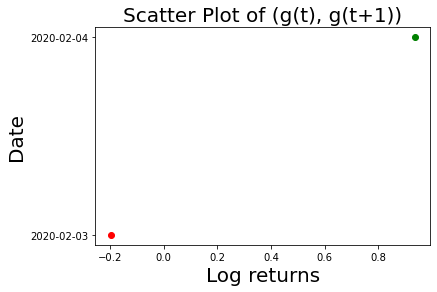

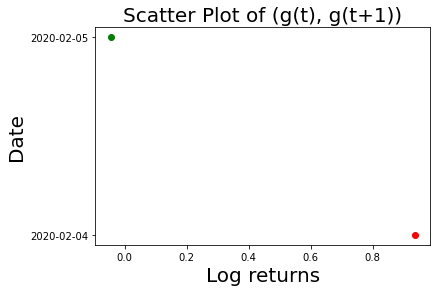

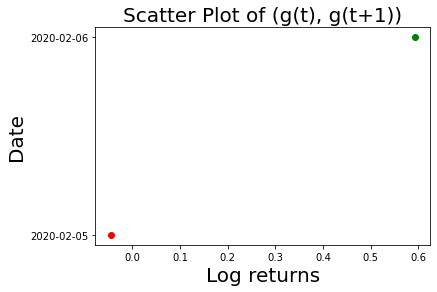

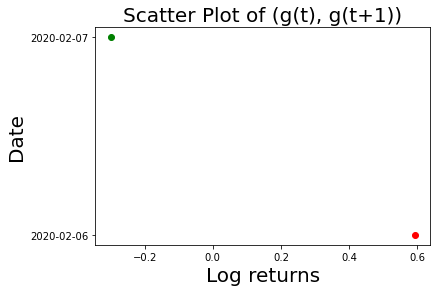

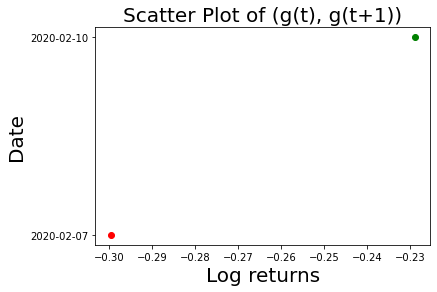

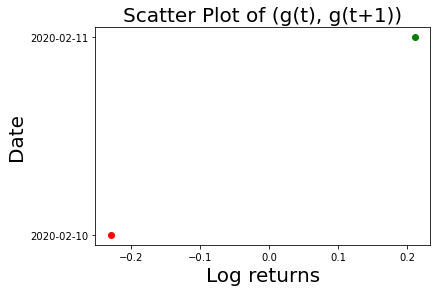

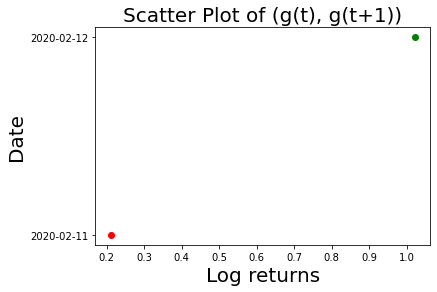

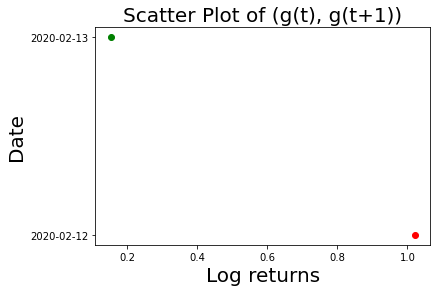

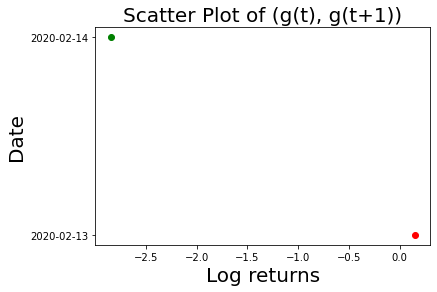

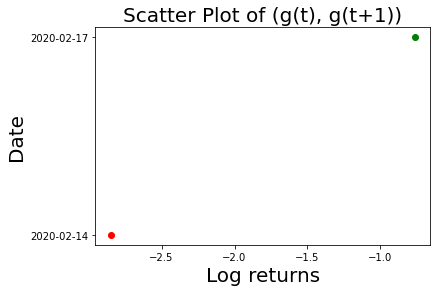

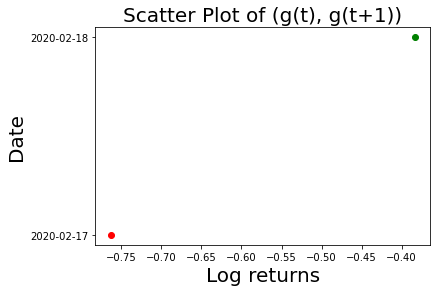

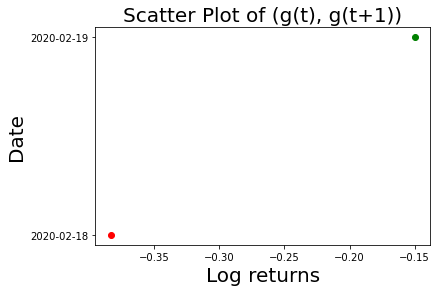

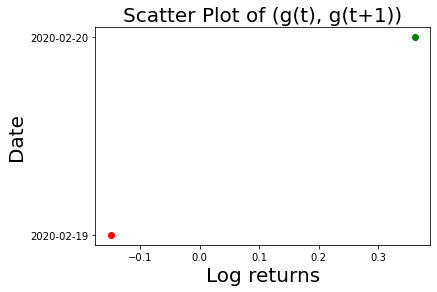

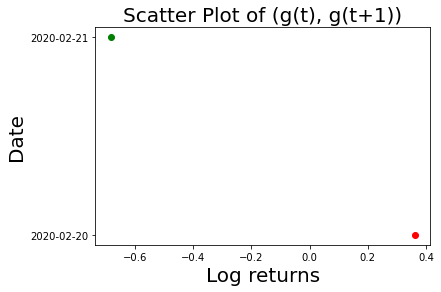

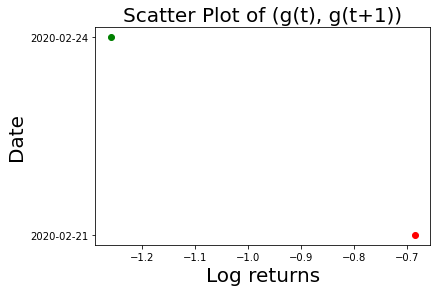

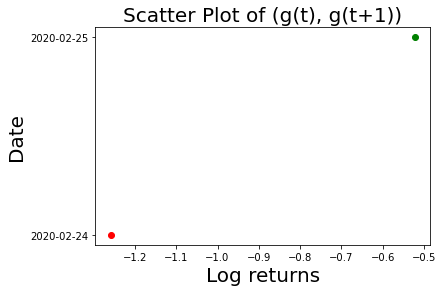

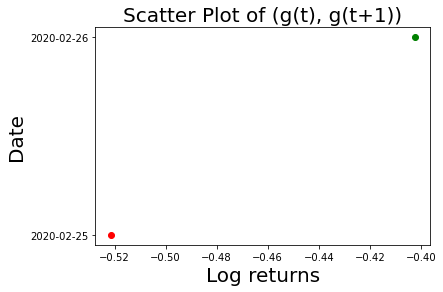

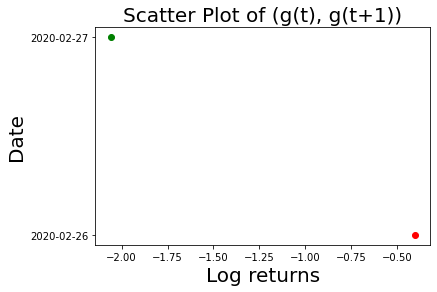

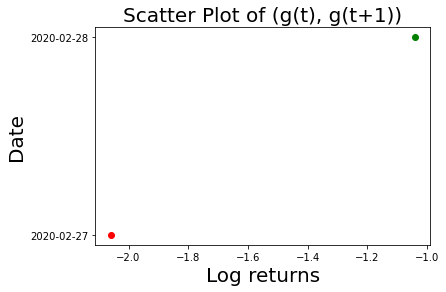

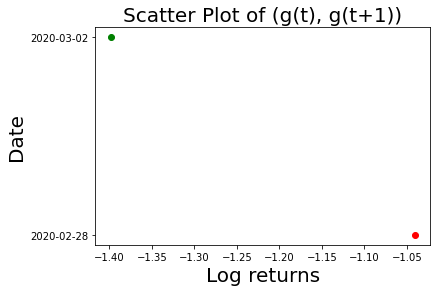

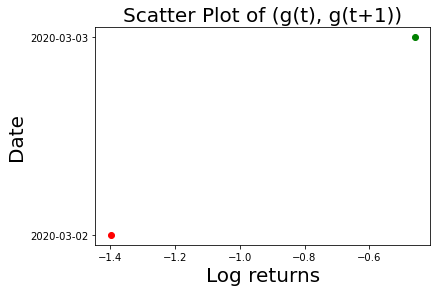

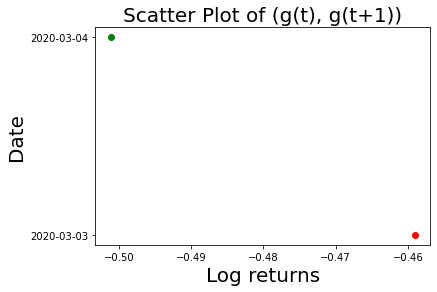

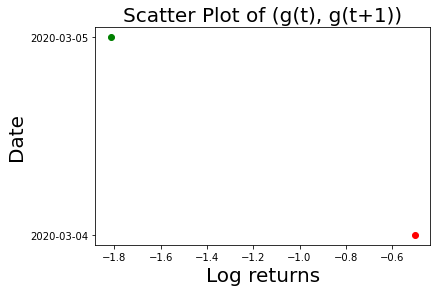

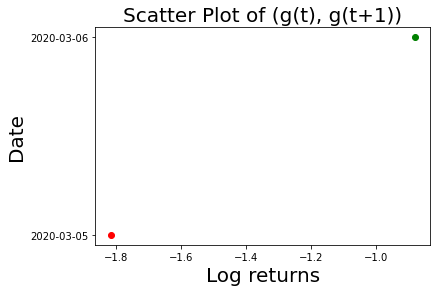

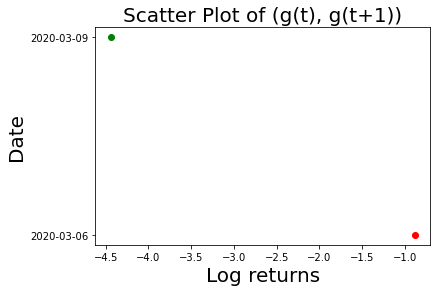

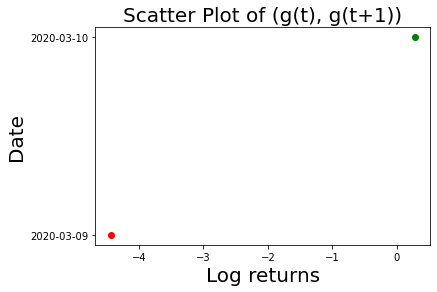

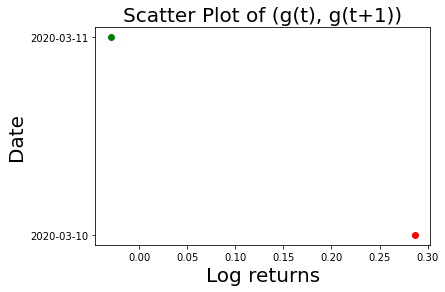

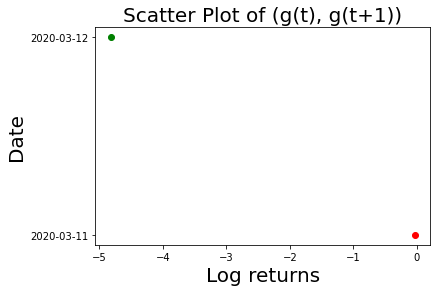

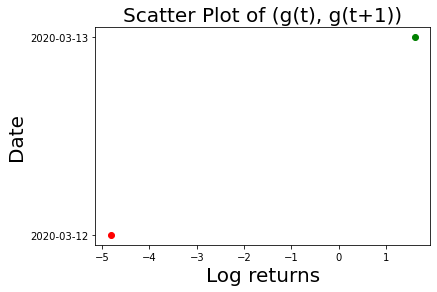

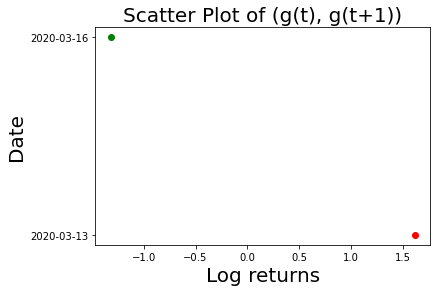

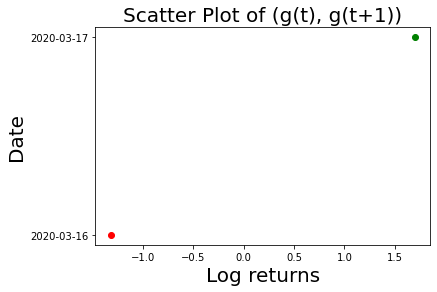

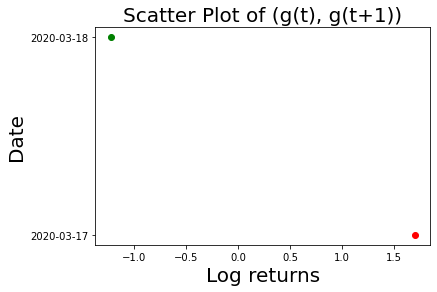

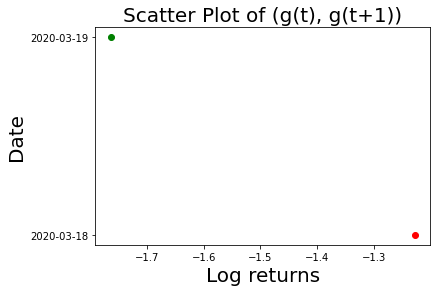

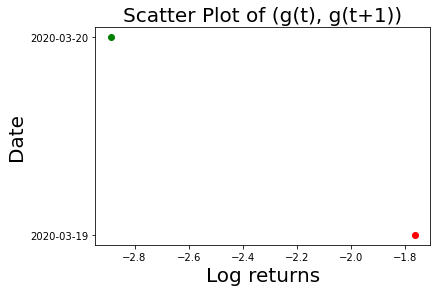

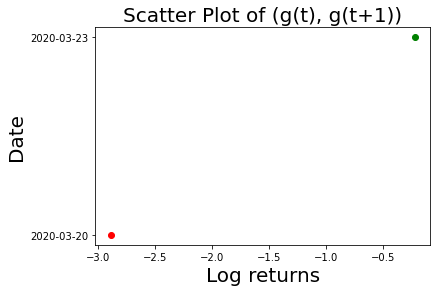

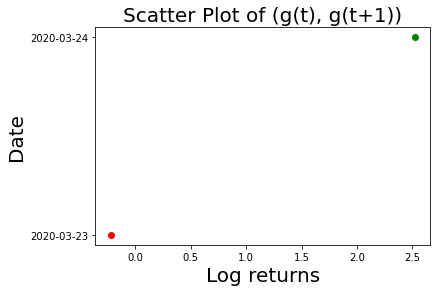

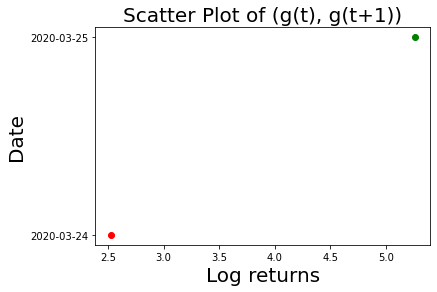

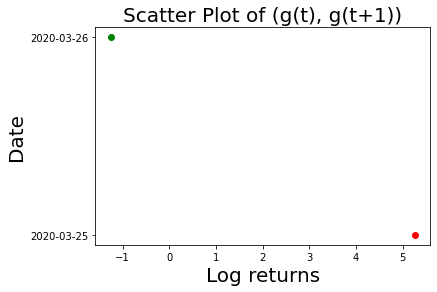

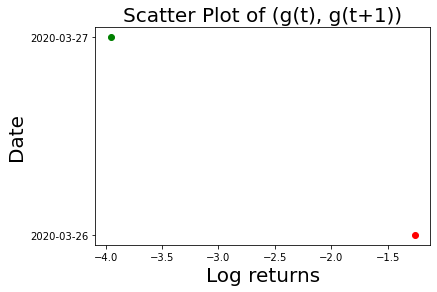

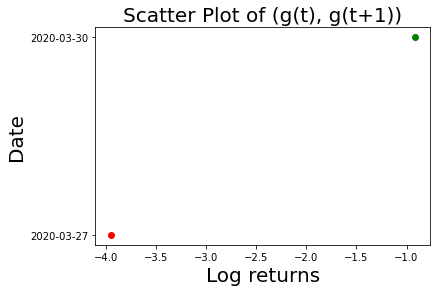

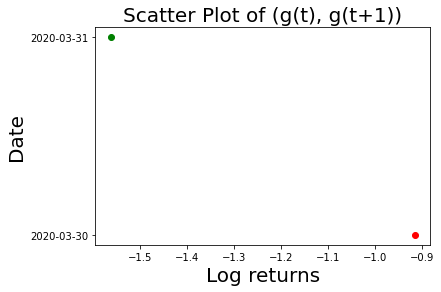

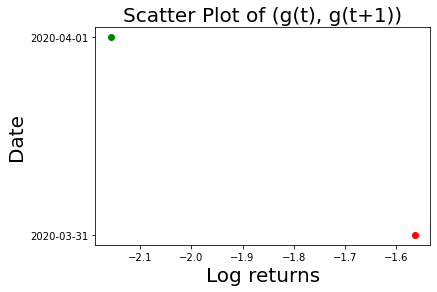

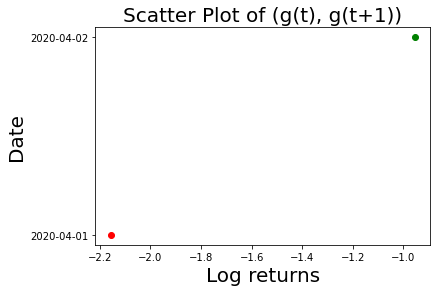

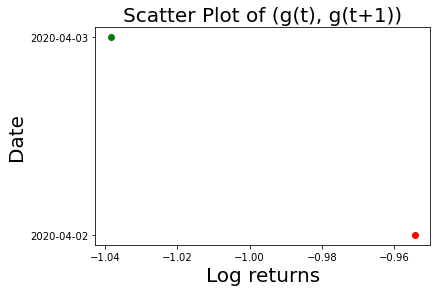

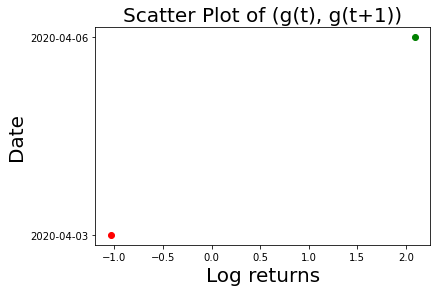

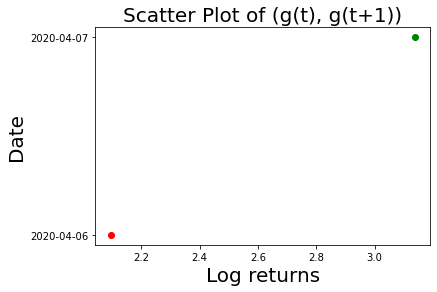

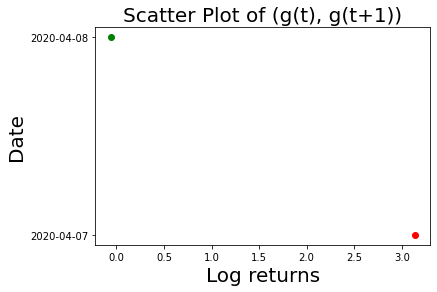

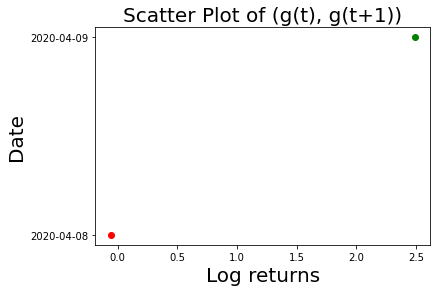

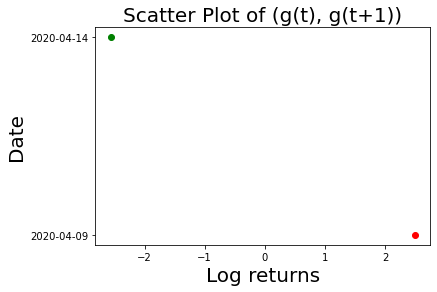

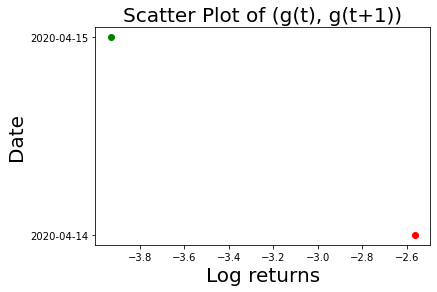

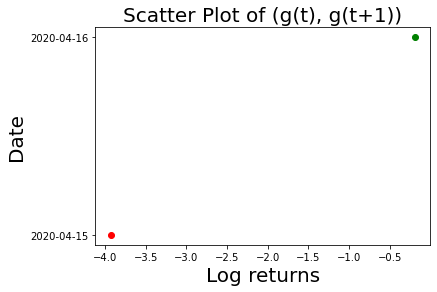

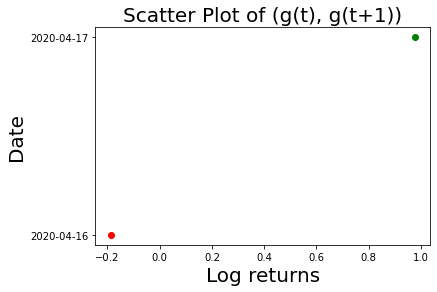

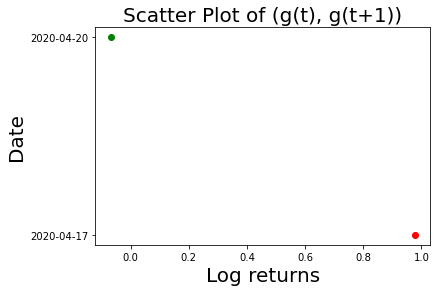

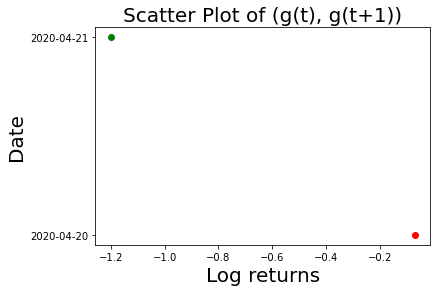

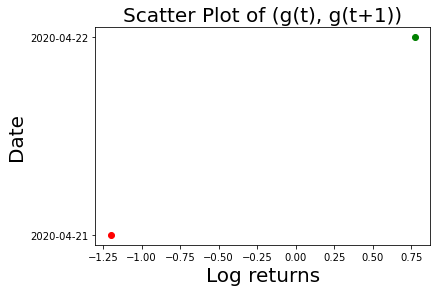

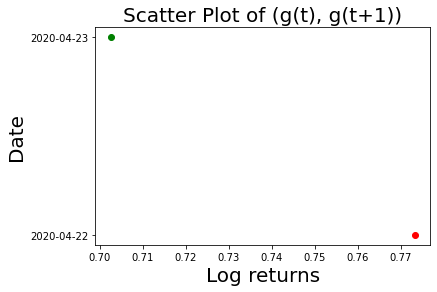

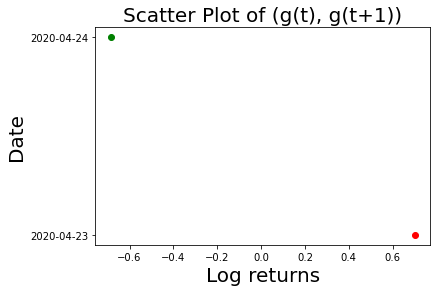

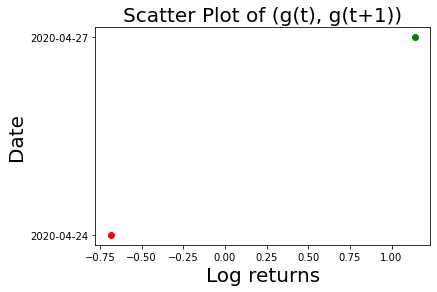

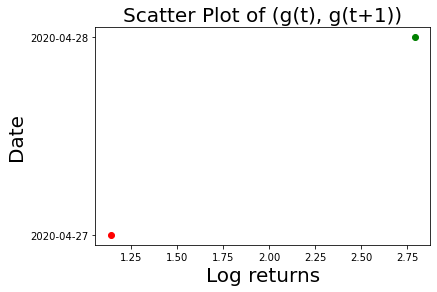

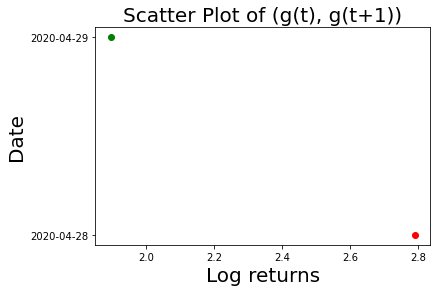

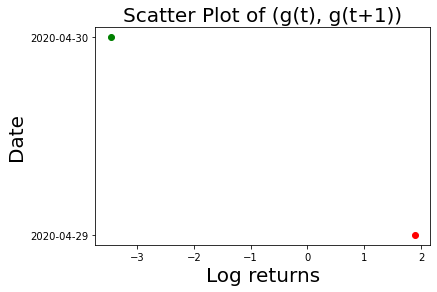

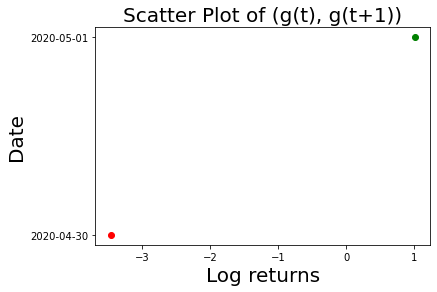

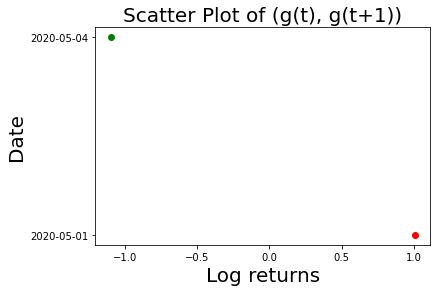

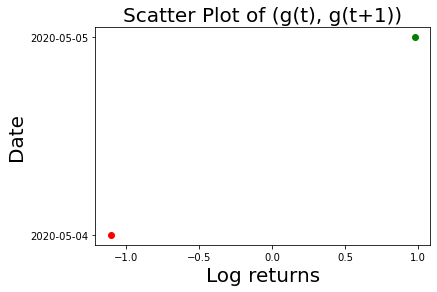

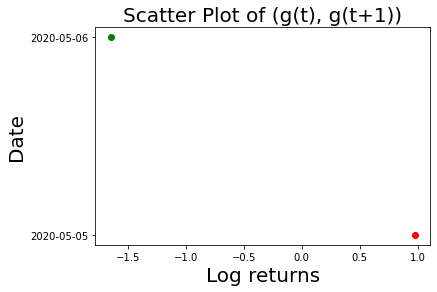

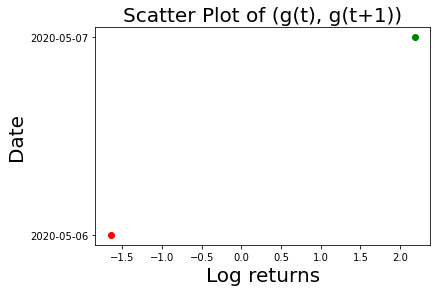

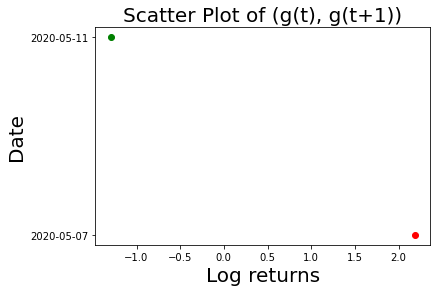

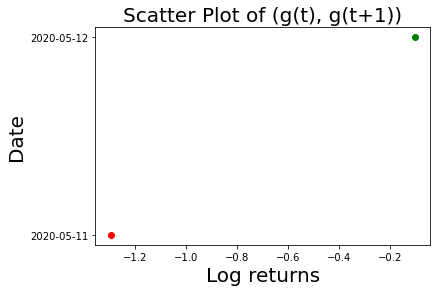

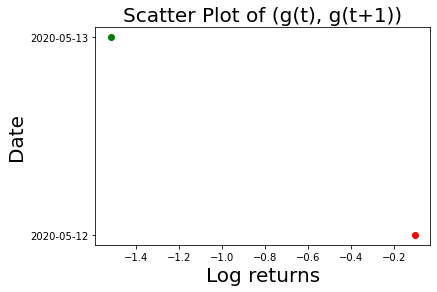

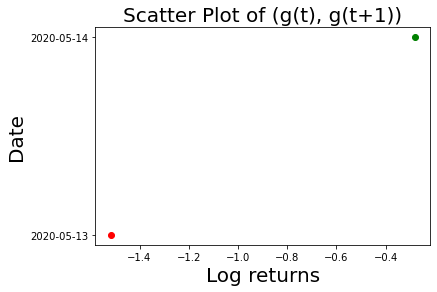

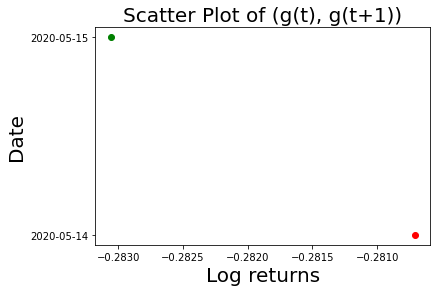

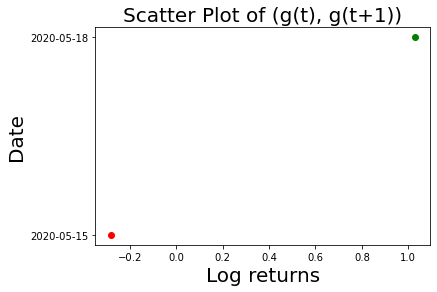

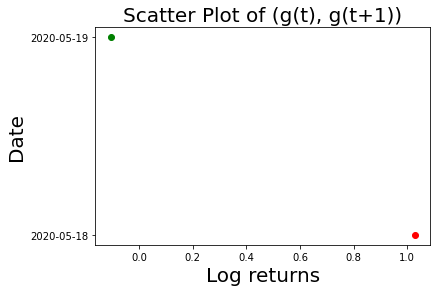

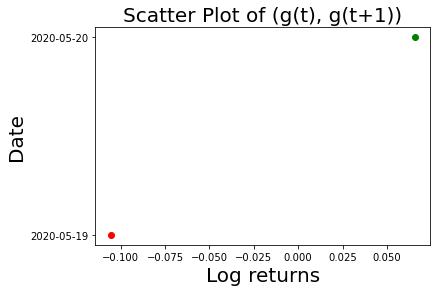

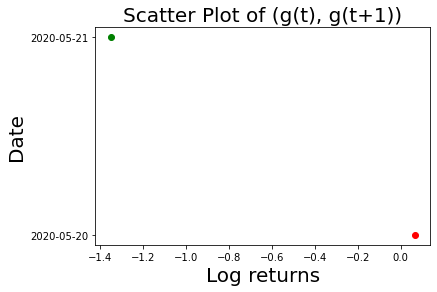

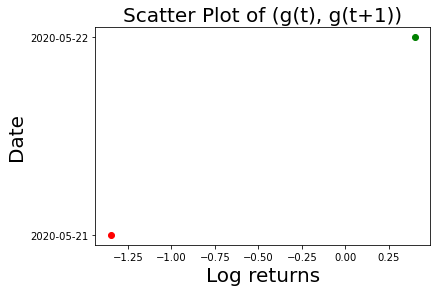

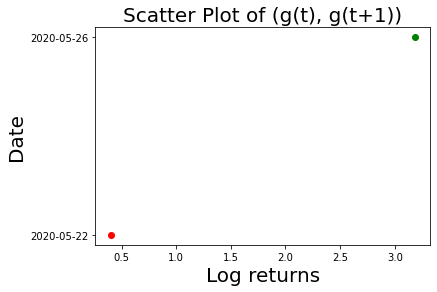

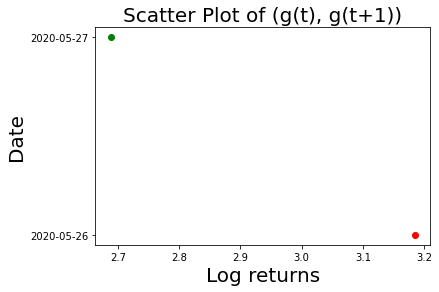

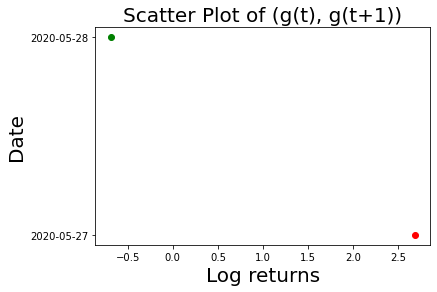

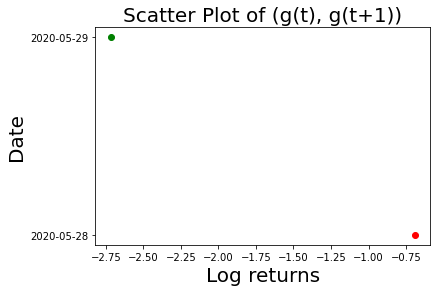

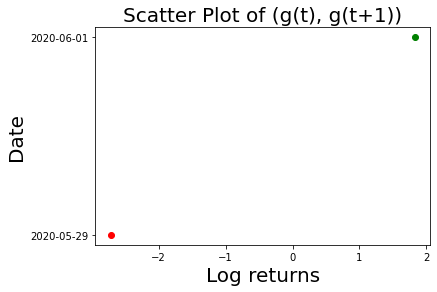

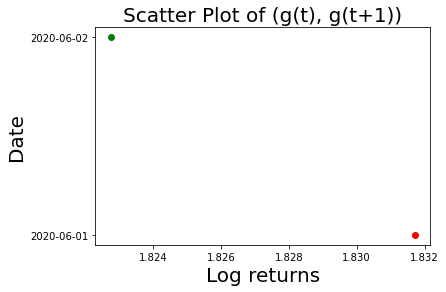

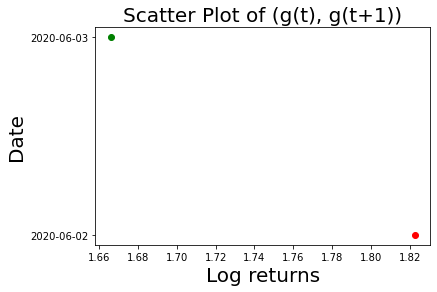

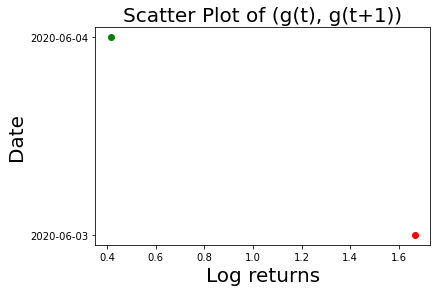

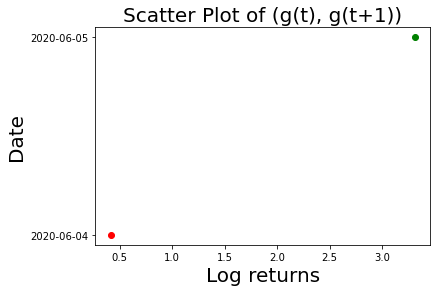

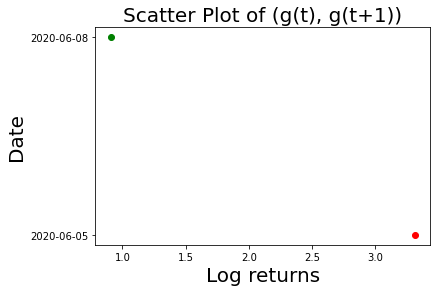

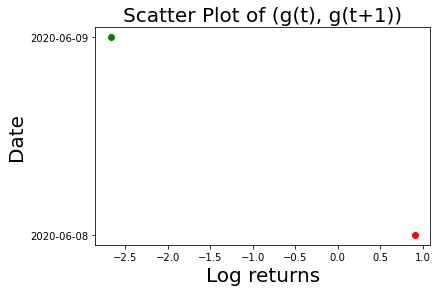

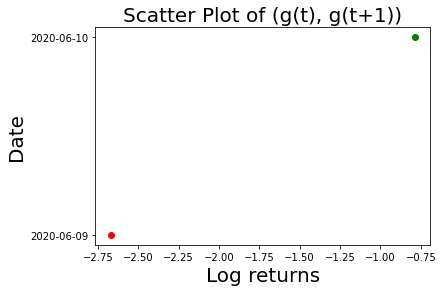

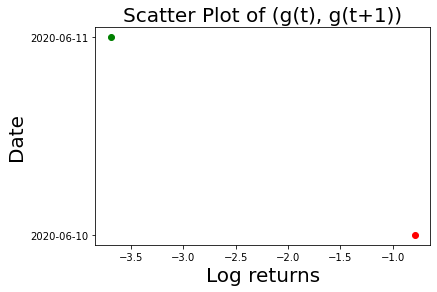

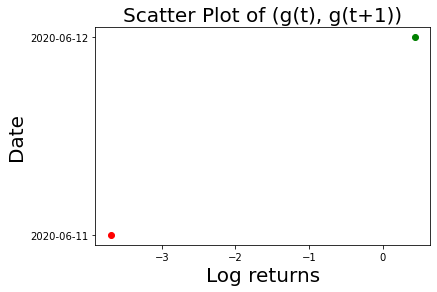

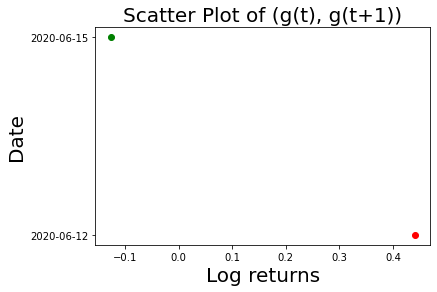

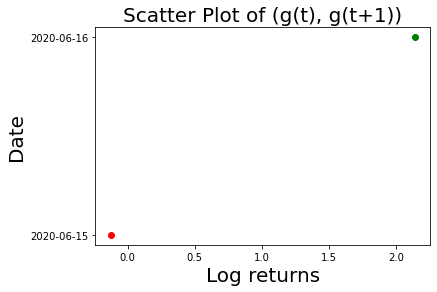

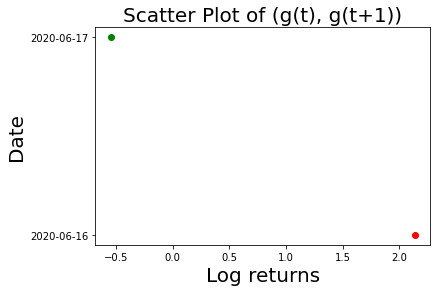

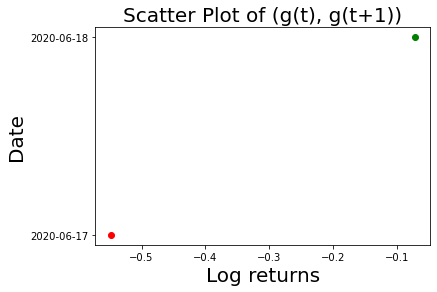

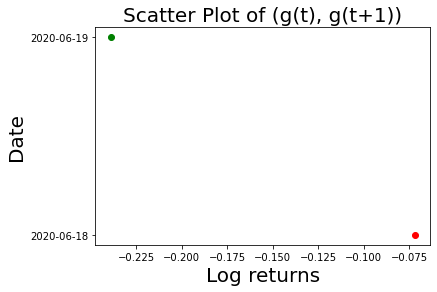

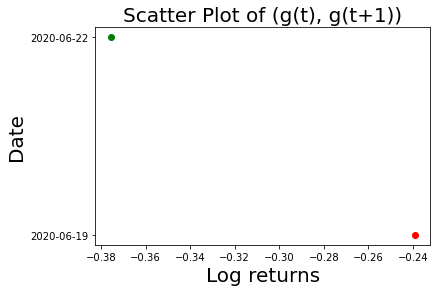

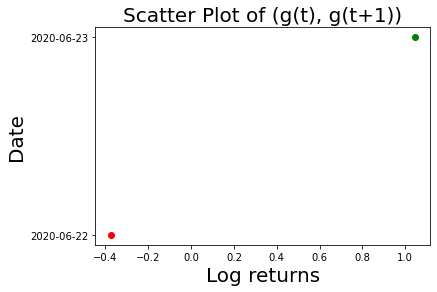

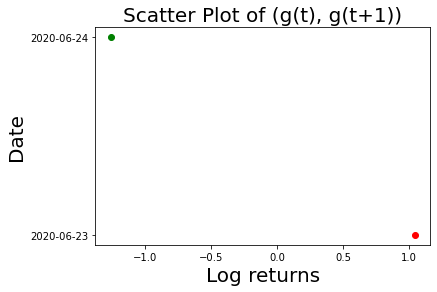

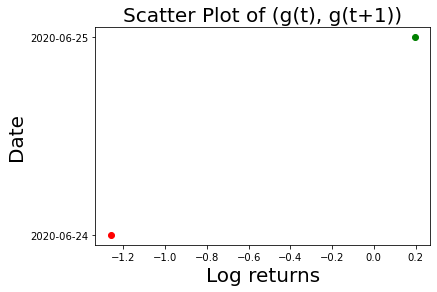

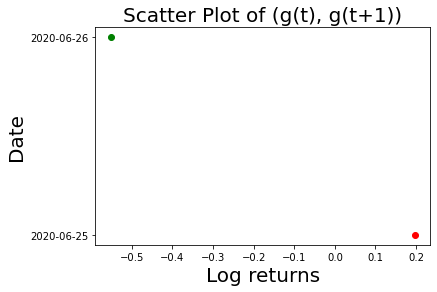

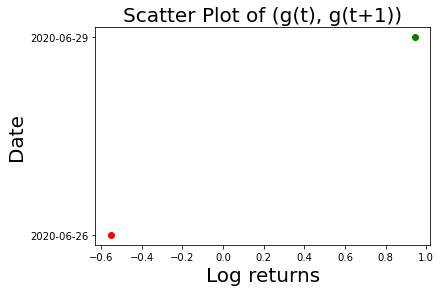

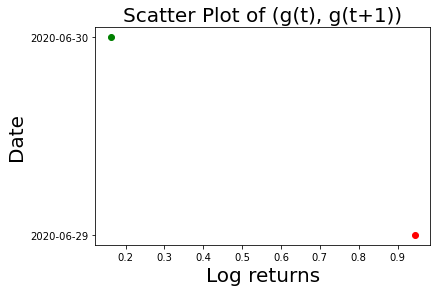

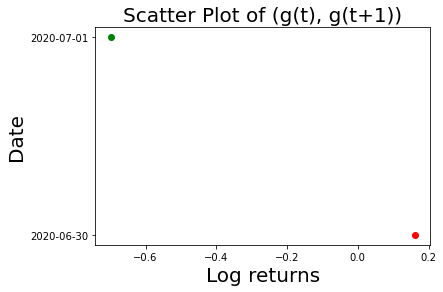

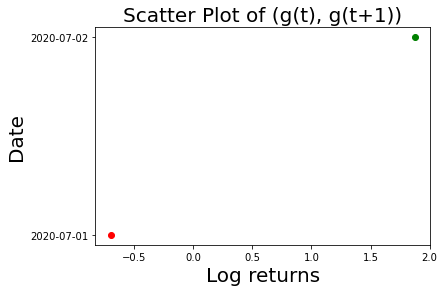

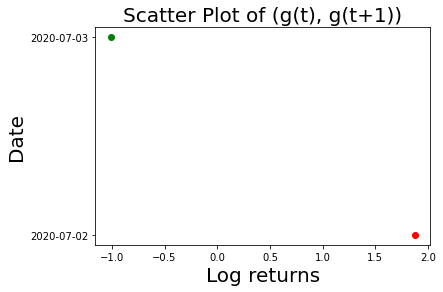

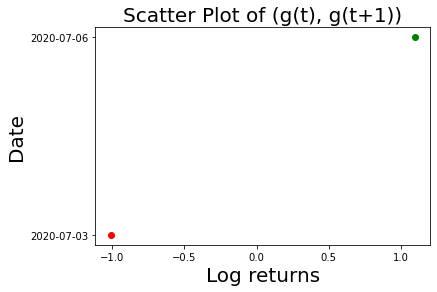

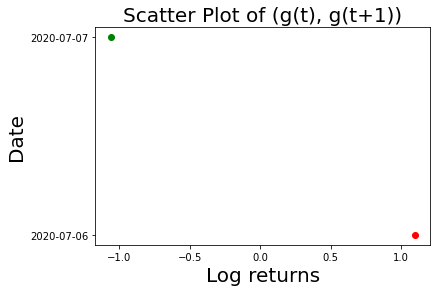

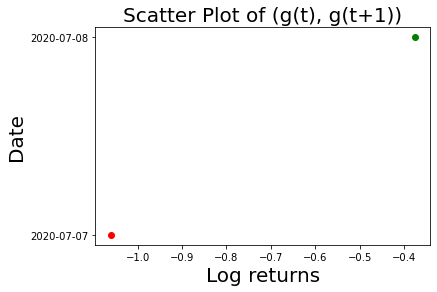

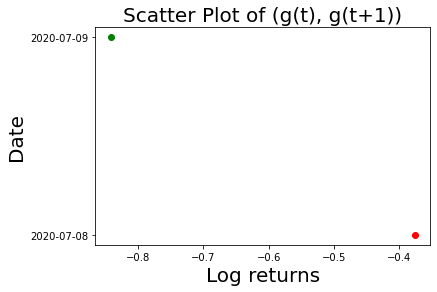

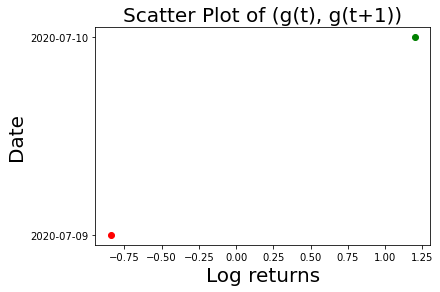

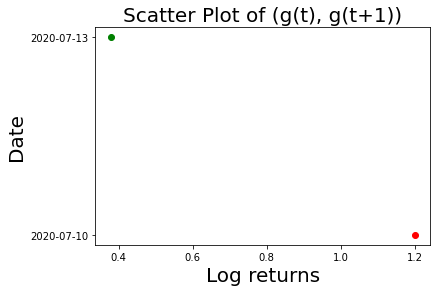

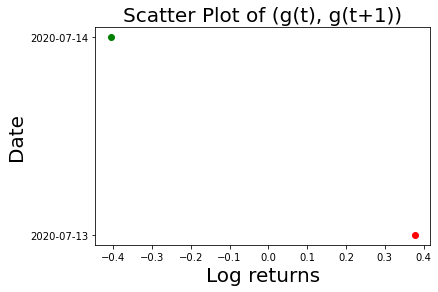

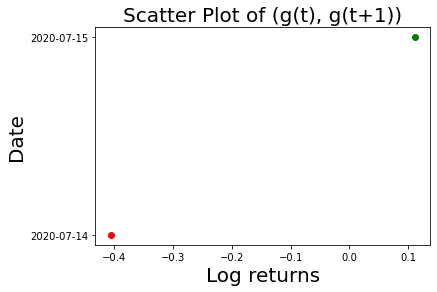

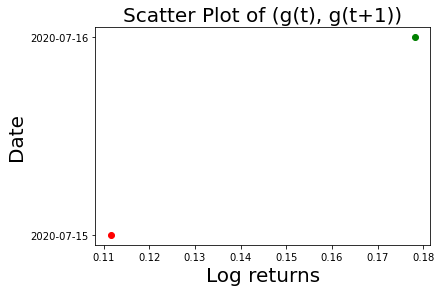

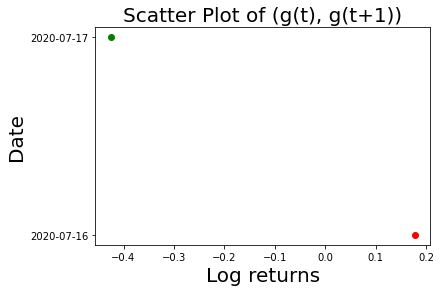

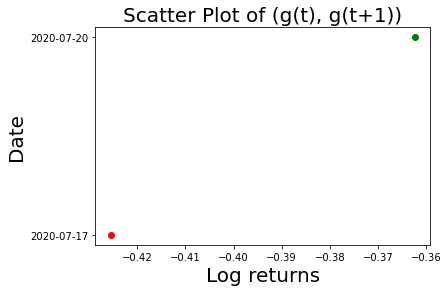

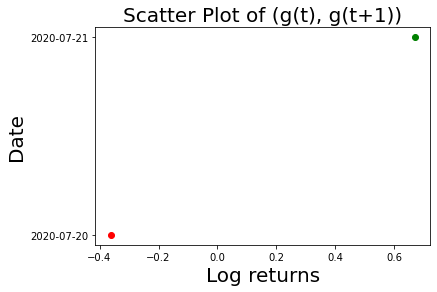

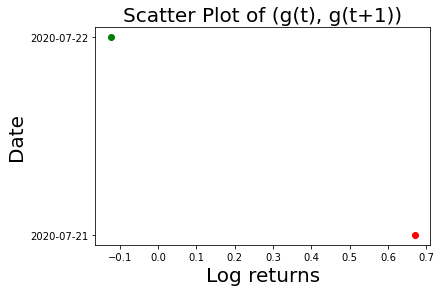

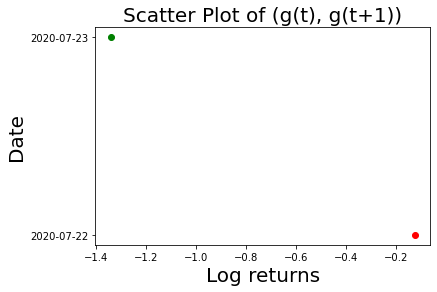

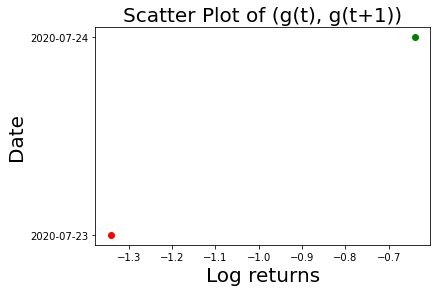

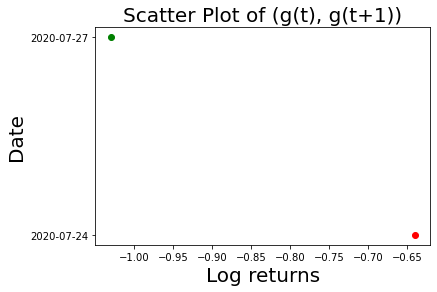

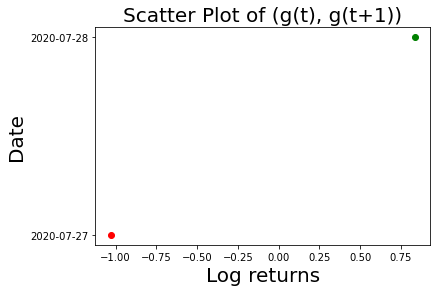

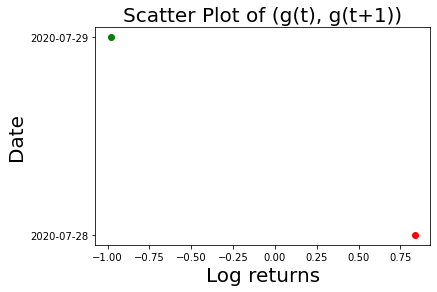

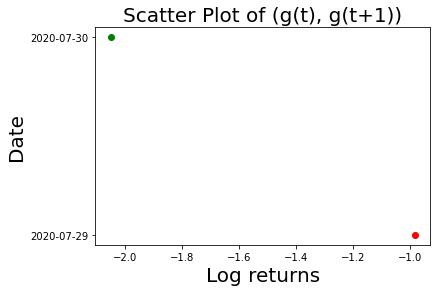

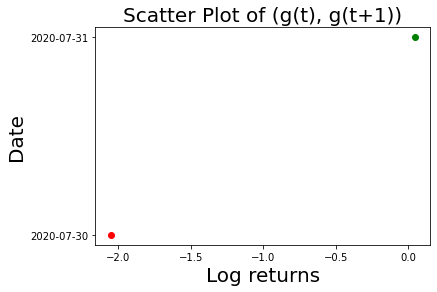

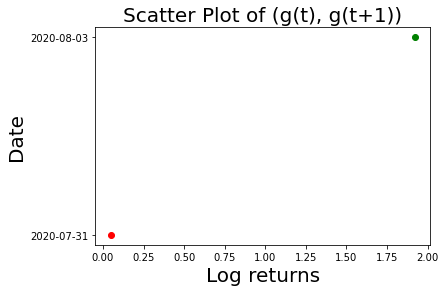

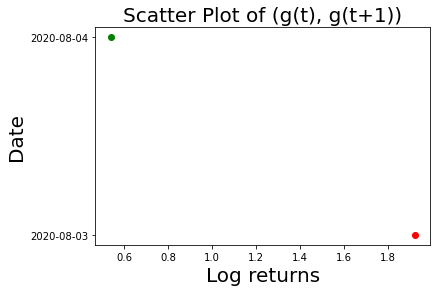

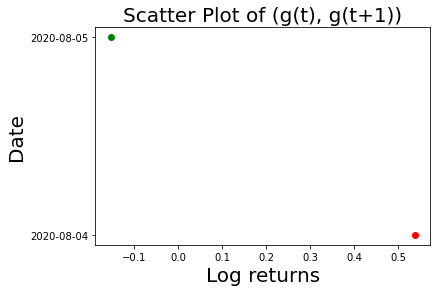

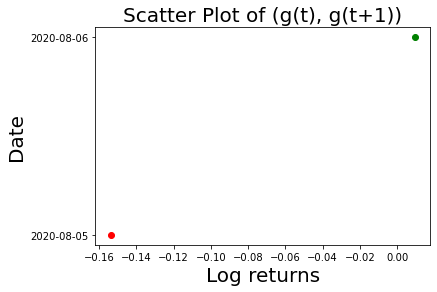

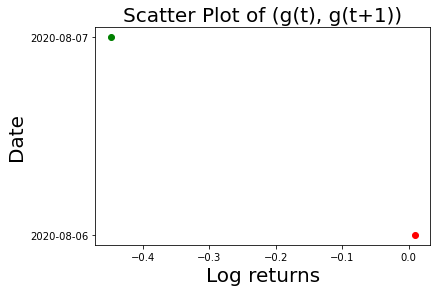

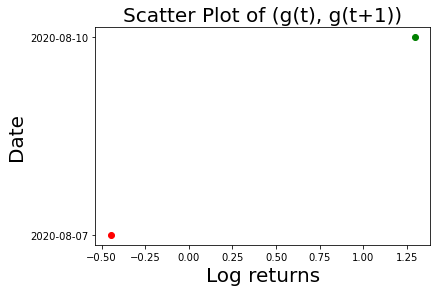

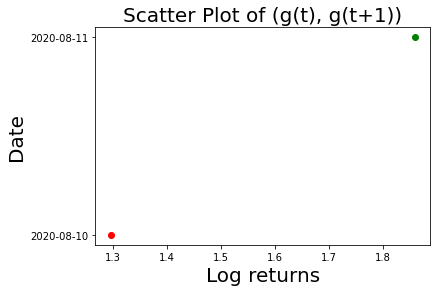

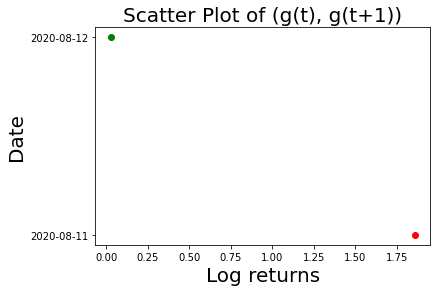

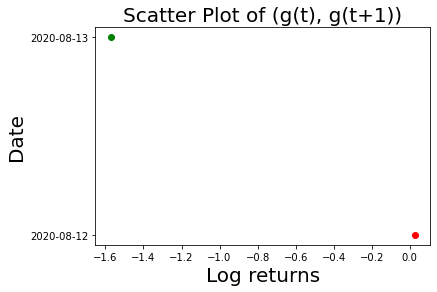

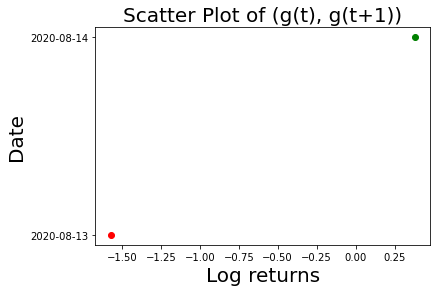

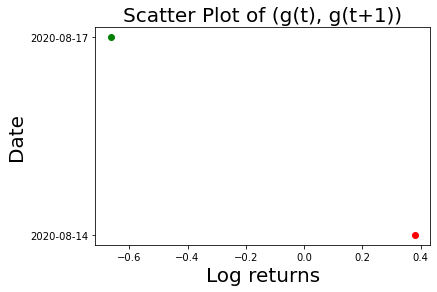

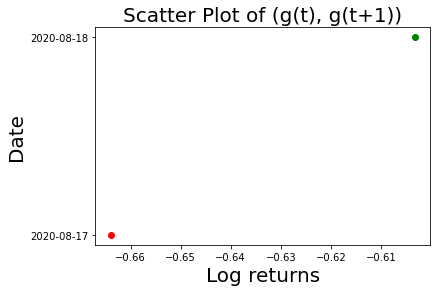

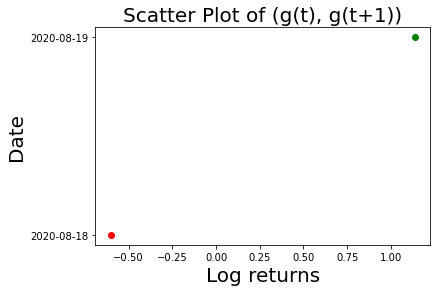

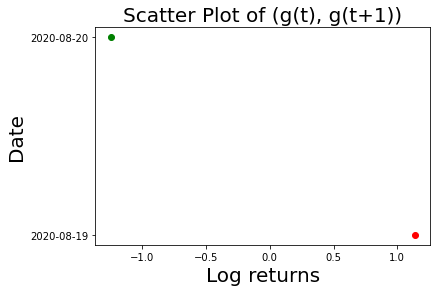

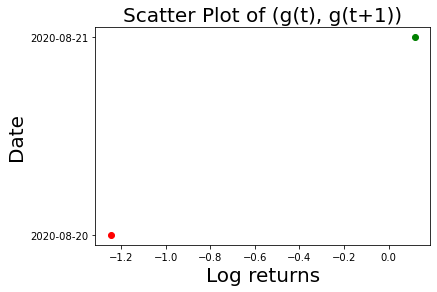

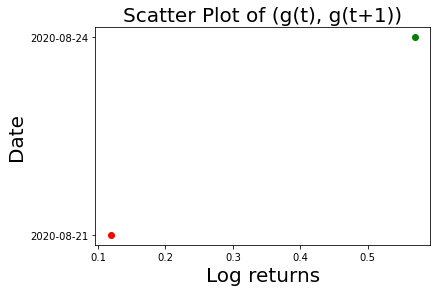

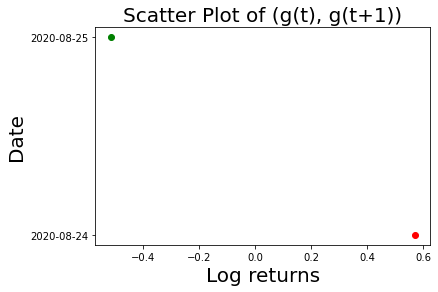

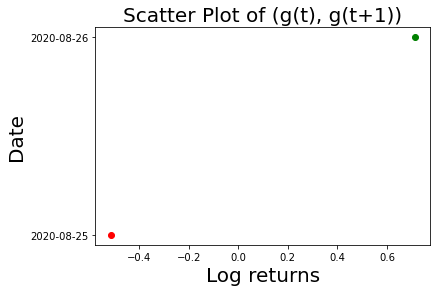

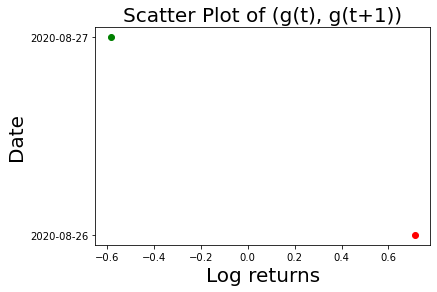

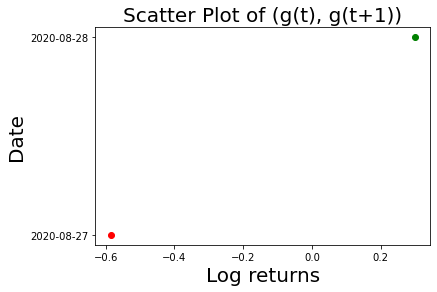

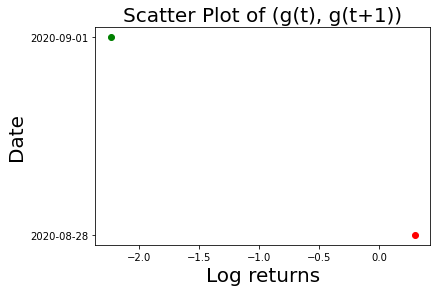

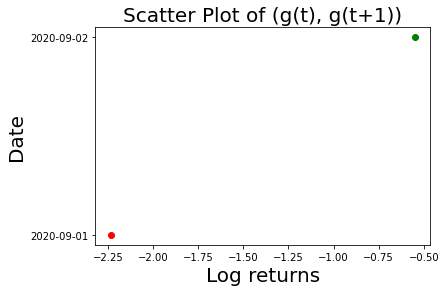

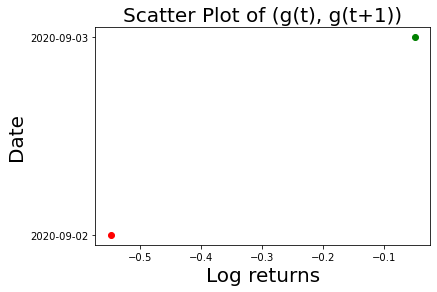

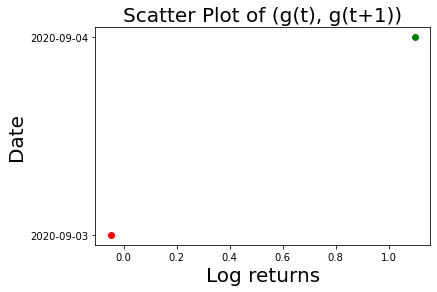

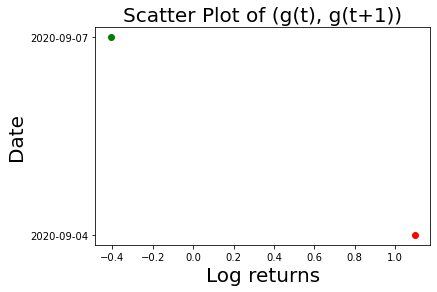

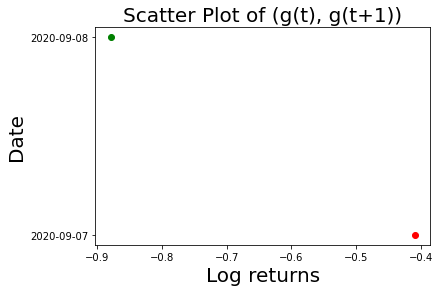

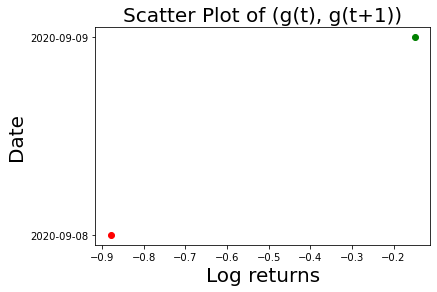

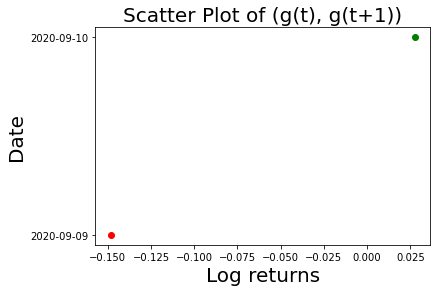

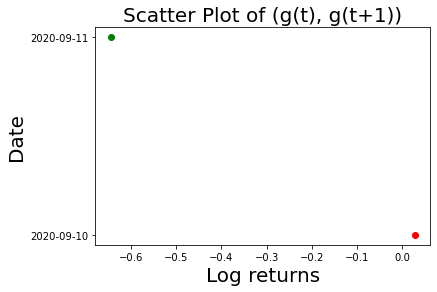

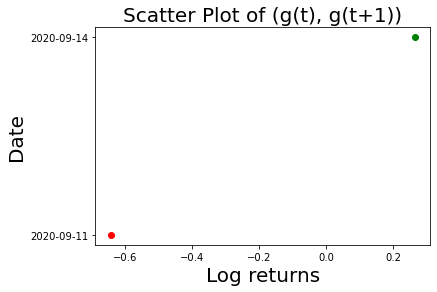

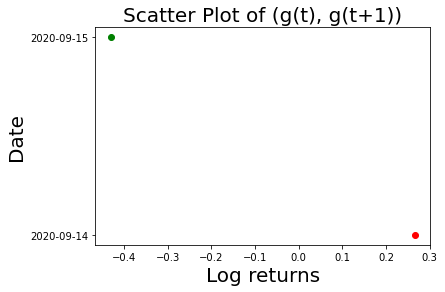

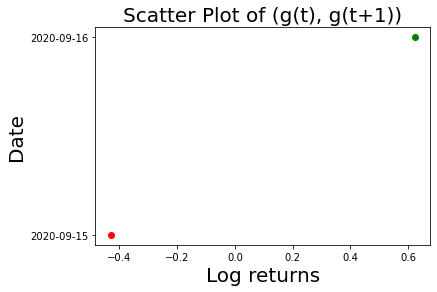

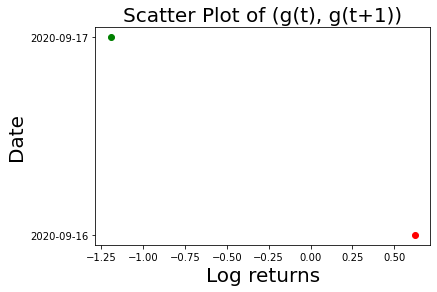

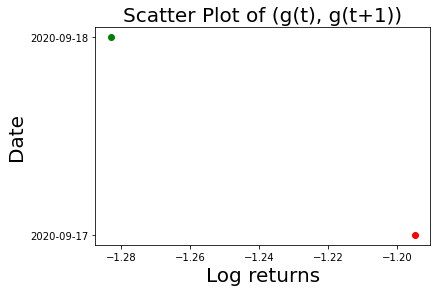

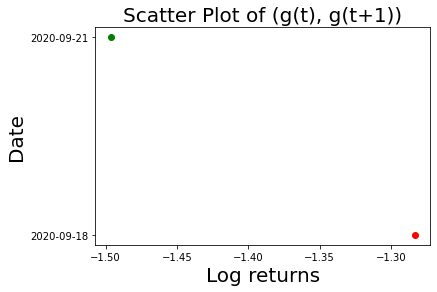

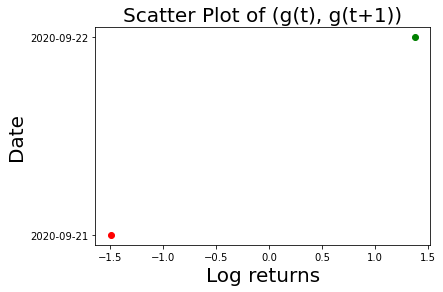

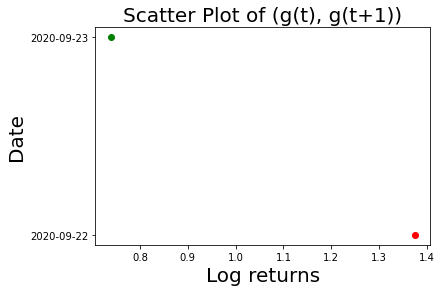

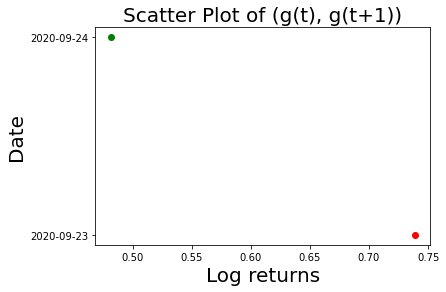

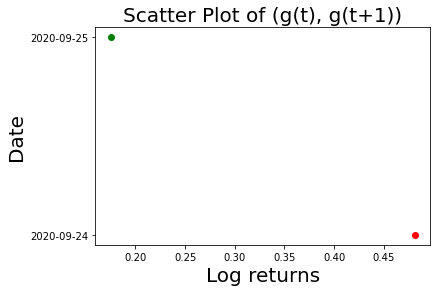

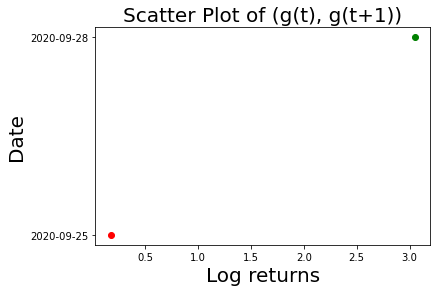

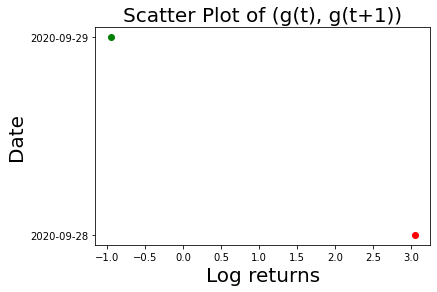

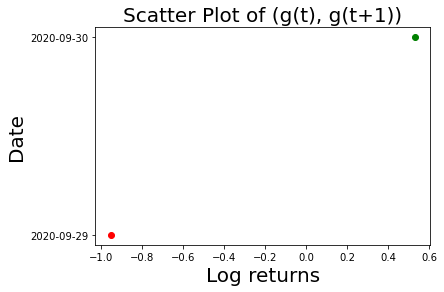

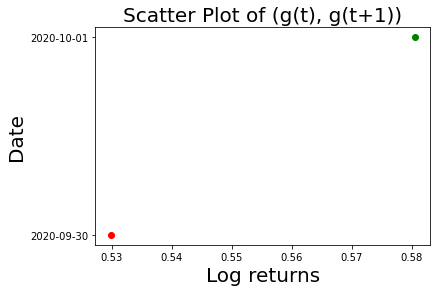

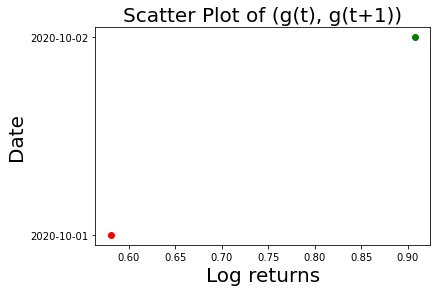

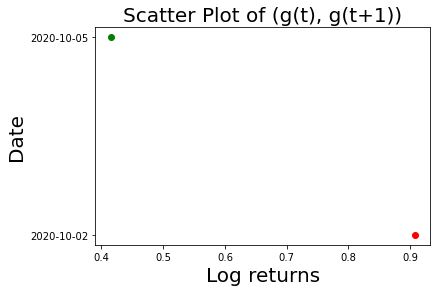

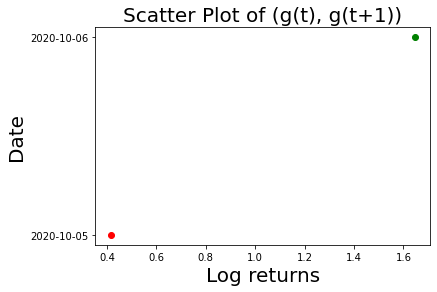

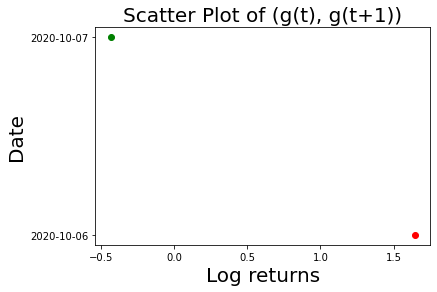

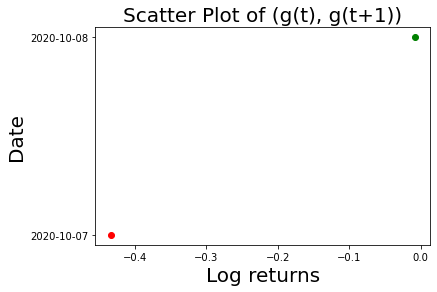

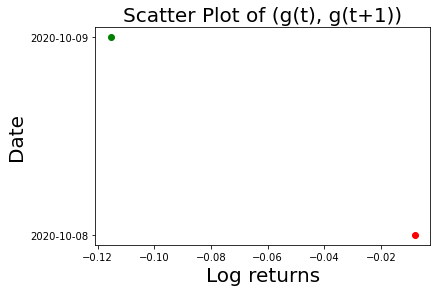

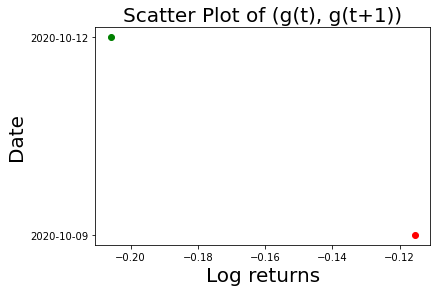

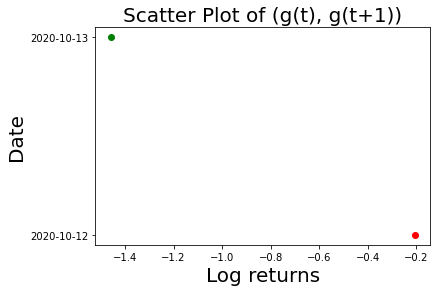

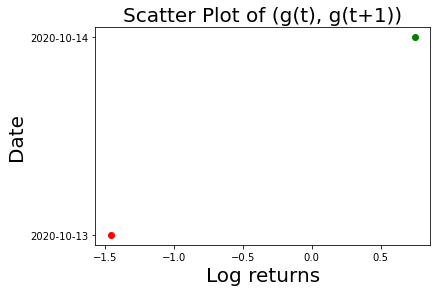

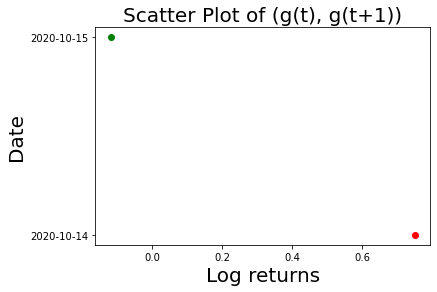

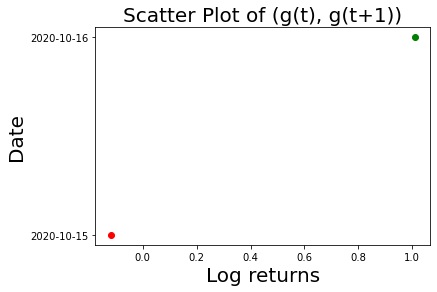

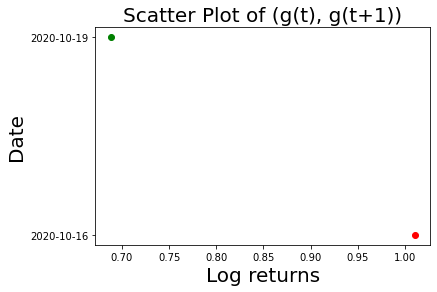

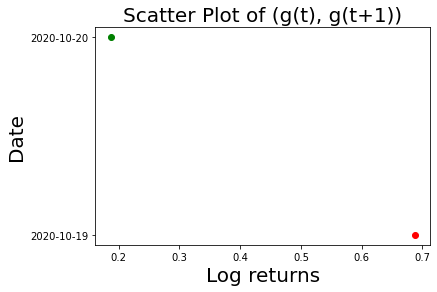

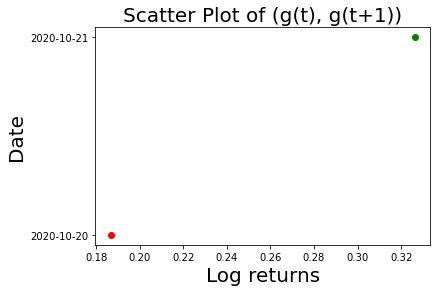

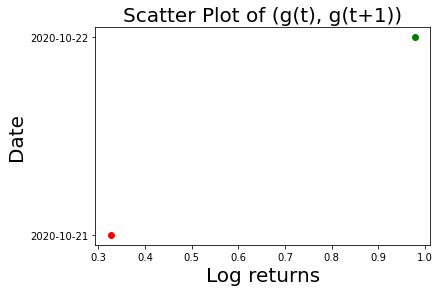

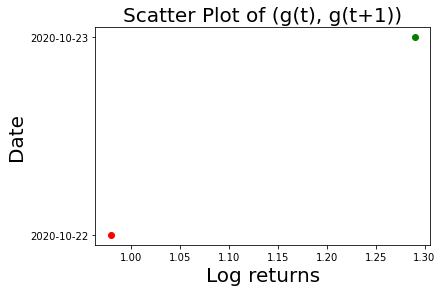

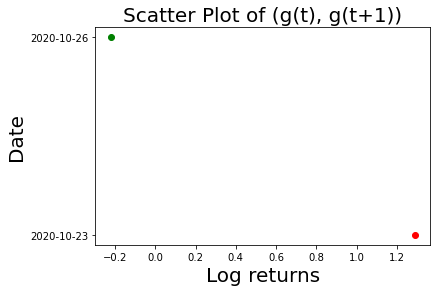

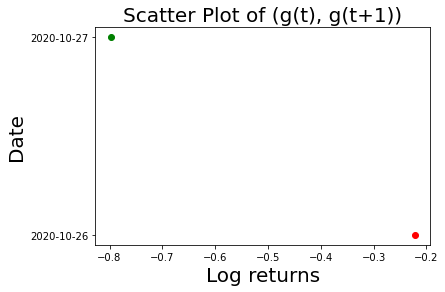

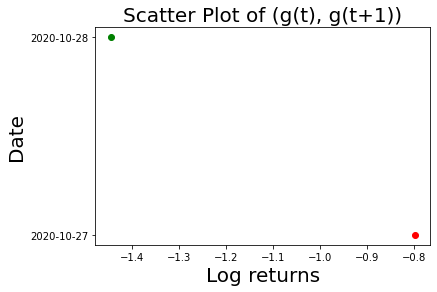

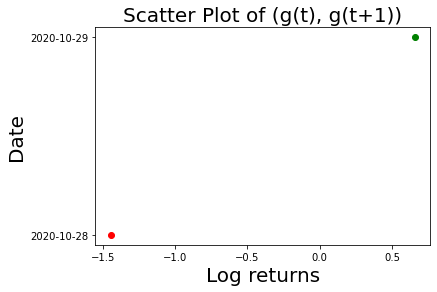

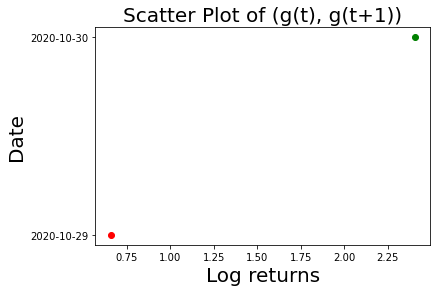

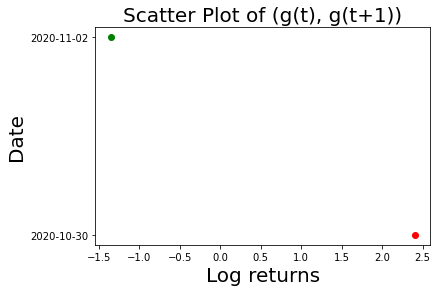

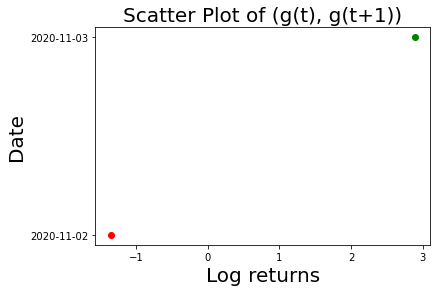

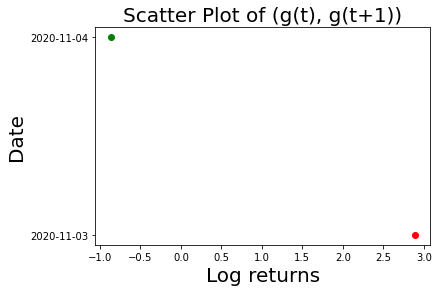

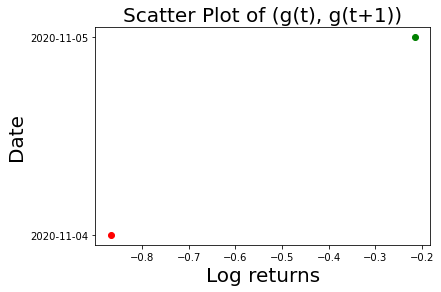

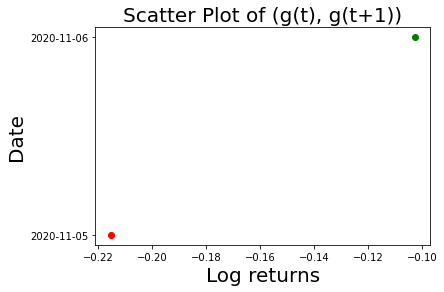

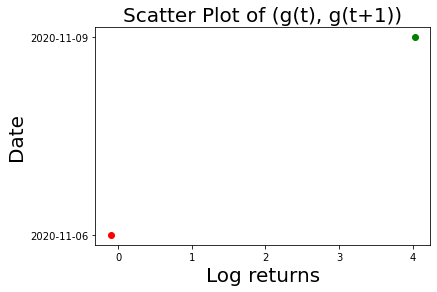

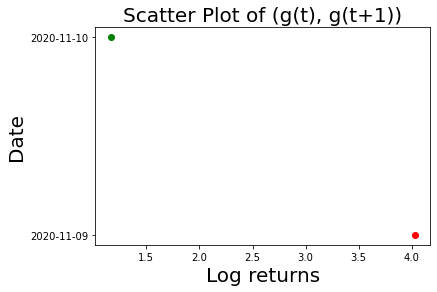

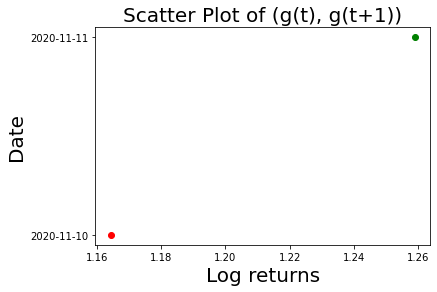

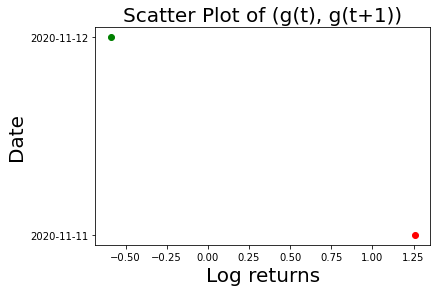

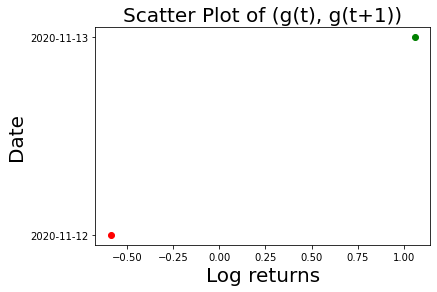

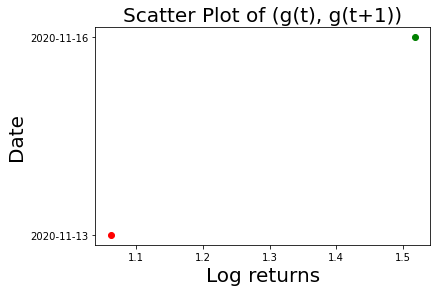

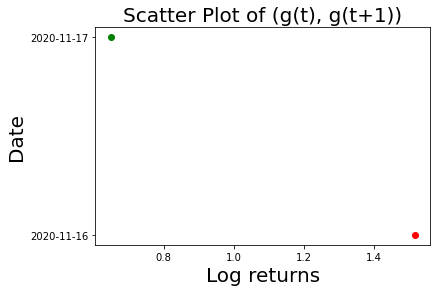

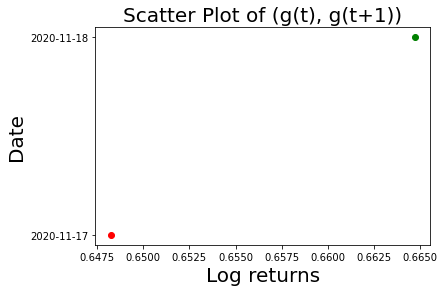

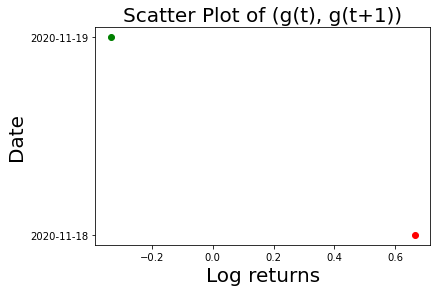

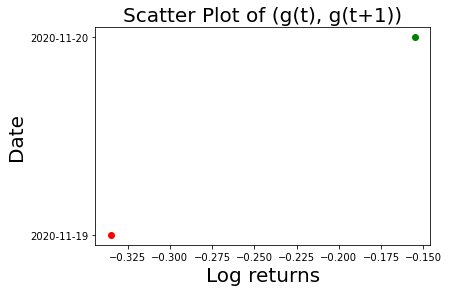

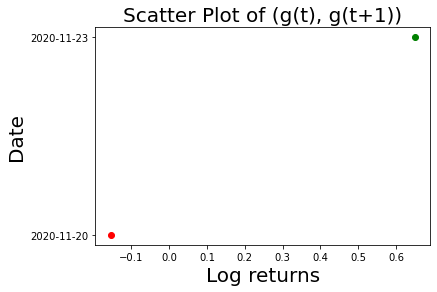

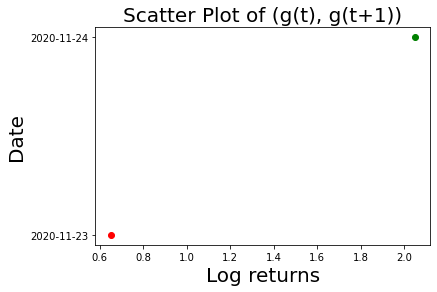

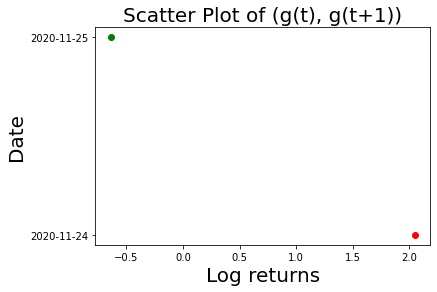

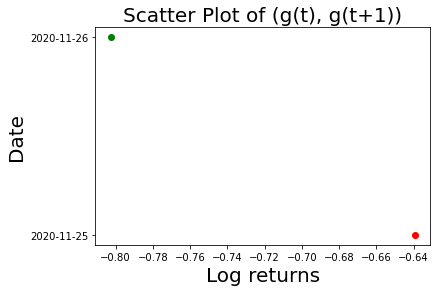

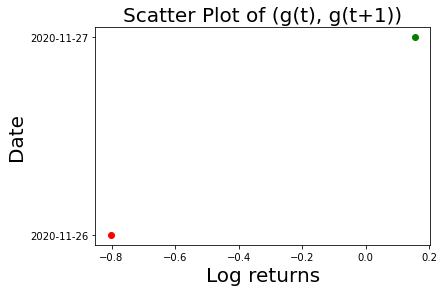

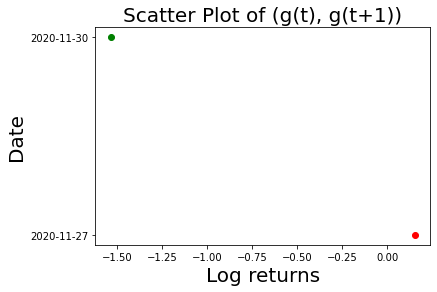

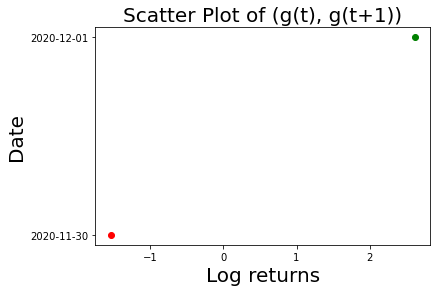

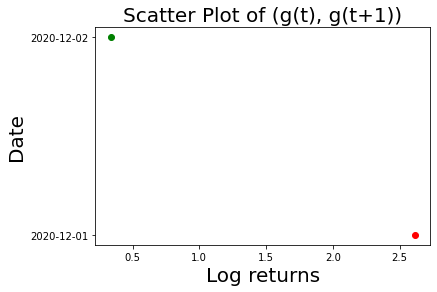

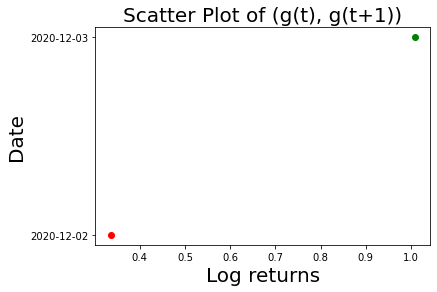

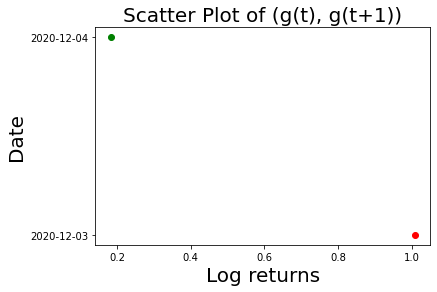

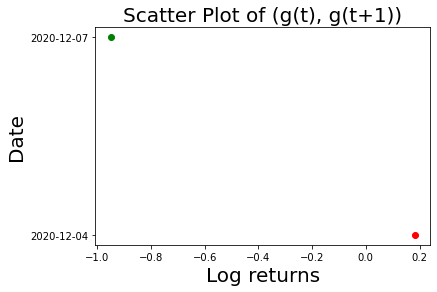

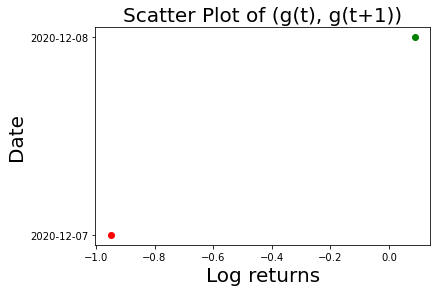

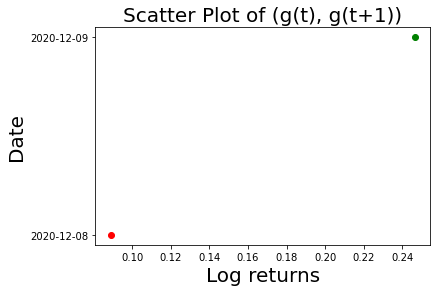

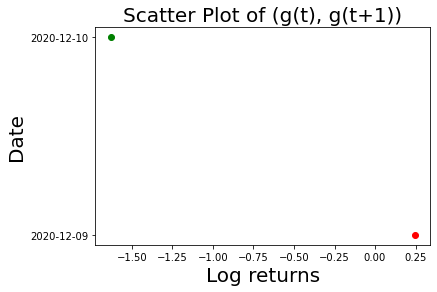

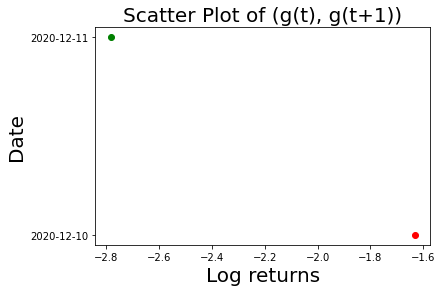

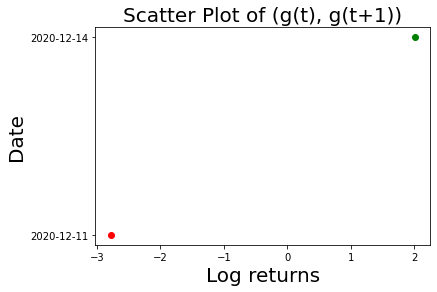

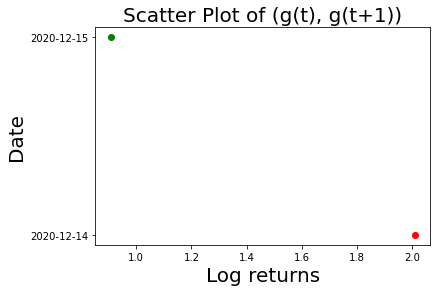

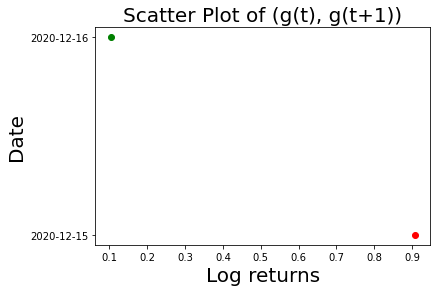

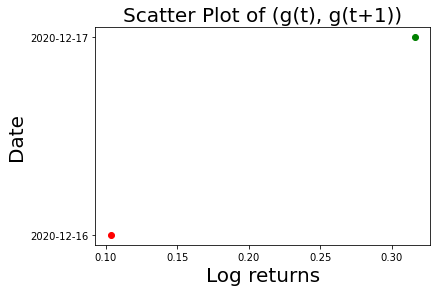

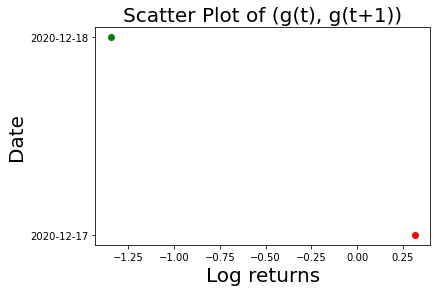

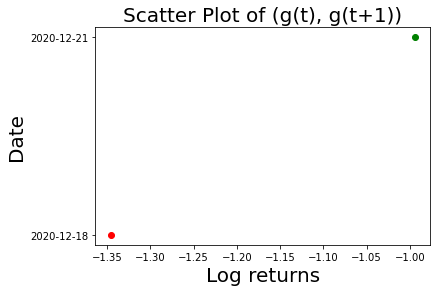

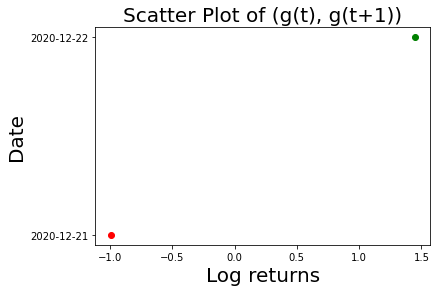

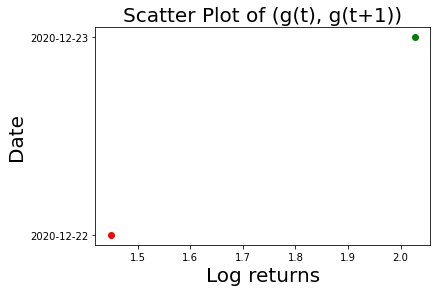

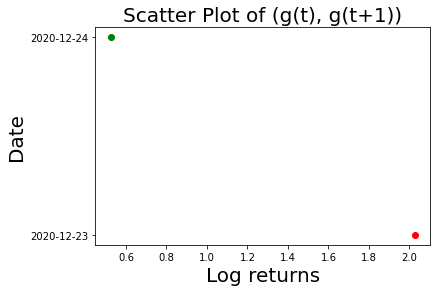

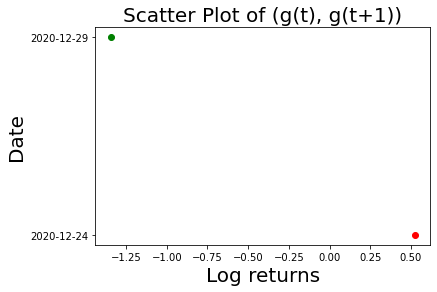

In [4]:
# scatter plot for (g(t), g(t+1)) with dates

for i in range(1, len(main_data) - 1):
    ax = plt.plot()
    plt.xlabel("Log returns", fontsize = 20)
    plt.ylabel("Date", fontsize = 20)
    plt.title("Scatter Plot of (g(t), g(t+1))", fontsize = 20)
    plt.scatter(main_data['log_ret'][i], df_rmg['Date'][i],c="red")
    plt.scatter(main_data['log_ret'][i + 1], df_rmg['Date'][i + 1],c="green")
    plt.show()

In [5]:
# assign all the values to train and the test from the target 
# time-series 
train = main_data['log_ret']
test = main_data['log_ret']

train

1     -0.237411
2      0.395456
3     -0.222008
4      0.379795
5      0.289784
         ...   
754    1.448491
755    2.027365
756    0.524690
757   -1.344531
758    0.572325
Name: log_ret, Length: 758, dtype: float64

In [6]:
# get the trained data in an array
dd = np.asarray(train)

# convert test data into dataframe
test = pd.DataFrame(test)

# get the tested data in y_hat for forecasting
y_hat = test.copy()

y_hat

log_ret
1   -0.237411
2    0.395456
3   -0.222008
4    0.379795
5    0.289784
..        ...
754  1.448491
755  2.027365
756  0.524690
757 -1.344531
758  0.572325

[758 rows x 1 columns]

In [7]:
# reset the index
y_hat = y_hat.reset_index(drop = True)
test = test.reset_index(drop = True)

# forecast naively associating the first value with all the values
y_hat['forecast'] = dd[len(dd)-1]

y_hat


log_ret  forecast
0   -0.237411  0.572325
1    0.395456  0.572325
2   -0.222008  0.572325
3    0.379795  0.572325
4    0.289784  0.572325
..        ...       ...
753  1.448491  0.572325
754  2.027365  0.572325
755  0.524690  0.572325
756 -1.344531  0.572325
757  0.572325  0.572325

[758 rows x 2 columns]

In [8]:
# now change the forecast to the previous value in every row
for i in range(1, len(test)):
    y_hat['forecast'][i] = y_hat['log_ret'][i - 1]

# change the first value to NaN since we cannot forecast it
# without prior data
y_hat['forecast'][0] = 'NaN'

y_hat

log_ret  forecast
0   -0.237411       NaN
1    0.395456 -0.237411
2   -0.222008  0.395456
3    0.379795 -0.222008
4    0.289784  0.379795
..        ...       ...
753  1.448491 -0.994030
754  2.027365  1.448491
755  0.524690  2.027365
756 -1.344531  0.524690
757  0.572325 -1.344531

[758 rows x 2 columns]

In [10]:
# get the error using mse
from sklearn.metrics import mean_squared_error
from math import sqrt

# delete the NaN value
y_hat = y_hat.iloc[1:]
test = test.iloc[1:]
rms = mean_squared_error(y_hat.log_ret, y_hat.forecast)

print(rms)

1.8651179248322756


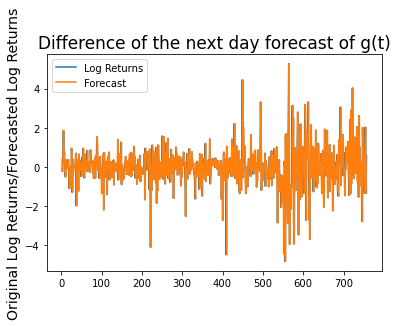

In [13]:
# TO SHOW THE ORIGINAL RETURNS AND FORECASTED RETURNS

y_hat['log_ret'].plot(label = 'Log Returns')
y_hat['forecast'].plot(label = 'Forecast')
plt.title('Difference of the next day forecast of g(t)', fontsize = 17)
plt.ylabel('Original Log Returns/Forecasted Log Returns', fontsize = 14)
plt.legend()
plt.show()

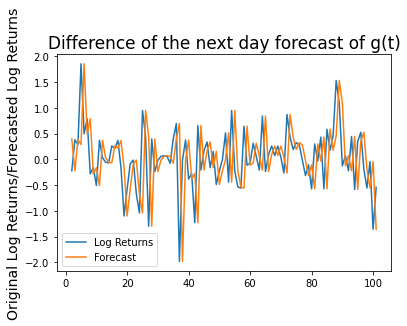

In [14]:
# FOR BETTER UNDERSTANDING AND EASIER VISUALIZATION

y_hat['log_ret'][:100].plot(label = 'Log Returns')
y_hat['forecast'][:100].plot(label = 'Forecast')
plt.title('Difference of the next day forecast of g(t)', fontsize = 17)
plt.ylabel('Original Log Returns/Forecasted Log Returns', fontsize = 14)
plt.legend()
plt.show()

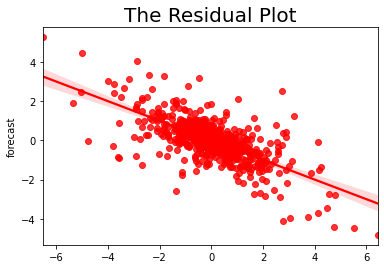

In [15]:
import seaborn as sns

# get the residuals
residuals = y_hat['log_ret'] - y_hat['forecast']

# plot the residuals
sns.regplot(x = residuals, y = y_hat['forecast'], data = None, scatter = True, color = 'red')
plt.title("The Residual Plot", fontsize = 20)
plt.show()
